In [24]:
import os
import gc
import copy
import random
import shutil
import typing as tp
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import timm
import albumentations as A
import albumentations
from albumentations.pytorch import ToTensorV2
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import cv2
import time
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
import warnings
warnings.simplefilter('ignore')
import gc
import torchvision
gc.enable()

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state


RANDAM_SEED = 42
random_state = set_seed(RANDAM_SEED)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
transforms_train = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.RandomContrast(limit=0.2, p=0.75),
    
    albumentations.OneOf([
        albumentations.Blur(p=0.75),
        albumentations.MedianBlur(blur_limit=5, p=0.75),
        albumentations.GaussianBlur(p=0.75),
        albumentations.MotionBlur(p=0.75)
    ], p=0.75),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.75),
 
    albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=30, border_mode=0, p=0.75),
])

In [5]:
train = pd.read_csv("/data0/Salman/alcer/DFUC2021_train/train.csv")
train = train[0:5955]
train["image"] = "/data0/Salman/alcer/DFUC2021_train/images/" + train["image"]
train.head()

,image,none,infection,ischaemia,both
0,/data0/Salman/alcer/DFUC2021_train/images/3010...,1.0,0.0,0.0,0.0
1,/data0/Salman/alcer/DFUC2021_train/images/3010...,1.0,0.0,0.0,0.0
2,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0
3,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0
4,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0


In [6]:
print (500 * 0.428, 500 * 0.454, 500 * 0.03, 500 * 0.088)
new_y = [0] * 214
new_y.extend([1] * 227)
new_y.extend([2] * 15)
new_y.extend([3] * 44)

214.0 227.0 15.0 44.0


In [7]:
2552 / 5955, 2555 / 5955, 227 / 5955, 621 / 5955

(0.4285474391267842,
 0.4290512174643157,
 0.03811922753988245,
 0.10428211586901763)

In [8]:
class_weights_c = compute_class_weight(class_weight='balanced', classes=[0, 1, 2, 3], y=new_y)
class_weights_c

array([0.58411215, 0.55066079, 8.33333333, 2.84090909])

In [9]:
y = np.argmax(train[['none', 'infection', 'ischaemia', 'both']].values, axis=1)
y = y.astype('uint8')
np.unique(y, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([2552, 2555,  227,  621]))

In [10]:
N_FOLDS = 5
n = 4
n_workers = 16
device = "cuda:2"
Batch_Size = 64
warmup_epo = 1
init_lr = 1e-4
cosine_epo = 89
n_epochs = warmup_epo + cosine_epo
baseline_name = "tf_efficientnet_b0"

In [11]:
class_weights_c = torch.tensor(class_weights_c)
class_weights_c = class_weights_c.to(device, dtype=torch.float)

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDAM_SEED)
train["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(train["image"], y)):
    train.loc[val_idx, "fold"] = fold_id

In [13]:
IMG = train["image"].values
T1 = train["none"].values
T2 = train["infection"].values
T3 = train["ischaemia"].values
T4 = train["both"].values
FOLDS = train["fold"].values
train.head()

,image,none,infection,ischaemia,both,fold
0,/data0/Salman/alcer/DFUC2021_train/images/3010...,1.0,0.0,0.0,0.0,0
1,/data0/Salman/alcer/DFUC2021_train/images/3010...,1.0,0.0,0.0,0.0,0
2,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0,2
3,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0,1
4,/data0/Salman/alcer/DFUC2021_train/images/3010...,0.0,1.0,0.0,0.0,3


In [14]:
def get_f1(valid_targets, predictions):
    scores = []
    k = 0
    while k < n:
        c = valid_targets == k
        sc = f1_score(c, np.round(predictions[:, k]), average='macro')
        scores.append(sc)
        k += 1
    ov = f1_score(valid_targets, np.argmax(predictions, axis=1), average='macro')
    return scores, ov

In [15]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [16]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets0, targets1, targets2, targets3, transform): 
        self.image_paths = image_paths
        self.targets0 = targets0
        self.targets1 = targets1
        self.targets2 = targets2
        self.targets3 = targets3
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image = image)["image"]
        
        image = image.transpose((2, 0, 1)) / 255.0
        
        
        targets0 = self.targets0[item]
        targets1 = self.targets1[item]
        targets2 = self.targets2[item]
        targets3 = self.targets3[item]
        all_targets = np.argmax([targets0, targets1, targets2, targets3])
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets0": torch.tensor(all_targets, dtype=torch.float),
        }

In [17]:
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=n)

    def forward(self, x):
        output = self.model(x)
        return output

In [18]:
def train_one_epoch(data_loader, model, optimizer, device):
    
    criterion = nn.CrossEntropyLoss(weight = class_weights_c)
    model.train()
    
    scaler = amp.GradScaler(enabled=True)
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        
        inputs = data["image"]
        targets0 = data['targets0']
        

        inputs = inputs.to(device, dtype=torch.float)
        targets0 = targets0.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        
        with amp.autocast(True):
            outputs = model(inputs)
            loss = criterion(outputs, targets0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
def evaluate(data_loader, model, device):
    model.eval()
    
    final_targets = []
    final_outputs = []
    act = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets0"]
            
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)
            
            output = model(inputs)
            output = act(output)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

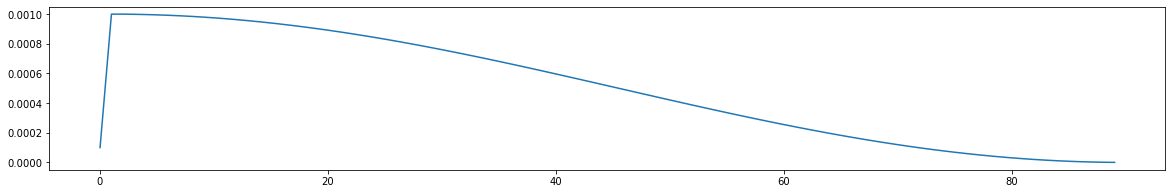

In [19]:
m = CustomModel(model_name=baseline_name, pretrained=True)
optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
del m
gc.collect()
plt.plot(lrs)

In [39]:
for fold in range(0, N_FOLDS):
    
    test_index = train.iloc[FOLDS == fold].index.tolist()
    train_index = train.iloc[FOLDS != fold].index.tolist()

    train_images, valid_images = IMG[train_index], IMG[test_index]
    train_targets0, valid_targets0 = T1[train_index], T1[test_index]
    train_targets1, valid_targets1 = T2[train_index], T2[test_index]
    train_targets2, valid_targets2 = T3[train_index], T3[test_index]
    train_targets3, valid_targets3 = T4[train_index], T4[test_index]
    train_dataset = ClassificationDataset(train_images, train_targets0, 
                                          train_targets1, train_targets2, train_targets3, transforms_train)
    valid_dataset = ClassificationDataset(valid_images, valid_targets0, valid_targets1, valid_targets2, valid_targets3, None)
    xtrain_dataset = ClassificationDataset(train_images, train_targets0, 
                                          train_targets1, train_targets2, train_targets3, None)
    xtrain_loader = torch.utils.data.DataLoader(xtrain_dataset, batch_size=Batch_Size,shuffle=True, num_workers=n_workers)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=n_workers)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=n_workers)
    break

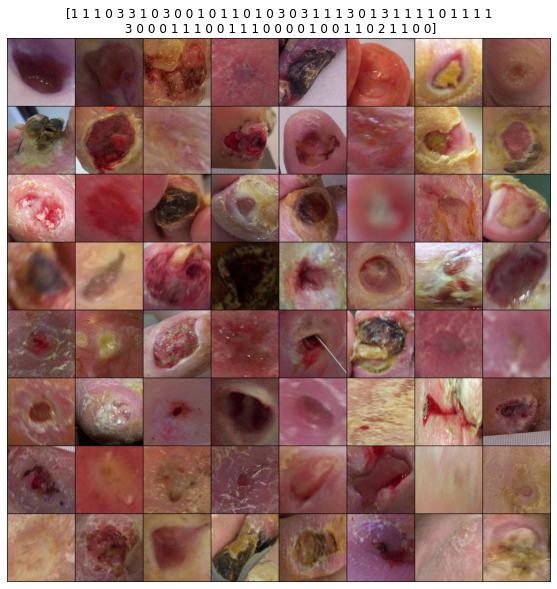

In [40]:
for each in xtrain_loader:
    image = each["image"]
    labels = each["targets0"].to(dtype=torch.long)
    grid = torchvision.utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy());
    break

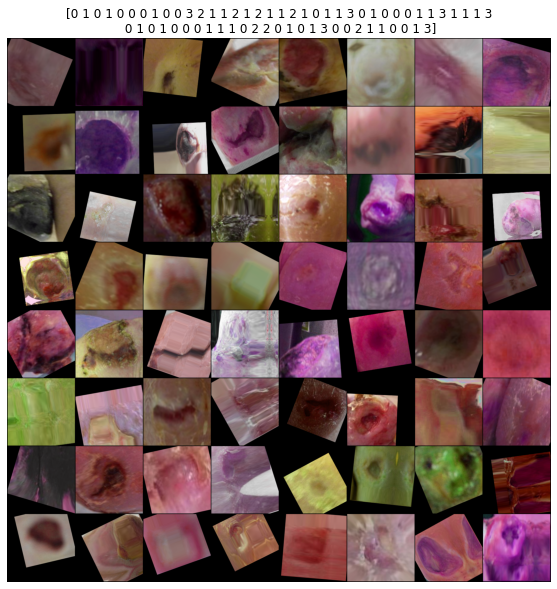

In [37]:
for each in train_loader:
    image = each["image"]
    labels = each["targets0"].to(dtype=torch.long)
    grid = torchvision.utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy());
    break

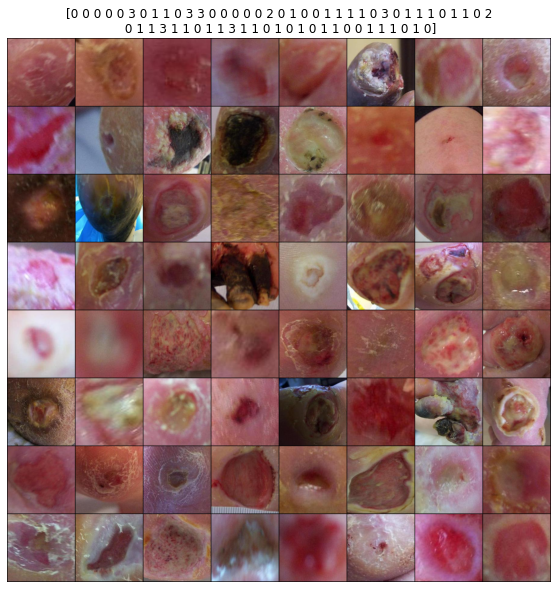

In [38]:
for each in valid_loader:
    image = each["image"]
    labels = each["targets0"].to(dtype=torch.long)
    grid = torchvision.utils.make_grid(image)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy());
    break

In [20]:
for fold in range(0, N_FOLDS):
    
    log_file = "/data0/Salman/alcer/models/" + baseline_name + "_" + str(fold) + "_log.txt"

    content = 'Fold: ' + str(fold)
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')    

    model = CustomModel(model_name=baseline_name, pretrained=True)
    model.to(device)

    test_index = train.iloc[FOLDS == fold].index.tolist()
    train_index = train.iloc[FOLDS != fold].index.tolist()

    train_images, valid_images = IMG[train_index], IMG[test_index]
    train_targets0, valid_targets0 = T1[train_index], T1[test_index]
    train_targets1, valid_targets1 = T2[train_index], T2[test_index]
    train_targets2, valid_targets2 = T3[train_index], T3[test_index]
    train_targets3, valid_targets3 = T4[train_index], T4[test_index]

    train_dataset = ClassificationDataset(train_images, train_targets0, 
                                          train_targets1, train_targets2, train_targets3, transforms_train)
    valid_dataset = ClassificationDataset(valid_images, valid_targets0, valid_targets1, valid_targets2, valid_targets3, None)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=n_workers)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=n_workers)
    valid_targets = np.argmax(np.column_stack([valid_targets0, valid_targets1, valid_targets2, valid_targets3]), axis=1)
    un, co = np.unique(valid_targets, return_counts=True)
    co = co / valid_targets.shape[0]
    content = "Validation Distribution 0, 1, 2, 3 -> " + str(co[0]) + " "  + str(co[1]) + " " + str(co[2]) + " " + str(co[3])
    print (content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')    

    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    best_score = 0
    for epoch in range(n_epochs):

        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch)        

        train_one_epoch(train_loader, model, optimizer, device=device)
        predictions, valid_targets = evaluate(valid_loader, model, device=device)
        predictions = np.array(predictions)
        valid_targets = np.array(valid_targets)
        
        un, co = np.unique(np.argmax(predictions, axis=1), return_counts=True)
        co = co / predictions.shape[0]
        xcontent = "Prediction Distribution 0, 1, 2, 3 -> " + str(co[0]) + " "  + str(co[1]) + " " + str(co[2]) + " " + str(co[3])

        scores, score = get_f1(valid_targets, predictions)
        roc_auc = roc_auc_score(valid_targets, predictions, multi_class='ovr')
        content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, valid macro-f1(avg): {score:.4f}, valid auc: {(roc_auc):.4f}, valid macro-f1(none): {scores[0]:.4f}, valid macro-f1(infection): {scores[1]:.4f}, valid macro-f1(ischaemia): {scores[2]:.4f}, valid macro-f1(both): {scores[3]:.4f}.'
        content = content + " " + xcontent
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')        

        if score > best_score:
            print('Valid Macro-F1(avg) increased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_score, score))
            best_score = score
            torch.save(model.state_dict(),"/data0/Salman/alcer/models/" + baseline_name + '-' + str(fold) + '.pt')
    del model
    gc.collect()
    torch.cuda.empty_cache()

Fold: 0
Validation Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.4290512174643157 0.037783375314861464 0.10411418975650713
Sun Jul 11 04:23:03 2021 Epoch: 0


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:23:41 2021 Fold 0 Epoch 0, lr: 0.0001000, valid macro-f1(avg): 0.3212, valid auc: 0.6829, valid macro-f1(none): 0.5929, valid macro-f1(infection): 0.5244, valid macro-f1(ischaemia): 0.5116, valid macro-f1(both): 0.5713. Prediction Distribution 0, 1, 2, 3 -> 0.290512174643157 0.23929471032745592 0.2703610411418976 0.1998320738874895
Valid Macro-F1(avg) increased (0.000000 --> 0.321174).  Saving model ...
Sun Jul 11 04:23:41 2021 Epoch: 1


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:24:20 2021 Fold 0 Epoch 1, lr: 0.0010000, valid macro-f1(avg): 0.5253, valid auc: 0.8138, valid macro-f1(none): 0.6075, valid macro-f1(infection): 0.6037, valid macro-f1(ischaemia): 0.7039, valid macro-f1(both): 0.7465. Prediction Distribution 0, 1, 2, 3 -> 0.18807724601175482 0.5793450881612091 0.022670025188916875 0.20990764063811923
Valid Macro-F1(avg) increased (0.321174 --> 0.525265).  Saving model ...
Sun Jul 11 04:24:20 2021 Epoch: 2


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:24:59 2021 Fold 0 Epoch 2, lr: 0.0010000, valid macro-f1(avg): 0.5039, valid auc: 0.8485, valid macro-f1(none): 0.7008, valid macro-f1(infection): 0.5891, valid macro-f1(ischaemia): 0.6879, valid macro-f1(both): 0.7264. Prediction Distribution 0, 1, 2, 3 -> 0.4038623005877414 0.2577665827036104 0.033585222502099076 0.3047858942065491
Sun Jul 11 04:24:59 2021 Epoch: 3


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:25:38 2021 Fold 0 Epoch 3, lr: 0.0009988, valid macro-f1(avg): 0.6124, valid auc: 0.8809, valid macro-f1(none): 0.7451, valid macro-f1(infection): 0.6681, valid macro-f1(ischaemia): 0.7697, valid macro-f1(both): 0.7899. Prediction Distribution 0, 1, 2, 3 -> 0.47019311502938704 0.3123425692695214 0.07052896725440806 0.14693534844668346
Valid Macro-F1(avg) increased (0.525265 --> 0.612389).  Saving model ...
Sun Jul 11 04:25:38 2021 Epoch: 4


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:26:17 2021 Fold 0 Epoch 4, lr: 0.0009972, valid macro-f1(avg): 0.5923, valid auc: 0.8717, valid macro-f1(none): 0.6968, valid macro-f1(infection): 0.6701, valid macro-f1(ischaemia): 0.7657, valid macro-f1(both): 0.7914. Prediction Distribution 0, 1, 2, 3 -> 0.3266162888329135 0.4517212426532326 0.11167086481947942 0.10999160369437448
Sun Jul 11 04:26:17 2021 Epoch: 5


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:26:56 2021 Fold 0 Epoch 5, lr: 0.0009950, valid macro-f1(avg): 0.7204, valid auc: 0.9020, valid macro-f1(none): 0.7463, valid macro-f1(infection): 0.6997, valid macro-f1(ischaemia): 0.8867, valid macro-f1(both): 0.8532. Prediction Distribution 0, 1, 2, 3 -> 0.5549958018471872 0.29219143576826195 0.037783375314861464 0.11502938706968933
Valid Macro-F1(avg) increased (0.612389 --> 0.720386).  Saving model ...
Sun Jul 11 04:26:56 2021 Epoch: 6


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:27:35 2021 Fold 0 Epoch 6, lr: 0.0009922, valid macro-f1(avg): 0.7264, valid auc: 0.9118, valid macro-f1(none): 0.7730, valid macro-f1(infection): 0.7389, valid macro-f1(ischaemia): 0.8653, valid macro-f1(both): 0.8456. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.38371116708648195 0.05877413937867338 0.12762384550797648
Valid Macro-F1(avg) increased (0.720386 --> 0.726411).  Saving model ...
Sun Jul 11 04:27:35 2021 Epoch: 7


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:28:14 2021 Fold 0 Epoch 7, lr: 0.0009888, valid macro-f1(avg): 0.7481, valid auc: 0.9257, valid macro-f1(none): 0.7914, valid macro-f1(infection): 0.7652, valid macro-f1(ischaemia): 0.8915, valid macro-f1(both): 0.8634. Prediction Distribution 0, 1, 2, 3 -> 0.40554156171284633 0.43157010915197314 0.041981528127623846 0.12090680100755667
Valid Macro-F1(avg) increased (0.726411 --> 0.748102).  Saving model ...
Sun Jul 11 04:28:14 2021 Epoch: 8


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:28:53 2021 Fold 0 Epoch 8, lr: 0.0009848, valid macro-f1(avg): 0.6464, valid auc: 0.9031, valid macro-f1(none): 0.7636, valid macro-f1(infection): 0.6559, valid macro-f1(ischaemia): 0.8563, valid macro-f1(both): 0.8002. Prediction Distribution 0, 1, 2, 3 -> 0.45843828715365237 0.2686817800167926 0.07556675062972293 0.19731318219983207
Sun Jul 11 04:28:53 2021 Epoch: 9


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:29:31 2021 Fold 0 Epoch 9, lr: 0.0009802, valid macro-f1(avg): 0.7431, valid auc: 0.9242, valid macro-f1(none): 0.7960, valid macro-f1(infection): 0.7705, valid macro-f1(ischaemia): 0.8767, valid macro-f1(both): 0.8319. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.382031905961377 0.06213266162888329 0.10747271200671704
Sun Jul 11 04:29:31 2021 Epoch: 10


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:30:10 2021 Fold 0 Epoch 10, lr: 0.0009750, valid macro-f1(avg): 0.6513, valid auc: 0.9034, valid macro-f1(none): 0.7696, valid macro-f1(infection): 0.7227, valid macro-f1(ischaemia): 0.7789, valid macro-f1(both): 0.8135. Prediction Distribution 0, 1, 2, 3 -> 0.40890008396305627 0.3232577665827036 0.06297229219143577 0.20486985726280438
Sun Jul 11 04:30:10 2021 Epoch: 11


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:30:49 2021 Fold 0 Epoch 11, lr: 0.0009692, valid macro-f1(avg): 0.6130, valid auc: 0.9013, valid macro-f1(none): 0.7684, valid macro-f1(infection): 0.7199, valid macro-f1(ischaemia): 0.6818, valid macro-f1(both): 0.8152. Prediction Distribution 0, 1, 2, 3 -> 0.3778337531486146 0.32577665827036106 0.13685978169605373 0.15952980688497062
Sun Jul 11 04:30:49 2021 Epoch: 12


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:31:28 2021 Fold 0 Epoch 12, lr: 0.0009628, valid macro-f1(avg): 0.7582, valid auc: 0.9325, valid macro-f1(none): 0.7907, valid macro-f1(infection): 0.7665, valid macro-f1(ischaemia): 0.8956, valid macro-f1(both): 0.8730. Prediction Distribution 0, 1, 2, 3 -> 0.5054575986565911 0.34844668345927793 0.052057094878253565 0.09403862300587741
Valid Macro-F1(avg) increased (0.748102 --> 0.758220).  Saving model ...
Sun Jul 11 04:31:28 2021 Epoch: 13


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:32:07 2021 Fold 0 Epoch 13, lr: 0.0009558, valid macro-f1(avg): 0.6964, valid auc: 0.9217, valid macro-f1(none): 0.7925, valid macro-f1(infection): 0.7286, valid macro-f1(ischaemia): 0.8448, valid macro-f1(both): 0.8422. Prediction Distribution 0, 1, 2, 3 -> 0.5130142737195634 0.28127623845507976 0.06297229219143577 0.14273719563392107
Sun Jul 11 04:32:07 2021 Epoch: 14


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:32:46 2021 Fold 0 Epoch 14, lr: 0.0009483, valid macro-f1(avg): 0.7659, valid auc: 0.9339, valid macro-f1(none): 0.7850, valid macro-f1(infection): 0.7551, valid macro-f1(ischaemia): 0.8811, valid macro-f1(both): 0.8965. Prediction Distribution 0, 1, 2, 3 -> 0.5684298908480269 0.2779177162048699 0.04953820319059614 0.10411418975650713
Valid Macro-F1(avg) increased (0.758220 --> 0.765935).  Saving model ...
Sun Jul 11 04:32:46 2021 Epoch: 15


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:33:25 2021 Fold 0 Epoch 15, lr: 0.0009402, valid macro-f1(avg): 0.8069, valid auc: 0.9333, valid macro-f1(none): 0.8081, valid macro-f1(infection): 0.7953, valid macro-f1(ischaemia): 0.9335, valid macro-f1(both): 0.9100. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.399664147774979 0.042821158690176324 0.10579345088161209
Valid Macro-F1(avg) increased (0.765935 --> 0.806906).  Saving model ...
Sun Jul 11 04:33:25 2021 Epoch: 16


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:34:04 2021 Fold 0 Epoch 16, lr: 0.0009315, valid macro-f1(avg): 0.7866, valid auc: 0.9450, valid macro-f1(none): 0.8255, valid macro-f1(infection): 0.8013, valid macro-f1(ischaemia): 0.9068, valid macro-f1(both): 0.8598. Prediction Distribution 0, 1, 2, 3 -> 0.4005037783375315 0.3971452560873216 0.041981528127623846 0.16036943744752308
Sun Jul 11 04:34:04 2021 Epoch: 17


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:34:43 2021 Fold 0 Epoch 17, lr: 0.0009224, valid macro-f1(avg): 0.7576, valid auc: 0.9531, valid macro-f1(none): 0.8223, valid macro-f1(infection): 0.7897, valid macro-f1(ischaemia): 0.8452, valid macro-f1(both): 0.8912. Prediction Distribution 0, 1, 2, 3 -> 0.5214105793450882 0.2989084802686818 0.0654911838790932 0.11418975650713686
Sun Jul 11 04:34:43 2021 Epoch: 18


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:35:22 2021 Fold 0 Epoch 18, lr: 0.0009126, valid macro-f1(avg): 0.7742, valid auc: 0.9463, valid macro-f1(none): 0.8217, valid macro-f1(infection): 0.8070, valid macro-f1(ischaemia): 0.8836, valid macro-f1(both): 0.8745. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.37363560033585225 0.055415617128463476 0.1385390428211587
Sun Jul 11 04:35:22 2021 Epoch: 19


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:36:00 2021 Fold 0 Epoch 19, lr: 0.0009024, valid macro-f1(avg): 0.7668, valid auc: 0.9355, valid macro-f1(none): 0.8197, valid macro-f1(infection): 0.7700, valid macro-f1(ischaemia): 0.9344, valid macro-f1(both): 0.8428. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.3459277917716205 0.036943744752308987 0.17800167926112512
Sun Jul 11 04:36:00 2021 Epoch: 20


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:36:39 2021 Fold 0 Epoch 20, lr: 0.0008917, valid macro-f1(avg): 0.8595, valid auc: 0.9536, valid macro-f1(none): 0.8312, valid macro-f1(infection): 0.8217, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9471. Prediction Distribution 0, 1, 2, 3 -> 0.473551637279597 0.37615449202350965 0.037783375314861464 0.11251049538203191
Valid Macro-F1(avg) increased (0.806906 --> 0.859462).  Saving model ...
Sun Jul 11 04:36:39 2021 Epoch: 21


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:37:18 2021 Fold 0 Epoch 21, lr: 0.0008805, valid macro-f1(avg): 0.8421, valid auc: 0.9498, valid macro-f1(none): 0.8336, valid macro-f1(infection): 0.8126, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9383. Prediction Distribution 0, 1, 2, 3 -> 0.4995801847187238 0.3492863140218304 0.03946263643996641 0.11167086481947942
Sun Jul 11 04:37:18 2021 Epoch: 22


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:37:57 2021 Fold 0 Epoch 22, lr: 0.0008688, valid macro-f1(avg): 0.8058, valid auc: 0.9500, valid macro-f1(none): 0.8331, valid macro-f1(infection): 0.8199, valid macro-f1(ischaemia): 0.8914, valid macro-f1(both): 0.9154. Prediction Distribution 0, 1, 2, 3 -> 0.41981528127623846 0.40554156171284633 0.05289672544080604 0.12174643157010916
Sun Jul 11 04:37:57 2021 Epoch: 23


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:38:36 2021 Fold 0 Epoch 23, lr: 0.0008567, valid macro-f1(avg): 0.7183, valid auc: 0.9274, valid macro-f1(none): 0.8060, valid macro-f1(infection): 0.7713, valid macro-f1(ischaemia): 0.7559, valid macro-f1(both): 0.9178. Prediction Distribution 0, 1, 2, 3 -> 0.4617968094038623 0.32157850545759864 0.0764063811922754 0.14021830394626364
Sun Jul 11 04:38:36 2021 Epoch: 24


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:39:15 2021 Fold 0 Epoch 24, lr: 0.0008441, valid macro-f1(avg): 0.8225, valid auc: 0.9526, valid macro-f1(none): 0.8248, valid macro-f1(infection): 0.8187, valid macro-f1(ischaemia): 0.9255, valid macro-f1(both): 0.9337. Prediction Distribution 0, 1, 2, 3 -> 0.38706968933669184 0.44080604534005036 0.04785894206549118 0.12426532325776658
Sun Jul 11 04:39:15 2021 Epoch: 25


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:39:54 2021 Fold 0 Epoch 25, lr: 0.0008311, valid macro-f1(avg): 0.8150, valid auc: 0.9586, valid macro-f1(none): 0.8499, valid macro-f1(infection): 0.8244, valid macro-f1(ischaemia): 0.9210, valid macro-f1(both): 0.8946. Prediction Distribution 0, 1, 2, 3 -> 0.39378673383711166 0.4164567590260285 0.047019311502938706 0.14273719563392107
Sun Jul 11 04:39:54 2021 Epoch: 26


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:40:33 2021 Fold 0 Epoch 26, lr: 0.0008176, valid macro-f1(avg): 0.8606, valid auc: 0.9635, valid macro-f1(none): 0.8502, valid macro-f1(infection): 0.8454, valid macro-f1(ischaemia): 0.9423, valid macro-f1(both): 0.9427. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.4080604534005038 0.037783375314861464 0.11838790931989925
Valid Macro-F1(avg) increased (0.859462 --> 0.860604).  Saving model ...
Sun Jul 11 04:40:33 2021 Epoch: 27


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:41:12 2021 Fold 0 Epoch 27, lr: 0.0008038, valid macro-f1(avg): 0.8722, valid auc: 0.9648, valid macro-f1(none): 0.8665, valid macro-f1(infection): 0.8511, valid macro-f1(ischaemia): 0.9548, valid macro-f1(both): 0.9539. Prediction Distribution 0, 1, 2, 3 -> 0.4626364399664148 0.38455079764903444 0.04030226700251889 0.11251049538203191
Valid Macro-F1(avg) increased (0.860604 --> 0.872226).  Saving model ...
Sun Jul 11 04:41:12 2021 Epoch: 28


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:41:51 2021 Fold 0 Epoch 28, lr: 0.0007896, valid macro-f1(avg): 0.8506, valid auc: 0.9685, valid macro-f1(none): 0.8634, valid macro-f1(infection): 0.8637, valid macro-f1(ischaemia): 0.9287, valid macro-f1(both): 0.9294. Prediction Distribution 0, 1, 2, 3 -> 0.4248530646515533 0.3971452560873216 0.042821158690176324 0.1351805205709488
Sun Jul 11 04:41:51 2021 Epoch: 29


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:42:30 2021 Fold 0 Epoch 29, lr: 0.0007750, valid macro-f1(avg): 0.8536, valid auc: 0.9716, valid macro-f1(none): 0.8757, valid macro-f1(infection): 0.8574, valid macro-f1(ischaemia): 0.9301, valid macro-f1(both): 0.9285. Prediction Distribution 0, 1, 2, 3 -> 0.4878253568429891 0.345088161209068 0.04450041981528128 0.12258606213266163
Sun Jul 11 04:42:30 2021 Epoch: 30


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:43:08 2021 Fold 0 Epoch 30, lr: 0.0007601, valid macro-f1(avg): 0.8395, valid auc: 0.9718, valid macro-f1(none): 0.8758, valid macro-f1(infection): 0.8827, valid macro-f1(ischaemia): 0.9096, valid macro-f1(both): 0.9193. Prediction Distribution 0, 1, 2, 3 -> 0.3895885810243493 0.43828715365239296 0.0436607892527288 0.12846347607052896
Sun Jul 11 04:43:08 2021 Epoch: 31


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:43:47 2021 Fold 0 Epoch 31, lr: 0.0007449, valid macro-f1(avg): 0.8840, valid auc: 0.9756, valid macro-f1(none): 0.8891, valid macro-f1(infection): 0.8767, valid macro-f1(ischaemia): 0.9507, valid macro-f1(both): 0.9469. Prediction Distribution 0, 1, 2, 3 -> 0.4475230898404702 0.3904282115869018 0.041981528127623846 0.1200671704450042
Valid Macro-F1(avg) increased (0.872226 --> 0.884044).  Saving model ...
Sun Jul 11 04:43:47 2021 Epoch: 32


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:44:26 2021 Fold 0 Epoch 32, lr: 0.0007294, valid macro-f1(avg): 0.8344, valid auc: 0.9701, valid macro-f1(none): 0.8628, valid macro-f1(infection): 0.8471, valid macro-f1(ischaemia): 0.9329, valid macro-f1(both): 0.8936. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.36523929471032746 0.033585222502099076 0.14777497900923595
Sun Jul 11 04:44:26 2021 Epoch: 33


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:45:05 2021 Fold 0 Epoch 33, lr: 0.0007135, valid macro-f1(avg): 0.8733, valid auc: 0.9721, valid macro-f1(none): 0.8688, valid macro-f1(infection): 0.8657, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9532. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.3963056255247691 0.041981528127623846 0.109151973131822
Sun Jul 11 04:45:05 2021 Epoch: 34


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:45:44 2021 Fold 0 Epoch 34, lr: 0.0006974, valid macro-f1(avg): 0.8743, valid auc: 0.9722, valid macro-f1(none): 0.8776, valid macro-f1(infection): 0.8703, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9363. Prediction Distribution 0, 1, 2, 3 -> 0.4634760705289673 0.3702770780856423 0.038623005877413935 0.12762384550797648
Sun Jul 11 04:45:44 2021 Epoch: 35


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:46:23 2021 Fold 0 Epoch 35, lr: 0.0006811, valid macro-f1(avg): 0.8687, valid auc: 0.9733, valid macro-f1(none): 0.8776, valid macro-f1(infection): 0.8739, valid macro-f1(ischaemia): 0.9165, valid macro-f1(both): 0.9565. Prediction Distribution 0, 1, 2, 3 -> 0.4651553316540722 0.38623005877413935 0.047019311502938706 0.1015952980688497
Sun Jul 11 04:46:23 2021 Epoch: 36


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:47:02 2021 Fold 0 Epoch 36, lr: 0.0006645, valid macro-f1(avg): 0.8876, valid auc: 0.9775, valid macro-f1(none): 0.8953, valid macro-f1(infection): 0.8861, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9469. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.4080604534005038 0.042821158690176324 0.11922753988245172
Valid Macro-F1(avg) increased (0.884044 --> 0.887593).  Saving model ...
Sun Jul 11 04:47:02 2021 Epoch: 37


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:47:41 2021 Fold 0 Epoch 37, lr: 0.0006478, valid macro-f1(avg): 0.8766, valid auc: 0.9755, valid macro-f1(none): 0.8833, valid macro-f1(infection): 0.8694, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9411. Prediction Distribution 0, 1, 2, 3 -> 0.45424013434089 0.38371116708648195 0.038623005877413935 0.12342569269521411
Sun Jul 11 04:47:41 2021 Epoch: 38


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:48:20 2021 Fold 0 Epoch 38, lr: 0.0006308, valid macro-f1(avg): 0.9016, valid auc: 0.9782, valid macro-f1(none): 0.8989, valid macro-f1(infection): 0.8988, valid macro-f1(ischaemia): 0.9451, valid macro-f1(both): 0.9664. Prediction Distribution 0, 1, 2, 3 -> 0.40218303946263645 0.45843828715365237 0.033585222502099076 0.10579345088161209
Valid Macro-F1(avg) increased (0.887593 --> 0.901586).  Saving model ...
Sun Jul 11 04:48:20 2021 Epoch: 39


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:48:59 2021 Fold 0 Epoch 39, lr: 0.0006137, valid macro-f1(avg): 0.8927, valid auc: 0.9772, valid macro-f1(none): 0.8988, valid macro-f1(infection): 0.8922, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9603. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.3887489504617968 0.041981528127623846 0.10999160369437448
Sun Jul 11 04:48:59 2021 Epoch: 40


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:49:38 2021 Fold 0 Epoch 40, lr: 0.0005965, valid macro-f1(avg): 0.9129, valid auc: 0.9800, valid macro-f1(none): 0.8966, valid macro-f1(infection): 0.8880, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9580. Prediction Distribution 0, 1, 2, 3 -> 0.4399664147774979 0.41141897565071367 0.03946263643996641 0.109151973131822
Valid Macro-F1(avg) increased (0.901586 --> 0.912936).  Saving model ...
Sun Jul 11 04:49:38 2021 Epoch: 41


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:50:17 2021 Fold 0 Epoch 41, lr: 0.0005791, valid macro-f1(avg): 0.8997, valid auc: 0.9799, valid macro-f1(none): 0.8984, valid macro-f1(infection): 0.8820, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9538. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.3929471032745592 0.03946263643996641 0.12090680100755667
Sun Jul 11 04:50:17 2021 Epoch: 42


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:50:56 2021 Fold 0 Epoch 42, lr: 0.0005616, valid macro-f1(avg): 0.8960, valid auc: 0.9806, valid macro-f1(none): 0.8982, valid macro-f1(infection): 0.8931, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9525. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.40890008396305627 0.037783375314861464 0.11670864819479429
Sun Jul 11 04:50:56 2021 Epoch: 43


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:51:35 2021 Fold 0 Epoch 43, lr: 0.0005441, valid macro-f1(avg): 0.9136, valid auc: 0.9795, valid macro-f1(none): 0.9032, valid macro-f1(infection): 0.8957, valid macro-f1(ischaemia): 0.9778, valid macro-f1(both): 0.9611. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.40973971452560876 0.04114189756507137 0.11502938706968933
Valid Macro-F1(avg) increased (0.912936 --> 0.913645).  Saving model ...
Sun Jul 11 04:51:35 2021 Epoch: 44


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:52:14 2021 Fold 0 Epoch 44, lr: 0.0005265, valid macro-f1(avg): 0.9043, valid auc: 0.9827, valid macro-f1(none): 0.8968, valid macro-f1(infection): 0.8953, valid macro-f1(ischaemia): 0.9548, valid macro-f1(both): 0.9734. Prediction Distribution 0, 1, 2, 3 -> 0.3929471032745592 0.45759865659109994 0.04030226700251889 0.109151973131822
Sun Jul 11 04:52:14 2021 Epoch: 45


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:52:52 2021 Fold 0 Epoch 45, lr: 0.0005088, valid macro-f1(avg): 0.9152, valid auc: 0.9817, valid macro-f1(none): 0.9032, valid macro-f1(infection): 0.8938, valid macro-f1(ischaemia): 0.9769, valid macro-f1(both): 0.9673. Prediction Distribution 0, 1, 2, 3 -> 0.4643157010915197 0.3853904282115869 0.037783375314861464 0.11251049538203191
Valid Macro-F1(avg) increased (0.913645 --> 0.915156).  Saving model ...
Sun Jul 11 04:52:53 2021 Epoch: 46


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:53:31 2021 Fold 0 Epoch 46, lr: 0.0004912, valid macro-f1(avg): 0.9048, valid auc: 0.9791, valid macro-f1(none): 0.9001, valid macro-f1(infection): 0.8984, valid macro-f1(ischaemia): 0.9468, valid macro-f1(both): 0.9724. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.41225860621326615 0.04450041981528128 0.10075566750629723
Sun Jul 11 04:53:31 2021 Epoch: 47


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:54:10 2021 Fold 0 Epoch 47, lr: 0.0004735, valid macro-f1(avg): 0.9126, valid auc: 0.9807, valid macro-f1(none): 0.9005, valid macro-f1(infection): 0.8958, valid macro-f1(ischaemia): 0.9720, valid macro-f1(both): 0.9655. Prediction Distribution 0, 1, 2, 3 -> 0.40134340890008396 0.4433249370277078 0.04030226700251889 0.11502938706968933
Sun Jul 11 04:54:10 2021 Epoch: 48


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:54:49 2021 Fold 0 Epoch 48, lr: 0.0004559, valid macro-f1(avg): 0.9270, valid auc: 0.9867, valid macro-f1(none): 0.9254, valid macro-f1(infection): 0.9211, valid macro-f1(ischaemia): 0.9600, valid macro-f1(both): 0.9778. Prediction Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.4256926952141058 0.038623005877413935 0.10747271200671704
Valid Macro-F1(avg) increased (0.915156 --> 0.926953).  Saving model ...
Sun Jul 11 04:54:49 2021 Epoch: 49


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:55:28 2021 Fold 0 Epoch 49, lr: 0.0004384, valid macro-f1(avg): 0.9256, valid auc: 0.9852, valid macro-f1(none): 0.9177, valid macro-f1(infection): 0.9155, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9758. Prediction Distribution 0, 1, 2, 3 -> 0.4693534844668346 0.38287153652392947 0.037783375314861464 0.10999160369437448
Sun Jul 11 04:55:28 2021 Epoch: 50


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:56:07 2021 Fold 0 Epoch 50, lr: 0.0004209, valid macro-f1(avg): 0.9335, valid auc: 0.9866, valid macro-f1(none): 0.9216, valid macro-f1(infection): 0.9239, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9757. Prediction Distribution 0, 1, 2, 3 -> 0.4508816120906801 0.40302267002518893 0.03610411418975651 0.10999160369437448
Valid Macro-F1(avg) increased (0.926953 --> 0.933453).  Saving model ...
Sun Jul 11 04:56:07 2021 Epoch: 51


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:56:46 2021 Fold 0 Epoch 51, lr: 0.0004035, valid macro-f1(avg): 0.9351, valid auc: 0.9885, valid macro-f1(none): 0.9252, valid macro-f1(infection): 0.9229, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.3954659949622166 0.03610411418975651 0.109151973131822
Valid Macro-F1(avg) increased (0.933453 --> 0.935087).  Saving model ...
Sun Jul 11 04:56:46 2021 Epoch: 52


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:57:25 2021 Fold 0 Epoch 52, lr: 0.0003863, valid macro-f1(avg): 0.9230, valid auc: 0.9891, valid macro-f1(none): 0.9342, valid macro-f1(infection): 0.9284, valid macro-f1(ischaemia): 0.9496, valid macro-f1(both): 0.9715. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.4063811922753988 0.04030226700251889 0.11083123425692695
Sun Jul 11 04:57:25 2021 Epoch: 53


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:58:04 2021 Fold 0 Epoch 53, lr: 0.0003692, valid macro-f1(avg): 0.9266, valid auc: 0.9896, valid macro-f1(none): 0.9263, valid macro-f1(infection): 0.9226, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9698. Prediction Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.418975650713686 0.037783375314861464 0.11418975650713686
Sun Jul 11 04:58:04 2021 Epoch: 54


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:58:43 2021 Fold 0 Epoch 54, lr: 0.0003522, valid macro-f1(avg): 0.9420, valid auc: 0.9890, valid macro-f1(none): 0.9383, valid macro-f1(infection): 0.9322, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9739. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.42401343408900083 0.03526448362720403 0.11335012594458438
Valid Macro-F1(avg) increased (0.935087 --> 0.941991).  Saving model ...
Sun Jul 11 04:58:43 2021 Epoch: 55


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 04:59:22 2021 Fold 0 Epoch 55, lr: 0.0003355, valid macro-f1(avg): 0.9416, valid auc: 0.9894, valid macro-f1(none): 0.9410, valid macro-f1(infection): 0.9381, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9781. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.4156171284634761 0.036943744752308987 0.11083123425692695
Sun Jul 11 04:59:22 2021 Epoch: 56


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:00:01 2021 Fold 0 Epoch 56, lr: 0.0003189, valid macro-f1(avg): 0.9442, valid auc: 0.9891, valid macro-f1(none): 0.9394, valid macro-f1(infection): 0.9362, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4105793450881612 0.03610411418975651 0.10999160369437448
Valid Macro-F1(avg) increased (0.941991 --> 0.944229).  Saving model ...
Sun Jul 11 05:00:01 2021 Epoch: 57


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:00:39 2021 Fold 0 Epoch 57, lr: 0.0003026, valid macro-f1(avg): 0.9372, valid auc: 0.9898, valid macro-f1(none): 0.9359, valid macro-f1(infection): 0.9363, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.4139378673383711 0.037783375314861464 0.109151973131822
Sun Jul 11 05:00:39 2021 Epoch: 58


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:01:18 2021 Fold 0 Epoch 58, lr: 0.0002865, valid macro-f1(avg): 0.9403, valid auc: 0.9892, valid macro-f1(none): 0.9419, valid macro-f1(infection): 0.9389, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9800. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.4164567590260285 0.037783375314861464 0.10663308144416457
Sun Jul 11 05:01:18 2021 Epoch: 59


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:01:57 2021 Fold 0 Epoch 59, lr: 0.0002706, valid macro-f1(avg): 0.9377, valid auc: 0.9892, valid macro-f1(none): 0.9330, valid macro-f1(infection): 0.9298, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9739. Prediction Distribution 0, 1, 2, 3 -> 0.418975650713686 0.4324097397145256 0.03610411418975651 0.11251049538203191
Sun Jul 11 05:01:57 2021 Epoch: 60


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:02:36 2021 Fold 0 Epoch 60, lr: 0.0002551, valid macro-f1(avg): 0.9306, valid auc: 0.9884, valid macro-f1(none): 0.9374, valid macro-f1(infection): 0.9303, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9538. Prediction Distribution 0, 1, 2, 3 -> 0.4248530646515533 0.4181360201511335 0.03610411418975651 0.12090680100755667
Sun Jul 11 05:02:36 2021 Epoch: 61


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:03:15 2021 Fold 0 Epoch 61, lr: 0.0002399, valid macro-f1(avg): 0.9440, valid auc: 0.9907, valid macro-f1(none): 0.9409, valid macro-f1(infection): 0.9373, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.42149454240134343 0.03610411418975651 0.109151973131822
Sun Jul 11 05:03:15 2021 Epoch: 62


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:03:54 2021 Fold 0 Epoch 62, lr: 0.0002250, valid macro-f1(avg): 0.9423, valid auc: 0.9899, valid macro-f1(none): 0.9436, valid macro-f1(infection): 0.9414, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9758. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.41225860621326615 0.036943744752308987 0.10999160369437448
Sun Jul 11 05:03:54 2021 Epoch: 63


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:04:33 2021 Fold 0 Epoch 63, lr: 0.0002104, valid macro-f1(avg): 0.9377, valid auc: 0.9907, valid macro-f1(none): 0.9418, valid macro-f1(infection): 0.9399, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9737. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42065491183879095 0.037783375314861464 0.11083123425692695
Sun Jul 11 05:04:33 2021 Epoch: 64


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:05:12 2021 Fold 0 Epoch 64, lr: 0.0001962, valid macro-f1(avg): 0.9448, valid auc: 0.9918, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9476, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.42149454240134343 0.037783375314861464 0.10831234256926953
Valid Macro-F1(avg) increased (0.944229 --> 0.944766).  Saving model ...
Sun Jul 11 05:05:12 2021 Epoch: 65


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:05:51 2021 Fold 0 Epoch 65, lr: 0.0001824, valid macro-f1(avg): 0.9458, valid auc: 0.9920, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9467, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9760. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.418975650713686 0.036943744752308987 0.11167086481947942
Valid Macro-F1(avg) increased (0.944766 --> 0.945776).  Saving model ...
Sun Jul 11 05:05:51 2021 Epoch: 66


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:06:30 2021 Fold 0 Epoch 66, lr: 0.0001689, valid macro-f1(avg): 0.9578, valid auc: 0.9923, valid macro-f1(none): 0.9505, valid macro-f1(infection): 0.9509, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4139378673383711 0.03526448362720403 0.10747271200671704
Valid Macro-F1(avg) increased (0.945776 --> 0.957768).  Saving model ...
Sun Jul 11 05:06:30 2021 Epoch: 67


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:07:09 2021 Fold 0 Epoch 67, lr: 0.0001559, valid macro-f1(avg): 0.9543, valid auc: 0.9929, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9511, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.42317380352644834 0.03610411418975651 0.10747271200671704
Sun Jul 11 05:07:09 2021 Epoch: 68


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:07:47 2021 Fold 0 Epoch 68, lr: 0.0001433, valid macro-f1(avg): 0.9499, valid auc: 0.9928, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9502, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.4248530646515533 0.036943744752308987 0.109151973131822
Sun Jul 11 05:07:47 2021 Epoch: 69


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:08:26 2021 Fold 0 Epoch 69, lr: 0.0001312, valid macro-f1(avg): 0.9526, valid auc: 0.9928, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9502, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.4248530646515533 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:08:26 2021 Epoch: 70


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:09:05 2021 Fold 0 Epoch 70, lr: 0.0001195, valid macro-f1(avg): 0.9518, valid auc: 0.9929, valid macro-f1(none): 0.9493, valid macro-f1(infection): 0.9487, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.4164567590260285 0.43828715365239296 0.03610411418975651 0.109151973131822
Sun Jul 11 05:09:05 2021 Epoch: 71


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:09:44 2021 Fold 0 Epoch 71, lr: 0.0001083, valid macro-f1(avg): 0.9494, valid auc: 0.9925, valid macro-f1(none): 0.9453, valid macro-f1(infection): 0.9450, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9822. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.418975650713686 0.03610411418975651 0.10747271200671704
Sun Jul 11 05:09:44 2021 Epoch: 72


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:10:23 2021 Fold 0 Epoch 72, lr: 0.0000976, valid macro-f1(avg): 0.9509, valid auc: 0.9930, valid macro-f1(none): 0.9520, valid macro-f1(infection): 0.9511, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.4248530646515533 0.03610411418975651 0.109151973131822
Sun Jul 11 05:10:23 2021 Epoch: 73


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:11:02 2021 Fold 0 Epoch 73, lr: 0.0000874, valid macro-f1(avg): 0.9517, valid auc: 0.9923, valid macro-f1(none): 0.9469, valid macro-f1(infection): 0.9459, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9802. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.42149454240134343 0.03526448362720403 0.10999160369437448
Sun Jul 11 05:11:02 2021 Epoch: 74


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:11:41 2021 Fold 0 Epoch 74, lr: 0.0000776, valid macro-f1(avg): 0.9519, valid auc: 0.9929, valid macro-f1(none): 0.9479, valid macro-f1(infection): 0.9484, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9781. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4156171284634761 0.03526448362720403 0.11083123425692695
Sun Jul 11 05:11:41 2021 Epoch: 75


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:12:20 2021 Fold 0 Epoch 75, lr: 0.0000685, valid macro-f1(avg): 0.9524, valid auc: 0.9933, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9494, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9781. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.4265323257766583 0.03526448362720403 0.11083123425692695
Sun Jul 11 05:12:20 2021 Epoch: 76


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:12:58 2021 Fold 0 Epoch 76, lr: 0.0000598, valid macro-f1(avg): 0.9588, valid auc: 0.9936, valid macro-f1(none): 0.9538, valid macro-f1(infection): 0.9536, valid macro-f1(ischaemia): 0.9885, valid macro-f1(both): 0.9822. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.42065491183879095 0.037783375314861464 0.10831234256926953
Valid Macro-F1(avg) increased (0.957768 --> 0.958823).  Saving model ...
Sun Jul 11 05:12:59 2021 Epoch: 77


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:13:37 2021 Fold 0 Epoch 77, lr: 0.0000517, valid macro-f1(avg): 0.9643, valid auc: 0.9938, valid macro-f1(none): 0.9547, valid macro-f1(infection): 0.9544, valid macro-f1(ischaemia): 0.9943, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.4181360201511335 0.038623005877413935 0.10663308144416457
Valid Macro-F1(avg) increased (0.958823 --> 0.964297).  Saving model ...
Sun Jul 11 05:13:38 2021 Epoch: 78


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:14:16 2021 Fold 0 Epoch 78, lr: 0.0000442, valid macro-f1(avg): 0.9509, valid auc: 0.9938, valid macro-f1(none): 0.9504, valid macro-f1(infection): 0.9519, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.418975650713686 0.03610411418975651 0.109151973131822
Sun Jul 11 05:14:16 2021 Epoch: 79


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:14:55 2021 Fold 0 Epoch 79, lr: 0.0000372, valid macro-f1(avg): 0.9521, valid auc: 0.9938, valid macro-f1(none): 0.9513, valid macro-f1(infection): 0.9518, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9822. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.417296389588581 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:14:55 2021 Epoch: 80


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:15:34 2021 Fold 0 Epoch 80, lr: 0.0000308, valid macro-f1(avg): 0.9528, valid auc: 0.9941, valid macro-f1(none): 0.9513, valid macro-f1(infection): 0.9510, valid macro-f1(ischaemia): 0.9821, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.4181360201511335 0.03610411418975651 0.109151973131822
Sun Jul 11 05:15:34 2021 Epoch: 81


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:16:13 2021 Fold 0 Epoch 81, lr: 0.0000250, valid macro-f1(avg): 0.9479, valid auc: 0.9942, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9511, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42317380352644834 0.036943744752308987 0.109151973131822
Sun Jul 11 05:16:13 2021 Epoch: 82


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:16:52 2021 Fold 0 Epoch 82, lr: 0.0000198, valid macro-f1(avg): 0.9476, valid auc: 0.9941, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9485, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.4256926952141058 0.036943744752308987 0.10831234256926953
Sun Jul 11 05:16:52 2021 Epoch: 83


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:17:31 2021 Fold 0 Epoch 83, lr: 0.0000152, valid macro-f1(avg): 0.9526, valid auc: 0.9938, valid macro-f1(none): 0.9529, valid macro-f1(infection): 0.9528, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.42149454240134343 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:17:31 2021 Epoch: 84


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:18:10 2021 Fold 0 Epoch 84, lr: 0.0000112, valid macro-f1(avg): 0.9521, valid auc: 0.9943, valid macro-f1(none): 0.9521, valid macro-f1(infection): 0.9519, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.434928631402183 0.42065491183879095 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:18:10 2021 Epoch: 85


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:18:48 2021 Fold 0 Epoch 85, lr: 0.0000078, valid macro-f1(avg): 0.9516, valid auc: 0.9940, valid macro-f1(none): 0.9513, valid macro-f1(infection): 0.9509, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.4147774979009236 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:18:48 2021 Epoch: 86


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:19:27 2021 Fold 0 Epoch 86, lr: 0.0000050, valid macro-f1(avg): 0.9474, valid auc: 0.9942, valid macro-f1(none): 0.9495, valid macro-f1(infection): 0.9502, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9780. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.42401343408900083 0.036943744752308987 0.109151973131822
Sun Jul 11 05:19:27 2021 Epoch: 87


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:20:06 2021 Fold 0 Epoch 87, lr: 0.0000028, valid macro-f1(avg): 0.9496, valid auc: 0.9942, valid macro-f1(none): 0.9520, valid macro-f1(infection): 0.9519, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42401343408900083 0.036943744752308987 0.10831234256926953
Sun Jul 11 05:20:06 2021 Epoch: 88


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:20:45 2021 Fold 0 Epoch 88, lr: 0.0000012, valid macro-f1(avg): 0.9481, valid auc: 0.9942, valid macro-f1(none): 0.9495, valid macro-f1(infection): 0.9502, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.42317380352644834 0.036943744752308987 0.10831234256926953
Sun Jul 11 05:20:45 2021 Epoch: 89


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:21:24 2021 Fold 0 Epoch 89, lr: 0.0000003, valid macro-f1(avg): 0.9506, valid auc: 0.9939, valid macro-f1(none): 0.9487, valid macro-f1(infection): 0.9493, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.41981528127623846 0.03610411418975651 0.10831234256926953
Fold: 1
Validation Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.4290512174643157 0.037783375314861464 0.10411418975650713
Sun Jul 11 05:21:26 2021 Epoch: 0


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:22:05 2021 Fold 1 Epoch 0, lr: 0.0001000, valid macro-f1(avg): 0.3796, valid auc: 0.7088, valid macro-f1(none): 0.6206, valid macro-f1(infection): 0.5589, valid macro-f1(ischaemia): 0.5889, valid macro-f1(both): 0.6071. Prediction Distribution 0, 1, 2, 3 -> 0.3266162888329135 0.3350125944584383 0.1418975650713686 0.1964735516372796
Valid Macro-F1(avg) increased (0.000000 --> 0.379564).  Saving model ...
Sun Jul 11 05:22:05 2021 Epoch: 1


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:22:44 2021 Fold 1 Epoch 1, lr: 0.0010000, valid macro-f1(avg): 0.4308, valid auc: 0.7933, valid macro-f1(none): 0.6409, valid macro-f1(infection): 0.5626, valid macro-f1(ischaemia): 0.6906, valid macro-f1(both): 0.6112. Prediction Distribution 0, 1, 2, 3 -> 0.23509655751469352 0.2871536523929471 0.09655751469353484 0.3811922753988245
Valid Macro-F1(avg) increased (0.379564 --> 0.430779).  Saving model ...
Sun Jul 11 05:22:44 2021 Epoch: 2


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:23:23 2021 Fold 1 Epoch 2, lr: 0.0010000, valid macro-f1(avg): 0.5314, valid auc: 0.8370, valid macro-f1(none): 0.7103, valid macro-f1(infection): 0.6663, valid macro-f1(ischaemia): 0.6881, valid macro-f1(both): 0.6968. Prediction Distribution 0, 1, 2, 3 -> 0.3895885810243493 0.42737195633921077 0.09655751469353484 0.08648194794290512
Valid Macro-F1(avg) increased (0.430779 --> 0.531420).  Saving model ...
Sun Jul 11 05:23:23 2021 Epoch: 3


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:24:02 2021 Fold 1 Epoch 3, lr: 0.0009988, valid macro-f1(avg): 0.6181, valid auc: 0.8722, valid macro-f1(none): 0.7354, valid macro-f1(infection): 0.6872, valid macro-f1(ischaemia): 0.7164, valid macro-f1(both): 0.7809. Prediction Distribution 0, 1, 2, 3 -> 0.4550797649034425 0.3971452560873216 0.0688497061293031 0.07892527287993283
Valid Macro-F1(avg) increased (0.531420 --> 0.618148).  Saving model ...
Sun Jul 11 05:24:02 2021 Epoch: 4


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:24:41 2021 Fold 1 Epoch 4, lr: 0.0009972, valid macro-f1(avg): 0.6546, valid auc: 0.8737, valid macro-f1(none): 0.7470, valid macro-f1(infection): 0.6861, valid macro-f1(ischaemia): 0.7793, valid macro-f1(both): 0.8472. Prediction Distribution 0, 1, 2, 3 -> 0.4256926952141058 0.40302267002518893 0.041981528127623846 0.12930310663308145
Valid Macro-F1(avg) increased (0.618148 --> 0.654618).  Saving model ...
Sun Jul 11 05:24:41 2021 Epoch: 5


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:25:20 2021 Fold 1 Epoch 5, lr: 0.0009950, valid macro-f1(avg): 0.6248, valid auc: 0.8774, valid macro-f1(none): 0.7361, valid macro-f1(infection): 0.6926, valid macro-f1(ischaemia): 0.7621, valid macro-f1(both): 0.8208. Prediction Distribution 0, 1, 2, 3 -> 0.4080604534005038 0.3677581863979849 0.04450041981528128 0.17968094038623006
Sun Jul 11 05:25:20 2021 Epoch: 6


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:26:00 2021 Fold 1 Epoch 6, lr: 0.0009922, valid macro-f1(avg): 0.6324, valid auc: 0.9014, valid macro-f1(none): 0.7779, valid macro-f1(infection): 0.7457, valid macro-f1(ischaemia): 0.7575, valid macro-f1(both): 0.7860. Prediction Distribution 0, 1, 2, 3 -> 0.3744752308984047 0.3887489504617968 0.0654911838790932 0.1712846347607053
Sun Jul 11 05:26:00 2021 Epoch: 7


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:26:39 2021 Fold 1 Epoch 7, lr: 0.0009888, valid macro-f1(avg): 0.6392, valid auc: 0.8995, valid macro-f1(none): 0.7752, valid macro-f1(infection): 0.6959, valid macro-f1(ischaemia): 0.7972, valid macro-f1(both): 0.7813. Prediction Distribution 0, 1, 2, 3 -> 0.38455079764903444 0.33669185558354325 0.047019311502938706 0.23173803526448364
Sun Jul 11 05:26:39 2021 Epoch: 8


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:27:18 2021 Fold 1 Epoch 8, lr: 0.0009848, valid macro-f1(avg): 0.6718, valid auc: 0.9182, valid macro-f1(none): 0.7962, valid macro-f1(infection): 0.7540, valid macro-f1(ischaemia): 0.7718, valid macro-f1(both): 0.8356. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.36272040302267 0.08144416456759027 0.11167086481947942
Valid Macro-F1(avg) increased (0.654618 --> 0.671805).  Saving model ...
Sun Jul 11 05:27:18 2021 Epoch: 9


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:27:57 2021 Fold 1 Epoch 9, lr: 0.0009802, valid macro-f1(avg): 0.6678, valid auc: 0.9124, valid macro-f1(none): 0.7869, valid macro-f1(infection): 0.7409, valid macro-f1(ischaemia): 0.7571, valid macro-f1(both): 0.8392. Prediction Distribution 0, 1, 2, 3 -> 0.3795130142737196 0.38287153652392947 0.09907640638119228 0.1385390428211587
Sun Jul 11 05:27:57 2021 Epoch: 10


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:28:36 2021 Fold 1 Epoch 10, lr: 0.0009750, valid macro-f1(avg): 0.7399, valid auc: 0.9250, valid macro-f1(none): 0.8014, valid macro-f1(infection): 0.7764, valid macro-f1(ischaemia): 0.8291, valid macro-f1(both): 0.8871. Prediction Distribution 0, 1, 2, 3 -> 0.45591939546599497 0.34676742233417296 0.05289672544080604 0.14441645675902604
Valid Macro-F1(avg) increased (0.671805 --> 0.739878).  Saving model ...
Sun Jul 11 05:28:36 2021 Epoch: 11


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:29:15 2021 Fold 1 Epoch 11, lr: 0.0009692, valid macro-f1(avg): 0.7344, valid auc: 0.9177, valid macro-f1(none): 0.7703, valid macro-f1(infection): 0.7513, valid macro-f1(ischaemia): 0.8539, valid macro-f1(both): 0.8946. Prediction Distribution 0, 1, 2, 3 -> 0.4256926952141058 0.4038623005877414 0.05373635600335852 0.11670864819479429
Sun Jul 11 05:29:15 2021 Epoch: 12


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:29:54 2021 Fold 1 Epoch 12, lr: 0.0009628, valid macro-f1(avg): 0.7339, valid auc: 0.9312, valid macro-f1(none): 0.8181, valid macro-f1(infection): 0.7893, valid macro-f1(ischaemia): 0.8294, valid macro-f1(both): 0.8726. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.35852225020990763 0.052057094878253565 0.1561712846347607
Sun Jul 11 05:29:54 2021 Epoch: 13


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:30:33 2021 Fold 1 Epoch 13, lr: 0.0009558, valid macro-f1(avg): 0.7832, valid auc: 0.9310, valid macro-f1(none): 0.7991, valid macro-f1(infection): 0.7853, valid macro-f1(ischaemia): 0.8892, valid macro-f1(both): 0.9135. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.3979848866498741 0.04617968094038623 0.12426532325776658
Valid Macro-F1(avg) increased (0.739878 --> 0.783181).  Saving model ...
Sun Jul 11 05:30:33 2021 Epoch: 14


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:31:13 2021 Fold 1 Epoch 14, lr: 0.0009483, valid macro-f1(avg): 0.7696, valid auc: 0.9402, valid macro-f1(none): 0.8078, valid macro-f1(infection): 0.7844, valid macro-f1(ischaemia): 0.8893, valid macro-f1(both): 0.9009. Prediction Distribution 0, 1, 2, 3 -> 0.40554156171284633 0.4139378673383711 0.05037783375314862 0.13014273719563393
Sun Jul 11 05:31:13 2021 Epoch: 15


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:31:51 2021 Fold 1 Epoch 15, lr: 0.0009402, valid macro-f1(avg): 0.8048, valid auc: 0.9483, valid macro-f1(none): 0.8391, valid macro-f1(infection): 0.8173, valid macro-f1(ischaemia): 0.8914, valid macro-f1(both): 0.9122. Prediction Distribution 0, 1, 2, 3 -> 0.418975650713686 0.4139378673383711 0.03610411418975651 0.1309823677581864
Valid Macro-F1(avg) increased (0.783181 --> 0.804770).  Saving model ...
Sun Jul 11 05:31:52 2021 Epoch: 16


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:32:31 2021 Fold 1 Epoch 16, lr: 0.0009315, valid macro-f1(avg): 0.7138, valid auc: 0.9383, valid macro-f1(none): 0.8208, valid macro-f1(infection): 0.7901, valid macro-f1(ischaemia): 0.7730, valid macro-f1(both): 0.8574. Prediction Distribution 0, 1, 2, 3 -> 0.45591939546599497 0.3635600335852225 0.07724601175482787 0.10327455919395466
Sun Jul 11 05:32:31 2021 Epoch: 17


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:33:10 2021 Fold 1 Epoch 17, lr: 0.0009224, valid macro-f1(avg): 0.3947, valid auc: 0.7635, valid macro-f1(none): 0.5636, valid macro-f1(infection): 0.5425, valid macro-f1(ischaemia): 0.6902, valid macro-f1(both): 0.5598. Prediction Distribution 0, 1, 2, 3 -> 0.8136020151133502 0.14609571788413098 0.026028547439126783 0.014273719563392108
Sun Jul 11 05:33:10 2021 Epoch: 18


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:33:49 2021 Fold 1 Epoch 18, lr: 0.0009126, valid macro-f1(avg): 0.8013, valid auc: 0.9415, valid macro-f1(none): 0.8218, valid macro-f1(infection): 0.8068, valid macro-f1(ischaemia): 0.8686, valid macro-f1(both): 0.9290. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.40302267002518893 0.04114189756507137 0.12174643157010916
Sun Jul 11 05:33:49 2021 Epoch: 19


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:34:28 2021 Fold 1 Epoch 19, lr: 0.0009024, valid macro-f1(avg): 0.8356, valid auc: 0.9423, valid macro-f1(none): 0.8402, valid macro-f1(infection): 0.8251, valid macro-f1(ischaemia): 0.9209, valid macro-f1(both): 0.9478. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.399664147774979 0.04114189756507137 0.11670864819479429
Valid Macro-F1(avg) increased (0.804770 --> 0.835590).  Saving model ...
Sun Jul 11 05:34:28 2021 Epoch: 20


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:35:07 2021 Fold 1 Epoch 20, lr: 0.0008917, valid macro-f1(avg): 0.8032, valid auc: 0.9487, valid macro-f1(none): 0.8303, valid macro-f1(infection): 0.8111, valid macro-f1(ischaemia): 0.8961, valid macro-f1(both): 0.9228. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.40218303946263645 0.04030226700251889 0.12174643157010916
Sun Jul 11 05:35:07 2021 Epoch: 21


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:35:47 2021 Fold 1 Epoch 21, lr: 0.0008805, valid macro-f1(avg): 0.7932, valid auc: 0.9443, valid macro-f1(none): 0.8232, valid macro-f1(infection): 0.7994, valid macro-f1(ischaemia): 0.8976, valid macro-f1(both): 0.8975. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.3744752308984047 0.04953820319059614 0.13014273719563393
Sun Jul 11 05:35:47 2021 Epoch: 22


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:36:26 2021 Fold 1 Epoch 22, lr: 0.0008688, valid macro-f1(avg): 0.8041, valid auc: 0.9521, valid macro-f1(none): 0.8449, valid macro-f1(infection): 0.8275, valid macro-f1(ischaemia): 0.8642, valid macro-f1(both): 0.9299. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.38371116708648195 0.055415617128463476 0.12846347607052896
Sun Jul 11 05:36:26 2021 Epoch: 23


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:37:05 2021 Fold 1 Epoch 23, lr: 0.0008567, valid macro-f1(avg): 0.8053, valid auc: 0.9554, valid macro-f1(none): 0.8311, valid macro-f1(infection): 0.8242, valid macro-f1(ischaemia): 0.8793, valid macro-f1(both): 0.9294. Prediction Distribution 0, 1, 2, 3 -> 0.40302267002518893 0.4181360201511335 0.051217464315701094 0.12762384550797648
Sun Jul 11 05:37:05 2021 Epoch: 24


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:37:44 2021 Fold 1 Epoch 24, lr: 0.0008441, valid macro-f1(avg): 0.8305, valid auc: 0.9557, valid macro-f1(none): 0.8409, valid macro-f1(infection): 0.8197, valid macro-f1(ischaemia): 0.9178, valid macro-f1(both): 0.9408. Prediction Distribution 0, 1, 2, 3 -> 0.4836272040302267 0.3501259445843829 0.0436607892527288 0.12258606213266163
Sun Jul 11 05:37:44 2021 Epoch: 25


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:38:23 2021 Fold 1 Epoch 25, lr: 0.0008311, valid macro-f1(avg): 0.8194, valid auc: 0.9587, valid macro-f1(none): 0.8495, valid macro-f1(infection): 0.8124, valid macro-f1(ischaemia): 0.9125, valid macro-f1(both): 0.9141. Prediction Distribution 0, 1, 2, 3 -> 0.4626364399664148 0.3526448362720403 0.038623005877413935 0.14609571788413098
Sun Jul 11 05:38:23 2021 Epoch: 26


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:39:02 2021 Fold 1 Epoch 26, lr: 0.0008176, valid macro-f1(avg): 0.8025, valid auc: 0.9535, valid macro-f1(none): 0.8405, valid macro-f1(infection): 0.8310, valid macro-f1(ischaemia): 0.8655, valid macro-f1(both): 0.9164. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.4156171284634761 0.05037783375314862 0.10411418975650713
Sun Jul 11 05:39:02 2021 Epoch: 27


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:39:41 2021 Fold 1 Epoch 27, lr: 0.0008038, valid macro-f1(avg): 0.8660, valid auc: 0.9689, valid macro-f1(none): 0.8707, valid macro-f1(infection): 0.8500, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9457. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.3979848866498741 0.038623005877413935 0.12762384550797648
Valid Macro-F1(avg) increased (0.835590 --> 0.865973).  Saving model ...
Sun Jul 11 05:39:41 2021 Epoch: 28


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:40:20 2021 Fold 1 Epoch 28, lr: 0.0007896, valid macro-f1(avg): 0.8348, valid auc: 0.9651, valid macro-f1(none): 0.8753, valid macro-f1(infection): 0.8487, valid macro-f1(ischaemia): 0.8782, valid macro-f1(both): 0.9431. Prediction Distribution 0, 1, 2, 3 -> 0.47103274559193953 0.37279596977329976 0.0436607892527288 0.11251049538203191
Sun Jul 11 05:40:20 2021 Epoch: 29


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:40:59 2021 Fold 1 Epoch 29, lr: 0.0007750, valid macro-f1(avg): 0.8716, valid auc: 0.9694, valid macro-f1(none): 0.8791, valid macro-f1(infection): 0.8677, valid macro-f1(ischaemia): 0.9313, valid macro-f1(both): 0.9525. Prediction Distribution 0, 1, 2, 3 -> 0.40470193115029385 0.4475230898404702 0.03190596137699412 0.11586901763224182
Valid Macro-F1(avg) increased (0.865973 --> 0.871591).  Saving model ...
Sun Jul 11 05:40:59 2021 Epoch: 30


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:41:38 2021 Fold 1 Epoch 30, lr: 0.0007601, valid macro-f1(avg): 0.8236, valid auc: 0.9642, valid macro-f1(none): 0.8820, valid macro-f1(infection): 0.8576, valid macro-f1(ischaemia): 0.8570, valid macro-f1(both): 0.9419. Prediction Distribution 0, 1, 2, 3 -> 0.4181360201511335 0.3963056255247691 0.056255247691015954 0.12930310663308145
Sun Jul 11 05:41:38 2021 Epoch: 31


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:42:18 2021 Fold 1 Epoch 31, lr: 0.0007449, valid macro-f1(avg): 0.8845, valid auc: 0.9708, valid macro-f1(none): 0.8922, valid macro-f1(infection): 0.8780, valid macro-f1(ischaemia): 0.9423, valid macro-f1(both): 0.9702. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.42149454240134343 0.04030226700251889 0.10243492863140219
Valid Macro-F1(avg) increased (0.871591 --> 0.884467).  Saving model ...
Sun Jul 11 05:42:18 2021 Epoch: 32


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:42:57 2021 Fold 1 Epoch 32, lr: 0.0007294, valid macro-f1(avg): 0.8564, valid auc: 0.9716, valid macro-f1(none): 0.8880, valid macro-f1(infection): 0.8694, valid macro-f1(ischaemia): 0.8956, valid macro-f1(both): 0.9611. Prediction Distribution 0, 1, 2, 3 -> 0.4139378673383711 0.42149454240134343 0.04869857262804366 0.11586901763224182
Sun Jul 11 05:42:57 2021 Epoch: 33


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:43:36 2021 Fold 1 Epoch 33, lr: 0.0007135, valid macro-f1(avg): 0.8786, valid auc: 0.9754, valid macro-f1(none): 0.9051, valid macro-f1(infection): 0.8932, valid macro-f1(ischaemia): 0.9078, valid macro-f1(both): 0.9724. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.41225860621326615 0.05037783375314862 0.09991603694374475
Sun Jul 11 05:43:36 2021 Epoch: 34


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:44:15 2021 Fold 1 Epoch 34, lr: 0.0006974, valid macro-f1(avg): 0.8476, valid auc: 0.9703, valid macro-f1(none): 0.8755, valid macro-f1(infection): 0.8654, valid macro-f1(ischaemia): 0.8935, valid macro-f1(both): 0.9348. Prediction Distribution 0, 1, 2, 3 -> 0.4248530646515533 0.41225860621326615 0.04869857262804366 0.11418975650713686
Sun Jul 11 05:44:15 2021 Epoch: 35


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:44:54 2021 Fold 1 Epoch 35, lr: 0.0006811, valid macro-f1(avg): 0.8950, valid auc: 0.9805, valid macro-f1(none): 0.9022, valid macro-f1(infection): 0.8939, valid macro-f1(ischaemia): 0.9423, valid macro-f1(both): 0.9611. Prediction Distribution 0, 1, 2, 3 -> 0.4609571788413098 0.38623005877413935 0.037783375314861464 0.11502938706968933
Valid Macro-F1(avg) increased (0.884467 --> 0.894996).  Saving model ...
Sun Jul 11 05:44:54 2021 Epoch: 36


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:45:33 2021 Fold 1 Epoch 36, lr: 0.0006645, valid macro-f1(avg): 0.8814, valid auc: 0.9781, valid macro-f1(none): 0.9016, valid macro-f1(infection): 0.8912, valid macro-f1(ischaemia): 0.9372, valid macro-f1(both): 0.9482. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.4080604534005038 0.04030226700251889 0.11502938706968933
Sun Jul 11 05:45:33 2021 Epoch: 37


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:46:12 2021 Fold 1 Epoch 37, lr: 0.0006478, valid macro-f1(avg): 0.8900, valid auc: 0.9762, valid macro-f1(none): 0.8955, valid macro-f1(infection): 0.8854, valid macro-f1(ischaemia): 0.9410, valid macro-f1(both): 0.9591. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.4139378673383711 0.03610411418975651 0.11586901763224182
Sun Jul 11 05:46:12 2021 Epoch: 38


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:46:51 2021 Fold 1 Epoch 38, lr: 0.0006308, valid macro-f1(avg): 0.8995, valid auc: 0.9810, valid macro-f1(none): 0.9072, valid macro-f1(infection): 0.8968, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.4550797649034425 0.39462636439966414 0.04030226700251889 0.10999160369437448
Valid Macro-F1(avg) increased (0.894996 --> 0.899520).  Saving model ...
Sun Jul 11 05:46:52 2021 Epoch: 39


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:47:31 2021 Fold 1 Epoch 39, lr: 0.0006137, valid macro-f1(avg): 0.8632, valid auc: 0.9743, valid macro-f1(none): 0.9018, valid macro-f1(infection): 0.8966, valid macro-f1(ischaemia): 0.8716, valid macro-f1(both): 0.9624. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.41225860621326615 0.052057094878253565 0.0948782535684299
Sun Jul 11 05:47:31 2021 Epoch: 40


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:48:10 2021 Fold 1 Epoch 40, lr: 0.0005965, valid macro-f1(avg): 0.9020, valid auc: 0.9791, valid macro-f1(none): 0.9018, valid macro-f1(infection): 0.8910, valid macro-f1(ischaemia): 0.9506, valid macro-f1(both): 0.9666. Prediction Distribution 0, 1, 2, 3 -> 0.4827875734676742 0.3778337531486146 0.0327455919395466 0.10663308144416457
Valid Macro-F1(avg) increased (0.899520 --> 0.902029).  Saving model ...
Sun Jul 11 05:48:10 2021 Epoch: 41


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:48:49 2021 Fold 1 Epoch 41, lr: 0.0005791, valid macro-f1(avg): 0.9090, valid auc: 0.9813, valid macro-f1(none): 0.9010, valid macro-f1(infection): 0.8917, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9798. Prediction Distribution 0, 1, 2, 3 -> 0.4836272040302267 0.37531486146095716 0.03610411418975651 0.10495382031905962
Valid Macro-F1(avg) increased (0.902029 --> 0.908969).  Saving model ...
Sun Jul 11 05:48:49 2021 Epoch: 42


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:49:28 2021 Fold 1 Epoch 42, lr: 0.0005616, valid macro-f1(avg): 0.9128, valid auc: 0.9719, valid macro-f1(none): 0.9141, valid macro-f1(infection): 0.9005, valid macro-f1(ischaemia): 0.9638, valid macro-f1(both): 0.9614. Prediction Distribution 0, 1, 2, 3 -> 0.42065491183879095 0.4290512174643157 0.03442485306465155 0.11586901763224182
Valid Macro-F1(avg) increased (0.908969 --> 0.912793).  Saving model ...
Sun Jul 11 05:49:28 2021 Epoch: 43


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:50:08 2021 Fold 1 Epoch 43, lr: 0.0005441, valid macro-f1(avg): 0.9021, valid auc: 0.9756, valid macro-f1(none): 0.9121, valid macro-f1(infection): 0.8963, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9637. Prediction Distribution 0, 1, 2, 3 -> 0.41309823677581864 0.42989084802686817 0.038623005877413935 0.11838790931989925
Sun Jul 11 05:50:08 2021 Epoch: 44


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:50:47 2021 Fold 1 Epoch 44, lr: 0.0005265, valid macro-f1(avg): 0.9045, valid auc: 0.9777, valid macro-f1(none): 0.9144, valid macro-f1(infection): 0.9095, valid macro-f1(ischaemia): 0.9385, valid macro-f1(both): 0.9802. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.41225860621326615 0.042821158690176324 0.11083123425692695
Sun Jul 11 05:50:47 2021 Epoch: 45


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:51:26 2021 Fold 1 Epoch 45, lr: 0.0005088, valid macro-f1(avg): 0.9074, valid auc: 0.9768, valid macro-f1(none): 0.9240, valid macro-f1(infection): 0.9100, valid macro-f1(ischaemia): 0.9435, valid macro-f1(both): 0.9655. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.40134340890008396 0.04030226700251889 0.11418975650713686
Sun Jul 11 05:51:26 2021 Epoch: 46


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:52:05 2021 Fold 1 Epoch 46, lr: 0.0004912, valid macro-f1(avg): 0.8904, valid auc: 0.9770, valid macro-f1(none): 0.9078, valid macro-f1(infection): 0.8985, valid macro-f1(ischaemia): 0.9335, valid macro-f1(both): 0.9677. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.39378673383711166 0.0436607892527288 0.11586901763224182
Sun Jul 11 05:52:05 2021 Epoch: 47


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:52:44 2021 Fold 1 Epoch 47, lr: 0.0004735, valid macro-f1(avg): 0.9252, valid auc: 0.9763, valid macro-f1(none): 0.9249, valid macro-f1(infection): 0.9181, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9822. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.40890008396305627 0.037783375314861464 0.10747271200671704
Valid Macro-F1(avg) increased (0.912793 --> 0.925181).  Saving model ...
Sun Jul 11 05:52:44 2021 Epoch: 48


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:53:23 2021 Fold 1 Epoch 48, lr: 0.0004559, valid macro-f1(avg): 0.9058, valid auc: 0.9823, valid macro-f1(none): 0.9145, valid macro-f1(infection): 0.9122, valid macro-f1(ischaemia): 0.9273, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4038623005877414 0.4466834592779177 0.04030226700251889 0.109151973131822
Sun Jul 11 05:53:23 2021 Epoch: 49


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:54:02 2021 Fold 1 Epoch 49, lr: 0.0004384, valid macro-f1(avg): 0.9049, valid auc: 0.9846, valid macro-f1(none): 0.9214, valid macro-f1(infection): 0.9085, valid macro-f1(ischaemia): 0.9225, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.4072208228379513 0.04114189756507137 0.10999160369437448
Sun Jul 11 05:54:02 2021 Epoch: 50


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:54:41 2021 Fold 1 Epoch 50, lr: 0.0004209, valid macro-f1(avg): 0.9349, valid auc: 0.9879, valid macro-f1(none): 0.9234, valid macro-f1(infection): 0.9213, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.45675902602854745 0.40134340890008396 0.03610411418975651 0.10579345088161209
Valid Macro-F1(avg) increased (0.925181 --> 0.934861).  Saving model ...
Sun Jul 11 05:54:41 2021 Epoch: 51


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:55:20 2021 Fold 1 Epoch 51, lr: 0.0004035, valid macro-f1(avg): 0.9274, valid auc: 0.9889, valid macro-f1(none): 0.9261, valid macro-f1(infection): 0.9174, valid macro-f1(ischaemia): 0.9646, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4659949622166247 0.3879093198992443 0.036943744752308987 0.109151973131822
Sun Jul 11 05:55:20 2021 Epoch: 52


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:55:59 2021 Fold 1 Epoch 52, lr: 0.0003863, valid macro-f1(avg): 0.9073, valid auc: 0.9827, valid macro-f1(none): 0.9266, valid macro-f1(infection): 0.9144, valid macro-f1(ischaemia): 0.9178, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40470193115029385 0.041981528127623846 0.10831234256926953
Sun Jul 11 05:55:59 2021 Epoch: 53


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:56:38 2021 Fold 1 Epoch 53, lr: 0.0003692, valid macro-f1(avg): 0.9354, valid auc: 0.9849, valid macro-f1(none): 0.9310, valid macro-f1(infection): 0.9249, valid macro-f1(ischaemia): 0.9638, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.40470193115029385 0.03442485306465155 0.10747271200671704
Valid Macro-F1(avg) increased (0.934861 --> 0.935435).  Saving model ...
Sun Jul 11 05:56:39 2021 Epoch: 54


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:57:18 2021 Fold 1 Epoch 54, lr: 0.0003522, valid macro-f1(avg): 0.9275, valid auc: 0.9791, valid macro-f1(none): 0.9281, valid macro-f1(infection): 0.9219, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.4248530646515533 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:57:18 2021 Epoch: 55


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:57:57 2021 Fold 1 Epoch 55, lr: 0.0003355, valid macro-f1(avg): 0.9320, valid auc: 0.9807, valid macro-f1(none): 0.9293, valid macro-f1(infection): 0.9241, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9865. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.40890008396305627 0.03526448362720403 0.10411418975650713
Sun Jul 11 05:57:57 2021 Epoch: 56


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:58:36 2021 Fold 1 Epoch 56, lr: 0.0003189, valid macro-f1(avg): 0.9240, valid auc: 0.9847, valid macro-f1(none): 0.9368, valid macro-f1(infection): 0.9328, valid macro-f1(ischaemia): 0.9385, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.4399664147774979 0.41225860621326615 0.04114189756507137 0.10663308144416457
Sun Jul 11 05:58:36 2021 Epoch: 57


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:59:15 2021 Fold 1 Epoch 57, lr: 0.0003026, valid macro-f1(avg): 0.9309, valid auc: 0.9828, valid macro-f1(none): 0.9341, valid macro-f1(infection): 0.9296, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.42317380352644834 0.03610411418975651 0.10831234256926953
Sun Jul 11 05:59:15 2021 Epoch: 58


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 05:59:54 2021 Fold 1 Epoch 58, lr: 0.0002865, valid macro-f1(avg): 0.9359, valid auc: 0.9868, valid macro-f1(none): 0.9353, valid macro-f1(infection): 0.9318, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9866. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.4063811922753988 0.03526448362720403 0.10579345088161209
Valid Macro-F1(avg) increased (0.935435 --> 0.935941).  Saving model ...
Sun Jul 11 05:59:54 2021 Epoch: 59


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:00:33 2021 Fold 1 Epoch 59, lr: 0.0002706, valid macro-f1(avg): 0.9337, valid auc: 0.9878, valid macro-f1(none): 0.9379, valid macro-f1(infection): 0.9326, valid macro-f1(ischaemia): 0.9475, valid macro-f1(both): 0.9910. Prediction Distribution 0, 1, 2, 3 -> 0.45675902602854745 0.40218303946263645 0.036943744752308987 0.10411418975650713
Sun Jul 11 06:00:33 2021 Epoch: 60


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:01:12 2021 Fold 1 Epoch 60, lr: 0.0002551, valid macro-f1(avg): 0.9218, valid auc: 0.9902, valid macro-f1(none): 0.9352, valid macro-f1(infection): 0.9258, valid macro-f1(ischaemia): 0.9423, valid macro-f1(both): 0.9758. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.40554156171284633 0.037783375314861464 0.10999160369437448
Sun Jul 11 06:01:12 2021 Epoch: 61


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:01:52 2021 Fold 1 Epoch 61, lr: 0.0002399, valid macro-f1(avg): 0.9260, valid auc: 0.9881, valid macro-f1(none): 0.9386, valid macro-f1(infection): 0.9310, valid macro-f1(ischaemia): 0.9385, valid macro-f1(both): 0.9888. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.40973971452560876 0.04114189756507137 0.10495382031905962
Sun Jul 11 06:01:52 2021 Epoch: 62


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:02:31 2021 Fold 1 Epoch 62, lr: 0.0002250, valid macro-f1(avg): 0.9387, valid auc: 0.9895, valid macro-f1(none): 0.9461, valid macro-f1(infection): 0.9416, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.418975650713686 0.037783375314861464 0.10663308144416457
Valid Macro-F1(avg) increased (0.935941 --> 0.938698).  Saving model ...
Sun Jul 11 06:02:31 2021 Epoch: 63


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:03:10 2021 Fold 1 Epoch 63, lr: 0.0002104, valid macro-f1(avg): 0.9325, valid auc: 0.9904, valid macro-f1(none): 0.9444, valid macro-f1(infection): 0.9424, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.434928631402183 0.4181360201511335 0.03946263643996641 0.10747271200671704
Sun Jul 11 06:03:10 2021 Epoch: 64


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:03:49 2021 Fold 1 Epoch 64, lr: 0.0001962, valid macro-f1(avg): 0.9457, valid auc: 0.9898, valid macro-f1(none): 0.9452, valid macro-f1(infection): 0.9391, valid macro-f1(ischaemia): 0.9646, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.4248530646515533 0.03610411418975651 0.10579345088161209
Valid Macro-F1(avg) increased (0.938698 --> 0.945678).  Saving model ...
Sun Jul 11 06:03:49 2021 Epoch: 65


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:04:28 2021 Fold 1 Epoch 65, lr: 0.0001824, valid macro-f1(avg): 0.9351, valid auc: 0.9884, valid macro-f1(none): 0.9444, valid macro-f1(infection): 0.9416, valid macro-f1(ischaemia): 0.9435, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.42233417296389586 0.04030226700251889 0.10327455919395466
Sun Jul 11 06:04:28 2021 Epoch: 66


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:05:07 2021 Fold 1 Epoch 66, lr: 0.0001689, valid macro-f1(avg): 0.9385, valid auc: 0.9906, valid macro-f1(none): 0.9411, valid macro-f1(infection): 0.9389, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.4156171284634761 0.038623005877413935 0.10327455919395466
Sun Jul 11 06:05:07 2021 Epoch: 67


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:05:46 2021 Fold 1 Epoch 67, lr: 0.0001559, valid macro-f1(avg): 0.9361, valid auc: 0.9900, valid macro-f1(none): 0.9426, valid macro-f1(infection): 0.9390, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.42233417296389586 0.03610411418975651 0.109151973131822
Sun Jul 11 06:05:46 2021 Epoch: 68


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:06:25 2021 Fold 1 Epoch 68, lr: 0.0001433, valid macro-f1(avg): 0.9365, valid auc: 0.9898, valid macro-f1(none): 0.9437, valid macro-f1(infection): 0.9395, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.40470193115029385 0.037783375314861464 0.109151973131822
Sun Jul 11 06:06:25 2021 Epoch: 69


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:07:05 2021 Fold 1 Epoch 69, lr: 0.0001312, valid macro-f1(avg): 0.9376, valid auc: 0.9885, valid macro-f1(none): 0.9463, valid macro-f1(infection): 0.9430, valid macro-f1(ischaemia): 0.9486, valid macro-f1(both): 0.9866. Prediction Distribution 0, 1, 2, 3 -> 0.45004198152812763 0.40554156171284633 0.038623005877413935 0.10579345088161209
Sun Jul 11 06:07:05 2021 Epoch: 70


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:07:44 2021 Fold 1 Epoch 70, lr: 0.0001195, valid macro-f1(avg): 0.9369, valid auc: 0.9895, valid macro-f1(none): 0.9444, valid macro-f1(infection): 0.9415, valid macro-f1(ischaemia): 0.9475, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4181360201511335 0.036943744752308987 0.10663308144416457
Sun Jul 11 06:07:44 2021 Epoch: 71


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:08:23 2021 Fold 1 Epoch 71, lr: 0.0001083, valid macro-f1(avg): 0.9424, valid auc: 0.9907, valid macro-f1(none): 0.9461, valid macro-f1(infection): 0.9424, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.42065491183879095 0.03526448362720403 0.10747271200671704
Sun Jul 11 06:08:23 2021 Epoch: 72


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:09:02 2021 Fold 1 Epoch 72, lr: 0.0000976, valid macro-f1(avg): 0.9370, valid auc: 0.9909, valid macro-f1(none): 0.9462, valid macro-f1(infection): 0.9406, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4164567590260285 0.03610411418975651 0.109151973131822
Sun Jul 11 06:09:02 2021 Epoch: 73


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:09:41 2021 Fold 1 Epoch 73, lr: 0.0000874, valid macro-f1(avg): 0.9390, valid auc: 0.9909, valid macro-f1(none): 0.9496, valid macro-f1(infection): 0.9431, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.41141897565071367 0.03610411418975651 0.109151973131822
Sun Jul 11 06:09:41 2021 Epoch: 74


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:10:20 2021 Fold 1 Epoch 74, lr: 0.0000776, valid macro-f1(avg): 0.9466, valid auc: 0.9912, valid macro-f1(none): 0.9505, valid macro-f1(infection): 0.9431, valid macro-f1(ischaemia): 0.9646, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.41225860621326615 0.03610411418975651 0.10747271200671704
Valid Macro-F1(avg) increased (0.945678 --> 0.946593).  Saving model ...
Sun Jul 11 06:10:20 2021 Epoch: 75


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:10:59 2021 Fold 1 Epoch 75, lr: 0.0000685, valid macro-f1(avg): 0.9454, valid auc: 0.9920, valid macro-f1(none): 0.9522, valid macro-f1(infection): 0.9457, valid macro-f1(ischaemia): 0.9646, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40890008396305627 0.03610411418975651 0.10999160369437448
Sun Jul 11 06:10:59 2021 Epoch: 76


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:11:38 2021 Fold 1 Epoch 76, lr: 0.0000598, valid macro-f1(avg): 0.9375, valid auc: 0.9924, valid macro-f1(none): 0.9504, valid macro-f1(infection): 0.9423, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.41309823677581864 0.037783375314861464 0.11083123425692695
Sun Jul 11 06:11:38 2021 Epoch: 77


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:12:18 2021 Fold 1 Epoch 77, lr: 0.0000517, valid macro-f1(avg): 0.9448, valid auc: 0.9923, valid macro-f1(none): 0.9573, valid macro-f1(infection): 0.9492, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4164567590260285 0.037783375314861464 0.10747271200671704
Sun Jul 11 06:12:18 2021 Epoch: 78


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:12:57 2021 Fold 1 Epoch 78, lr: 0.0000442, valid macro-f1(avg): 0.9417, valid auc: 0.9923, valid macro-f1(none): 0.9546, valid macro-f1(infection): 0.9485, valid macro-f1(ischaemia): 0.9538, valid macro-f1(both): 0.9802. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42149454240134343 0.037783375314861464 0.10999160369437448
Sun Jul 11 06:12:57 2021 Epoch: 79


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:13:36 2021 Fold 1 Epoch 79, lr: 0.0000372, valid macro-f1(avg): 0.9433, valid auc: 0.9924, valid macro-f1(none): 0.9521, valid macro-f1(infection): 0.9459, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.42149454240134343 0.036943744752308987 0.109151973131822
Sun Jul 11 06:13:36 2021 Epoch: 80


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:14:15 2021 Fold 1 Epoch 80, lr: 0.0000308, valid macro-f1(avg): 0.9460, valid auc: 0.9926, valid macro-f1(none): 0.9546, valid macro-f1(infection): 0.9485, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.42149454240134343 0.036943744752308987 0.10831234256926953
Sun Jul 11 06:14:15 2021 Epoch: 81


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:14:54 2021 Fold 1 Epoch 81, lr: 0.0000250, valid macro-f1(avg): 0.9422, valid auc: 0.9924, valid macro-f1(none): 0.9529, valid macro-f1(infection): 0.9476, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.434928631402183 0.42065491183879095 0.03610411418975651 0.10831234256926953
Sun Jul 11 06:14:54 2021 Epoch: 82


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:15:33 2021 Fold 1 Epoch 82, lr: 0.0000198, valid macro-f1(avg): 0.9484, valid auc: 0.9921, valid macro-f1(none): 0.9546, valid macro-f1(infection): 0.9511, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.4248530646515533 0.036943744752308987 0.10663308144416457
Valid Macro-F1(avg) increased (0.946593 --> 0.948418).  Saving model ...
Sun Jul 11 06:15:33 2021 Epoch: 83


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:16:12 2021 Fold 1 Epoch 83, lr: 0.0000152, valid macro-f1(avg): 0.9434, valid auc: 0.9926, valid macro-f1(none): 0.9530, valid macro-f1(infection): 0.9493, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4181360201511335 0.03610411418975651 0.10747271200671704
Sun Jul 11 06:16:12 2021 Epoch: 84


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:16:51 2021 Fold 1 Epoch 84, lr: 0.0000112, valid macro-f1(avg): 0.9419, valid auc: 0.9913, valid macro-f1(none): 0.9554, valid macro-f1(infection): 0.9485, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.4248530646515533 0.03610411418975651 0.109151973131822
Sun Jul 11 06:16:51 2021 Epoch: 85


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:17:31 2021 Fold 1 Epoch 85, lr: 0.0000078, valid macro-f1(avg): 0.9453, valid auc: 0.9928, valid macro-f1(none): 0.9521, valid macro-f1(infection): 0.9484, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.418975650713686 0.03526448362720403 0.10747271200671704
Sun Jul 11 06:17:31 2021 Epoch: 86


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:18:10 2021 Fold 1 Epoch 86, lr: 0.0000050, valid macro-f1(avg): 0.9439, valid auc: 0.9930, valid macro-f1(none): 0.9538, valid macro-f1(infection): 0.9476, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.41981528127623846 0.03610411418975651 0.10747271200671704
Sun Jul 11 06:18:10 2021 Epoch: 87


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:18:49 2021 Fold 1 Epoch 87, lr: 0.0000028, valid macro-f1(avg): 0.9434, valid auc: 0.9925, valid macro-f1(none): 0.9530, valid macro-f1(infection): 0.9484, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.418975650713686 0.03610411418975651 0.10747271200671704
Sun Jul 11 06:18:49 2021 Epoch: 88


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:19:28 2021 Fold 1 Epoch 88, lr: 0.0000012, valid macro-f1(avg): 0.9429, valid auc: 0.9928, valid macro-f1(none): 0.9521, valid macro-f1(infection): 0.9476, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4181360201511335 0.03610411418975651 0.10747271200671704
Sun Jul 11 06:19:28 2021 Epoch: 89


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:20:07 2021 Fold 1 Epoch 89, lr: 0.0000003, valid macro-f1(avg): 0.9417, valid auc: 0.9921, valid macro-f1(none): 0.9513, valid macro-f1(infection): 0.9467, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.4164567590260285 0.03610411418975651 0.10831234256926953
Fold: 2
Validation Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.4290512174643157 0.037783375314861464 0.10495382031905962
Sun Jul 11 06:20:07 2021 Epoch: 0


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:20:47 2021 Fold 2 Epoch 0, lr: 0.0001000, valid macro-f1(avg): 0.3199, valid auc: 0.6759, valid macro-f1(none): 0.6075, valid macro-f1(infection): 0.5003, valid macro-f1(ischaemia): 0.4990, valid macro-f1(both): 0.5952. Prediction Distribution 0, 1, 2, 3 -> 0.3148614609571788 0.2174643157010915 0.2518891687657431 0.21578505457598657
Valid Macro-F1(avg) increased (0.000000 --> 0.319910).  Saving model ...
Sun Jul 11 06:20:47 2021 Epoch: 1


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:21:26 2021 Fold 2 Epoch 1, lr: 0.0010000, valid macro-f1(avg): 0.5113, valid auc: 0.8265, valid macro-f1(none): 0.7121, valid macro-f1(infection): 0.5816, valid macro-f1(ischaemia): 0.7069, valid macro-f1(both): 0.7302. Prediction Distribution 0, 1, 2, 3 -> 0.4819479429051218 0.22670025188916876 0.05961376994122586 0.23173803526448364
Valid Macro-F1(avg) increased (0.319910 --> 0.511257).  Saving model ...
Sun Jul 11 06:21:26 2021 Epoch: 2


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:22:05 2021 Fold 2 Epoch 2, lr: 0.0010000, valid macro-f1(avg): 0.5648, valid auc: 0.8485, valid macro-f1(none): 0.6856, valid macro-f1(infection): 0.6902, valid macro-f1(ischaemia): 0.7231, valid macro-f1(both): 0.7785. Prediction Distribution 0, 1, 2, 3 -> 0.31150293870696893 0.4399664147774979 0.10495382031905962 0.14357682619647355
Valid Macro-F1(avg) increased (0.511257 --> 0.564758).  Saving model ...
Sun Jul 11 06:22:05 2021 Epoch: 3


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:22:44 2021 Fold 2 Epoch 3, lr: 0.0009988, valid macro-f1(avg): 0.6387, valid auc: 0.8737, valid macro-f1(none): 0.7362, valid macro-f1(infection): 0.6925, valid macro-f1(ischaemia): 0.7674, valid macro-f1(both): 0.7914. Prediction Distribution 0, 1, 2, 3 -> 0.5020990764063812 0.3408900083963056 0.052057094878253565 0.10495382031905962
Valid Macro-F1(avg) increased (0.564758 --> 0.638723).  Saving model ...
Sun Jul 11 06:22:44 2021 Epoch: 4


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:23:23 2021 Fold 2 Epoch 4, lr: 0.0009972, valid macro-f1(avg): 0.6255, valid auc: 0.8821, valid macro-f1(none): 0.7475, valid macro-f1(infection): 0.6608, valid macro-f1(ischaemia): 0.7605, valid macro-f1(both): 0.8100. Prediction Distribution 0, 1, 2, 3 -> 0.5012594458438288 0.2795969773299748 0.06968933669185558 0.1494542401343409
Sun Jul 11 06:23:23 2021 Epoch: 5


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:24:02 2021 Fold 2 Epoch 5, lr: 0.0009950, valid macro-f1(avg): 0.6805, valid auc: 0.9053, valid macro-f1(none): 0.7643, valid macro-f1(infection): 0.7409, valid macro-f1(ischaemia): 0.8157, valid macro-f1(both): 0.8331. Prediction Distribution 0, 1, 2, 3 -> 0.3895885810243493 0.3853904282115869 0.06297229219143577 0.16204869857262805
Valid Macro-F1(avg) increased (0.638723 --> 0.680454).  Saving model ...
Sun Jul 11 06:24:02 2021 Epoch: 6


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:24:41 2021 Fold 2 Epoch 6, lr: 0.0009922, valid macro-f1(avg): 0.6439, valid auc: 0.8779, valid macro-f1(none): 0.7384, valid macro-f1(infection): 0.6364, valid macro-f1(ischaemia): 0.7973, valid macro-f1(both): 0.8802. Prediction Distribution 0, 1, 2, 3 -> 0.5062972292191436 0.28295549958018473 0.08312342569269521 0.12762384550797648
Sun Jul 11 06:24:41 2021 Epoch: 7


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:25:20 2021 Fold 2 Epoch 7, lr: 0.0009888, valid macro-f1(avg): 0.6515, valid auc: 0.8908, valid macro-f1(none): 0.7385, valid macro-f1(infection): 0.7126, valid macro-f1(ischaemia): 0.7796, valid macro-f1(both): 0.8246. Prediction Distribution 0, 1, 2, 3 -> 0.42401343408900083 0.37615449202350965 0.0764063811922754 0.12342569269521411
Sun Jul 11 06:25:20 2021 Epoch: 8


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:26:00 2021 Fold 2 Epoch 8, lr: 0.0009848, valid macro-f1(avg): 0.6967, valid auc: 0.9148, valid macro-f1(none): 0.7620, valid macro-f1(infection): 0.7507, valid macro-f1(ischaemia): 0.8218, valid macro-f1(both): 0.8517. Prediction Distribution 0, 1, 2, 3 -> 0.37615449202350965 0.40470193115029385 0.06717044500419815 0.15197313182199831
Valid Macro-F1(avg) increased (0.680454 --> 0.696727).  Saving model ...
Sun Jul 11 06:26:00 2021 Epoch: 9


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:26:39 2021 Fold 2 Epoch 9, lr: 0.0009802, valid macro-f1(avg): 0.6490, valid auc: 0.9049, valid macro-f1(none): 0.7533, valid macro-f1(infection): 0.6926, valid macro-f1(ischaemia): 0.7638, valid macro-f1(both): 0.8401. Prediction Distribution 0, 1, 2, 3 -> 0.4399664147774979 0.3165407220822838 0.08984047019311503 0.15365239294710328
Sun Jul 11 06:26:39 2021 Epoch: 10


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:27:18 2021 Fold 2 Epoch 10, lr: 0.0009750, valid macro-f1(avg): 0.7600, valid auc: 0.9276, valid macro-f1(none): 0.7854, valid macro-f1(infection): 0.7651, valid macro-f1(ischaemia): 0.8702, valid macro-f1(both): 0.9012. Prediction Distribution 0, 1, 2, 3 -> 0.5029387069689337 0.3408900083963056 0.03946263643996641 0.11670864819479429
Valid Macro-F1(avg) increased (0.696727 --> 0.759954).  Saving model ...
Sun Jul 11 06:27:18 2021 Epoch: 11


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:27:57 2021 Fold 2 Epoch 11, lr: 0.0009692, valid macro-f1(avg): 0.7813, valid auc: 0.9277, valid macro-f1(none): 0.7883, valid macro-f1(infection): 0.7556, valid macro-f1(ischaemia): 0.9042, valid macro-f1(both): 0.9036. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4005037783375315 0.047019311502938706 0.11418975650713686
Valid Macro-F1(avg) increased (0.759954 --> 0.781319).  Saving model ...
Sun Jul 11 06:27:57 2021 Epoch: 12


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:28:36 2021 Fold 2 Epoch 12, lr: 0.0009628, valid macro-f1(avg): 0.7689, valid auc: 0.9386, valid macro-f1(none): 0.8074, valid macro-f1(infection): 0.7857, valid macro-f1(ischaemia): 0.8642, valid macro-f1(both): 0.8961. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.4147774979009236 0.05793450881612091 0.09991603694374475
Sun Jul 11 06:28:36 2021 Epoch: 13


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:29:15 2021 Fold 2 Epoch 13, lr: 0.0009558, valid macro-f1(avg): 0.7354, valid auc: 0.9121, valid macro-f1(none): 0.7782, valid macro-f1(infection): 0.7359, valid macro-f1(ischaemia): 0.8560, valid macro-f1(both): 0.8934. Prediction Distribution 0, 1, 2, 3 -> 0.36607892527287994 0.43912678421494544 0.047019311502938706 0.14777497900923595
Sun Jul 11 06:29:15 2021 Epoch: 14


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:29:55 2021 Fold 2 Epoch 14, lr: 0.0009483, valid macro-f1(avg): 0.7776, valid auc: 0.9361, valid macro-f1(none): 0.7961, valid macro-f1(infection): 0.7815, valid macro-f1(ischaemia): 0.8815, valid macro-f1(both): 0.8964. Prediction Distribution 0, 1, 2, 3 -> 0.3971452560873216 0.42737195633921077 0.05373635600335852 0.12174643157010916
Sun Jul 11 06:29:55 2021 Epoch: 15


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:30:34 2021 Fold 2 Epoch 15, lr: 0.0009402, valid macro-f1(avg): 0.7756, valid auc: 0.9305, valid macro-f1(none): 0.8155, valid macro-f1(infection): 0.7952, valid macro-f1(ischaemia): 0.8484, valid macro-f1(both): 0.9012. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.42233417296389586 0.03442485306465155 0.09907640638119228
Sun Jul 11 06:30:34 2021 Epoch: 16


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:31:13 2021 Fold 2 Epoch 16, lr: 0.0009315, valid macro-f1(avg): 0.7252, valid auc: 0.9257, valid macro-f1(none): 0.7970, valid macro-f1(infection): 0.7510, valid macro-f1(ischaemia): 0.8127, valid macro-f1(both): 0.9126. Prediction Distribution 0, 1, 2, 3 -> 0.5281276238455079 0.2653232577665827 0.06465155331654072 0.1418975650713686
Sun Jul 11 06:31:13 2021 Epoch: 17


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:31:52 2021 Fold 2 Epoch 17, lr: 0.0009224, valid macro-f1(avg): 0.8083, valid auc: 0.9414, valid macro-f1(none): 0.8134, valid macro-f1(infection): 0.7970, valid macro-f1(ischaemia): 0.9061, valid macro-f1(both): 0.9281. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.3711167086481948 0.04869857262804366 0.12090680100755667
Valid Macro-F1(avg) increased (0.781319 --> 0.808348).  Saving model ...
Sun Jul 11 06:31:52 2021 Epoch: 18


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:32:31 2021 Fold 2 Epoch 18, lr: 0.0009126, valid macro-f1(avg): 0.7753, valid auc: 0.9281, valid macro-f1(none): 0.7819, valid macro-f1(infection): 0.7642, valid macro-f1(ischaemia): 0.8836, valid macro-f1(both): 0.9167. Prediction Distribution 0, 1, 2, 3 -> 0.49370277078085645 0.327455919395466 0.055415617128463476 0.12342569269521411
Sun Jul 11 06:32:31 2021 Epoch: 19


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:33:10 2021 Fold 2 Epoch 19, lr: 0.0009024, valid macro-f1(avg): 0.8322, valid auc: 0.9437, valid macro-f1(none): 0.8210, valid macro-f1(infection): 0.8089, valid macro-f1(ischaemia): 0.9423, valid macro-f1(both): 0.9383. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.4156171284634761 0.03946263643996641 0.11083123425692695
Valid Macro-F1(avg) increased (0.808348 --> 0.832174).  Saving model ...
Sun Jul 11 06:33:10 2021 Epoch: 20


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:33:49 2021 Fold 2 Epoch 20, lr: 0.0008917, valid macro-f1(avg): 0.7998, valid auc: 0.9510, valid macro-f1(none): 0.8319, valid macro-f1(infection): 0.8163, valid macro-f1(ischaemia): 0.8668, valid macro-f1(both): 0.9368. Prediction Distribution 0, 1, 2, 3 -> 0.47103274559193953 0.3635600335852225 0.04953820319059614 0.11586901763224182
Sun Jul 11 06:33:49 2021 Epoch: 21


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:34:28 2021 Fold 2 Epoch 21, lr: 0.0008805, valid macro-f1(avg): 0.7204, valid auc: 0.9410, valid macro-f1(none): 0.8104, valid macro-f1(infection): 0.7636, valid macro-f1(ischaemia): 0.7903, valid macro-f1(both): 0.9046. Prediction Distribution 0, 1, 2, 3 -> 0.47019311502938704 0.3064651553316541 0.08480268681780016 0.1385390428211587
Sun Jul 11 06:34:28 2021 Epoch: 22


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:35:07 2021 Fold 2 Epoch 22, lr: 0.0008688, valid macro-f1(avg): 0.7524, valid auc: 0.9479, valid macro-f1(none): 0.8424, valid macro-f1(infection): 0.7823, valid macro-f1(ischaemia): 0.8420, valid macro-f1(both): 0.8773. Prediction Distribution 0, 1, 2, 3 -> 0.48530646515533166 0.2963895885810244 0.06633081444164568 0.15197313182199831
Sun Jul 11 06:35:07 2021 Epoch: 23


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:35:46 2021 Fold 2 Epoch 23, lr: 0.0008567, valid macro-f1(avg): 0.7942, valid auc: 0.9473, valid macro-f1(none): 0.8389, valid macro-f1(infection): 0.8063, valid macro-f1(ischaemia): 0.8811, valid macro-f1(both): 0.9173. Prediction Distribution 0, 1, 2, 3 -> 0.40302267002518893 0.4080604534005038 0.051217464315701094 0.1376994122586062
Sun Jul 11 06:35:46 2021 Epoch: 24


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:36:25 2021 Fold 2 Epoch 24, lr: 0.0008441, valid macro-f1(avg): 0.7093, valid auc: 0.9382, valid macro-f1(none): 0.8015, valid macro-f1(infection): 0.7904, valid macro-f1(ischaemia): 0.7817, valid macro-f1(both): 0.8709. Prediction Distribution 0, 1, 2, 3 -> 0.3887489504617968 0.36439966414777497 0.08144416456759027 0.16540722082283796
Sun Jul 11 06:36:25 2021 Epoch: 25


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:37:05 2021 Fold 2 Epoch 25, lr: 0.0008311, valid macro-f1(avg): 0.7653, valid auc: 0.9440, valid macro-f1(none): 0.8289, valid macro-f1(infection): 0.7936, valid macro-f1(ischaemia): 0.8272, valid macro-f1(both): 0.9220. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.3677581863979849 0.06801007556675064 0.12258606213266163
Sun Jul 11 06:37:05 2021 Epoch: 26


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:37:44 2021 Fold 2 Epoch 26, lr: 0.0008176, valid macro-f1(avg): 0.8376, valid auc: 0.9583, valid macro-f1(none): 0.8447, valid macro-f1(infection): 0.8305, valid macro-f1(ischaemia): 0.9225, valid macro-f1(both): 0.9350. Prediction Distribution 0, 1, 2, 3 -> 0.471872376154492 0.3635600335852225 0.041981528127623846 0.12258606213266163
Valid Macro-F1(avg) increased (0.832174 --> 0.837641).  Saving model ...
Sun Jul 11 06:37:44 2021 Epoch: 27


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:38:23 2021 Fold 2 Epoch 27, lr: 0.0008038, valid macro-f1(avg): 0.8234, valid auc: 0.9554, valid macro-f1(none): 0.8139, valid macro-f1(infection): 0.8154, valid macro-f1(ischaemia): 0.9322, valid macro-f1(both): 0.9281. Prediction Distribution 0, 1, 2, 3 -> 0.32913518052057095 0.5104953820319059 0.04114189756507137 0.11922753988245172
Sun Jul 11 06:38:23 2021 Epoch: 28


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:39:02 2021 Fold 2 Epoch 28, lr: 0.0007896, valid macro-f1(avg): 0.7836, valid auc: 0.9492, valid macro-f1(none): 0.8472, valid macro-f1(infection): 0.8358, valid macro-f1(ischaemia): 0.8314, valid macro-f1(both): 0.9092. Prediction Distribution 0, 1, 2, 3 -> 0.40973971452560876 0.3954659949622166 0.05793450881612091 0.13685978169605373
Sun Jul 11 06:39:02 2021 Epoch: 29


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:39:41 2021 Fold 2 Epoch 29, lr: 0.0007750, valid macro-f1(avg): 0.8466, valid auc: 0.9655, valid macro-f1(none): 0.8676, valid macro-f1(infection): 0.8505, valid macro-f1(ischaemia): 0.9178, valid macro-f1(both): 0.9317. Prediction Distribution 0, 1, 2, 3 -> 0.473551637279597 0.35852225020990763 0.041981528127623846 0.12594458438287154
Valid Macro-F1(avg) increased (0.837641 --> 0.846621).  Saving model ...
Sun Jul 11 06:39:41 2021 Epoch: 30


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:40:20 2021 Fold 2 Epoch 30, lr: 0.0007601, valid macro-f1(avg): 0.8020, valid auc: 0.9590, valid macro-f1(none): 0.8521, valid macro-f1(infection): 0.8448, valid macro-f1(ischaemia): 0.8441, valid macro-f1(both): 0.9337. Prediction Distribution 0, 1, 2, 3 -> 0.42149454240134343 0.3979848866498741 0.05793450881612091 0.12258606213266163
Sun Jul 11 06:40:20 2021 Epoch: 31


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:40:59 2021 Fold 2 Epoch 31, lr: 0.0007449, valid macro-f1(avg): 0.8412, valid auc: 0.9578, valid macro-f1(none): 0.8529, valid macro-f1(infection): 0.8432, valid macro-f1(ischaemia): 0.9307, valid macro-f1(both): 0.9166. Prediction Distribution 0, 1, 2, 3 -> 0.42233417296389586 0.4005037783375315 0.037783375314861464 0.13937867338371115
Sun Jul 11 06:40:59 2021 Epoch: 32


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:41:38 2021 Fold 2 Epoch 32, lr: 0.0007294, valid macro-f1(avg): 0.8480, valid auc: 0.9680, valid macro-f1(none): 0.8727, valid macro-f1(infection): 0.8634, valid macro-f1(ischaemia): 0.8976, valid macro-f1(both): 0.9571. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.3895885810243493 0.051217464315701094 0.11586901763224182
Valid Macro-F1(avg) increased (0.846621 --> 0.848045).  Saving model ...
Sun Jul 11 06:41:38 2021 Epoch: 33


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:42:17 2021 Fold 2 Epoch 33, lr: 0.0007135, valid macro-f1(avg): 0.8593, valid auc: 0.9719, valid macro-f1(none): 0.8845, valid macro-f1(infection): 0.8720, valid macro-f1(ischaemia): 0.9194, valid macro-f1(both): 0.9411. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4038623005877414 0.04534005037783375 0.11251049538203191
Valid Macro-F1(avg) increased (0.848045 --> 0.859319).  Saving model ...
Sun Jul 11 06:42:17 2021 Epoch: 34


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:42:56 2021 Fold 2 Epoch 34, lr: 0.0006974, valid macro-f1(avg): 0.8706, valid auc: 0.9723, valid macro-f1(none): 0.8872, valid macro-f1(infection): 0.8780, valid macro-f1(ischaemia): 0.9335, valid macro-f1(both): 0.9522. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4005037783375315 0.04450041981528128 0.11167086481947942
Valid Macro-F1(avg) increased (0.859319 --> 0.870624).  Saving model ...
Sun Jul 11 06:42:57 2021 Epoch: 35


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:43:36 2021 Fold 2 Epoch 35, lr: 0.0006811, valid macro-f1(avg): 0.8434, valid auc: 0.9697, valid macro-f1(none): 0.8750, valid macro-f1(infection): 0.8686, valid macro-f1(ischaemia): 0.8782, valid macro-f1(both): 0.9501. Prediction Distribution 0, 1, 2, 3 -> 0.3929471032745592 0.4466834592779177 0.056255247691015954 0.10411418975650713
Sun Jul 11 06:43:36 2021 Epoch: 36


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:44:15 2021 Fold 2 Epoch 36, lr: 0.0006645, valid macro-f1(avg): 0.8697, valid auc: 0.9670, valid macro-f1(none): 0.8623, valid macro-f1(infection): 0.8518, valid macro-f1(ischaemia): 0.9475, valid macro-f1(both): 0.9528. Prediction Distribution 0, 1, 2, 3 -> 0.4643157010915197 0.38287153652392947 0.037783375314861464 0.11502938706968933
Sun Jul 11 06:44:15 2021 Epoch: 37


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:44:54 2021 Fold 2 Epoch 37, lr: 0.0006478, valid macro-f1(avg): 0.8984, valid auc: 0.9757, valid macro-f1(none): 0.8784, valid macro-f1(infection): 0.8788, valid macro-f1(ischaemia): 0.9591, valid macro-f1(both): 0.9715. Prediction Distribution 0, 1, 2, 3 -> 0.40890008396305627 0.4433249370277078 0.036943744752308987 0.11083123425692695
Valid Macro-F1(avg) increased (0.870624 --> 0.898408).  Saving model ...
Sun Jul 11 06:44:54 2021 Epoch: 38


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:45:33 2021 Fold 2 Epoch 38, lr: 0.0006308, valid macro-f1(avg): 0.8749, valid auc: 0.9773, valid macro-f1(none): 0.8892, valid macro-f1(infection): 0.8720, valid macro-f1(ischaemia): 0.9240, valid macro-f1(both): 0.9528. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.38706968933669184 0.04450041981528128 0.11670864819479429
Sun Jul 11 06:45:33 2021 Epoch: 39


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:46:12 2021 Fold 2 Epoch 39, lr: 0.0006137, valid macro-f1(avg): 0.8606, valid auc: 0.9763, valid macro-f1(none): 0.8976, valid macro-f1(infection): 0.8790, valid macro-f1(ischaemia): 0.9255, valid macro-f1(both): 0.9365. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.38455079764903444 0.04785894206549118 0.12090680100755667
Sun Jul 11 06:46:12 2021 Epoch: 40


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:46:51 2021 Fold 2 Epoch 40, lr: 0.0005965, valid macro-f1(avg): 0.8789, valid auc: 0.9756, valid macro-f1(none): 0.8924, valid macro-f1(infection): 0.8835, valid macro-f1(ischaemia): 0.9301, valid macro-f1(both): 0.9577. Prediction Distribution 0, 1, 2, 3 -> 0.4802686817800168 0.36859781696053734 0.04534005037783375 0.10579345088161209
Sun Jul 11 06:46:51 2021 Epoch: 41


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:47:30 2021 Fold 2 Epoch 41, lr: 0.0005791, valid macro-f1(avg): 0.8451, valid auc: 0.9745, valid macro-f1(none): 0.8829, valid macro-f1(infection): 0.8878, valid macro-f1(ischaemia): 0.8854, valid macro-f1(both): 0.9340. Prediction Distribution 0, 1, 2, 3 -> 0.4139378673383711 0.4080604534005038 0.052057094878253565 0.12594458438287154
Sun Jul 11 06:47:30 2021 Epoch: 42


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:48:09 2021 Fold 2 Epoch 42, lr: 0.0005616, valid macro-f1(avg): 0.8863, valid auc: 0.9806, valid macro-f1(none): 0.9015, valid macro-f1(infection): 0.8908, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9495. Prediction Distribution 0, 1, 2, 3 -> 0.47103274559193953 0.37615449202350965 0.041981528127623846 0.11083123425692695
Sun Jul 11 06:48:09 2021 Epoch: 43


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:48:48 2021 Fold 2 Epoch 43, lr: 0.0005441, valid macro-f1(avg): 0.9067, valid auc: 0.9815, valid macro-f1(none): 0.9230, valid macro-f1(infection): 0.9139, valid macro-f1(ischaemia): 0.9361, valid macro-f1(both): 0.9645. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.41225860621326615 0.04450041981528128 0.10663308144416457
Valid Macro-F1(avg) increased (0.898408 --> 0.906720).  Saving model ...
Sun Jul 11 06:48:48 2021 Epoch: 44


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:49:28 2021 Fold 2 Epoch 44, lr: 0.0005265, valid macro-f1(avg): 0.8936, valid auc: 0.9826, valid macro-f1(none): 0.9059, valid macro-f1(infection): 0.8974, valid macro-f1(ischaemia): 0.9435, valid macro-f1(both): 0.9545. Prediction Distribution 0, 1, 2, 3 -> 0.434928631402183 0.4105793450881612 0.04030226700251889 0.11418975650713686
Sun Jul 11 06:49:28 2021 Epoch: 45


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:50:07 2021 Fold 2 Epoch 45, lr: 0.0005088, valid macro-f1(avg): 0.8916, valid auc: 0.9830, valid macro-f1(none): 0.9090, valid macro-f1(infection): 0.8996, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9531. Prediction Distribution 0, 1, 2, 3 -> 0.4617968094038623 0.37699412258606213 0.042821158690176324 0.11838790931989925
Sun Jul 11 06:50:07 2021 Epoch: 46


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:50:46 2021 Fold 2 Epoch 46, lr: 0.0004912, valid macro-f1(avg): 0.9148, valid auc: 0.9834, valid macro-f1(none): 0.9118, valid macro-f1(infection): 0.9049, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9609. Prediction Distribution 0, 1, 2, 3 -> 0.473551637279597 0.37699412258606213 0.036943744752308987 0.11251049538203191
Valid Macro-F1(avg) increased (0.906720 --> 0.914761).  Saving model ...
Sun Jul 11 06:50:46 2021 Epoch: 47


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:51:25 2021 Fold 2 Epoch 47, lr: 0.0004735, valid macro-f1(avg): 0.9007, valid auc: 0.9834, valid macro-f1(none): 0.9093, valid macro-f1(infection): 0.9074, valid macro-f1(ischaemia): 0.9496, valid macro-f1(both): 0.9519. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.4256926952141058 0.04030226700251889 0.09991603694374475
Sun Jul 11 06:51:25 2021 Epoch: 48


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:52:04 2021 Fold 2 Epoch 48, lr: 0.0004559, valid macro-f1(avg): 0.8921, valid auc: 0.9836, valid macro-f1(none): 0.9113, valid macro-f1(infection): 0.9094, valid macro-f1(ischaemia): 0.9165, valid macro-f1(both): 0.9613. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.4063811922753988 0.04617968094038623 0.1015952980688497
Sun Jul 11 06:52:04 2021 Epoch: 49


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:52:43 2021 Fold 2 Epoch 49, lr: 0.0004384, valid macro-f1(avg): 0.9013, valid auc: 0.9854, valid macro-f1(none): 0.9207, valid macro-f1(infection): 0.9125, valid macro-f1(ischaemia): 0.9349, valid macro-f1(both): 0.9583. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.3954659949622166 0.042821158690176324 0.10999160369437448
Sun Jul 11 06:52:43 2021 Epoch: 50


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:53:22 2021 Fold 2 Epoch 50, lr: 0.0004209, valid macro-f1(avg): 0.9147, valid auc: 0.9863, valid macro-f1(none): 0.9189, valid macro-f1(infection): 0.9162, valid macro-f1(ischaemia): 0.9548, valid macro-f1(both): 0.9629. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40470193115029385 0.03946263643996641 0.11083123425692695
Sun Jul 11 06:53:22 2021 Epoch: 51


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:54:01 2021 Fold 2 Epoch 51, lr: 0.0004035, valid macro-f1(avg): 0.9249, valid auc: 0.9889, valid macro-f1(none): 0.9333, valid macro-f1(infection): 0.9320, valid macro-f1(ischaemia): 0.9600, valid macro-f1(both): 0.9668. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4147774979009236 0.03946263643996641 0.10747271200671704
Valid Macro-F1(avg) increased (0.914761 --> 0.924892).  Saving model ...
Sun Jul 11 06:54:01 2021 Epoch: 52


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:54:41 2021 Fold 2 Epoch 52, lr: 0.0003863, valid macro-f1(avg): 0.9041, valid auc: 0.9878, valid macro-f1(none): 0.9298, valid macro-f1(infection): 0.9266, valid macro-f1(ischaemia): 0.9349, valid macro-f1(both): 0.9565. Prediction Distribution 0, 1, 2, 3 -> 0.434928631402183 0.4080604534005038 0.0436607892527288 0.11335012594458438
Sun Jul 11 06:54:41 2021 Epoch: 53


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:55:20 2021 Fold 2 Epoch 53, lr: 0.0003692, valid macro-f1(avg): 0.8827, valid auc: 0.9848, valid macro-f1(none): 0.9243, valid macro-f1(infection): 0.9154, valid macro-f1(ischaemia): 0.8995, valid macro-f1(both): 0.9505. Prediction Distribution 0, 1, 2, 3 -> 0.45759865659109994 0.3778337531486146 0.04953820319059614 0.11502938706968933
Sun Jul 11 06:55:20 2021 Epoch: 54


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:55:59 2021 Fold 2 Epoch 54, lr: 0.0003522, valid macro-f1(avg): 0.9254, valid auc: 0.9891, valid macro-f1(none): 0.9300, valid macro-f1(infection): 0.9249, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9624. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.4080604534005038 0.03946263643996641 0.10747271200671704
Valid Macro-F1(avg) increased (0.924892 --> 0.925370).  Saving model ...
Sun Jul 11 06:55:59 2021 Epoch: 55


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:56:38 2021 Fold 2 Epoch 55, lr: 0.0003355, valid macro-f1(avg): 0.9124, valid auc: 0.9885, valid macro-f1(none): 0.9342, valid macro-f1(infection): 0.9213, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9388. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.399664147774979 0.04030226700251889 0.11922753988245172
Sun Jul 11 06:56:38 2021 Epoch: 56


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:57:17 2021 Fold 2 Epoch 56, lr: 0.0003189, valid macro-f1(avg): 0.9286, valid auc: 0.9901, valid macro-f1(none): 0.9403, valid macro-f1(infection): 0.9292, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9624. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.4038623005877414 0.03946263643996641 0.10831234256926953
Valid Macro-F1(avg) increased (0.925370 --> 0.928551).  Saving model ...
Sun Jul 11 06:57:17 2021 Epoch: 57


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:57:57 2021 Fold 2 Epoch 57, lr: 0.0003026, valid macro-f1(avg): 0.8766, valid auc: 0.9859, valid macro-f1(none): 0.9275, valid macro-f1(infection): 0.9269, valid macro-f1(ischaemia): 0.9013, valid macro-f1(both): 0.9361. Prediction Distribution 0, 1, 2, 3 -> 0.4080604534005038 0.41981528127623846 0.052057094878253565 0.1200671704450042
Sun Jul 11 06:57:57 2021 Epoch: 58


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:58:36 2021 Fold 2 Epoch 58, lr: 0.0002865, valid macro-f1(avg): 0.9176, valid auc: 0.9880, valid macro-f1(none): 0.9318, valid macro-f1(infection): 0.9273, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9666. Prediction Distribution 0, 1, 2, 3 -> 0.45004198152812763 0.399664147774979 0.0436607892527288 0.10663308144416457
Sun Jul 11 06:58:36 2021 Epoch: 59


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:59:15 2021 Fold 2 Epoch 59, lr: 0.0002706, valid macro-f1(avg): 0.9203, valid auc: 0.9882, valid macro-f1(none): 0.9341, valid macro-f1(infection): 0.9320, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9647. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.4147774979009236 0.042821158690176324 0.10831234256926953
Sun Jul 11 06:59:15 2021 Epoch: 60


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 06:59:54 2021 Fold 2 Epoch 60, lr: 0.0002551, valid macro-f1(avg): 0.9162, valid auc: 0.9880, valid macro-f1(none): 0.9276, valid macro-f1(infection): 0.9281, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9664. Prediction Distribution 0, 1, 2, 3 -> 0.4550797649034425 0.3971452560873216 0.042821158690176324 0.10495382031905962
Sun Jul 11 06:59:54 2021 Epoch: 61


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:00:33 2021 Fold 2 Epoch 61, lr: 0.0002399, valid macro-f1(avg): 0.9197, valid auc: 0.9897, valid macro-f1(none): 0.9375, valid macro-f1(infection): 0.9363, valid macro-f1(ischaemia): 0.9409, valid macro-f1(both): 0.9647. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.4156171284634761 0.0436607892527288 0.10831234256926953
Sun Jul 11 07:00:33 2021 Epoch: 62


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:01:12 2021 Fold 2 Epoch 62, lr: 0.0002250, valid macro-f1(avg): 0.9151, valid auc: 0.9900, valid macro-f1(none): 0.9377, valid macro-f1(infection): 0.9370, valid macro-f1(ischaemia): 0.9349, valid macro-f1(both): 0.9603. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.40470193115029385 0.042821158690176324 0.10831234256926953
Sun Jul 11 07:01:12 2021 Epoch: 63


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:01:51 2021 Fold 2 Epoch 63, lr: 0.0002104, valid macro-f1(avg): 0.9172, valid auc: 0.9904, valid macro-f1(none): 0.9434, valid macro-f1(infection): 0.9398, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9545. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.4156171284634761 0.041981528127623846 0.11251049538203191
Sun Jul 11 07:01:51 2021 Epoch: 64


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:02:31 2021 Fold 2 Epoch 64, lr: 0.0001962, valid macro-f1(avg): 0.9206, valid auc: 0.9907, valid macro-f1(none): 0.9376, valid macro-f1(infection): 0.9371, valid macro-f1(ischaemia): 0.9446, valid macro-f1(both): 0.9627. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.4139378673383711 0.04114189756507137 0.109151973131822
Sun Jul 11 07:02:31 2021 Epoch: 65


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:03:10 2021 Fold 2 Epoch 65, lr: 0.0001824, valid macro-f1(avg): 0.9301, valid auc: 0.9904, valid macro-f1(none): 0.9378, valid macro-f1(infection): 0.9360, valid macro-f1(ischaemia): 0.9600, valid macro-f1(both): 0.9645. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.40218303946263645 0.038623005877413935 0.10747271200671704
Valid Macro-F1(avg) increased (0.928551 --> 0.930085).  Saving model ...
Sun Jul 11 07:03:10 2021 Epoch: 66


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:03:49 2021 Fold 2 Epoch 66, lr: 0.0001689, valid macro-f1(avg): 0.9183, valid auc: 0.9897, valid macro-f1(none): 0.9392, valid macro-f1(infection): 0.9380, valid macro-f1(ischaemia): 0.9446, valid macro-f1(both): 0.9606. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.4139378673383711 0.041981528127623846 0.10999160369437448
Sun Jul 11 07:03:49 2021 Epoch: 67


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:04:28 2021 Fold 2 Epoch 67, lr: 0.0001559, valid macro-f1(avg): 0.9191, valid auc: 0.9894, valid macro-f1(none): 0.9426, valid macro-f1(infection): 0.9415, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9586. Prediction Distribution 0, 1, 2, 3 -> 0.4290512174643157 0.4181360201511335 0.041981528127623846 0.11083123425692695
Sun Jul 11 07:04:28 2021 Epoch: 68


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:05:07 2021 Fold 2 Epoch 68, lr: 0.0001433, valid macro-f1(avg): 0.9266, valid auc: 0.9897, valid macro-f1(none): 0.9418, valid macro-f1(infection): 0.9416, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9689. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.418975650713686 0.042821158690176324 0.10663308144416457
Sun Jul 11 07:05:07 2021 Epoch: 69


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:05:46 2021 Fold 2 Epoch 69, lr: 0.0001312, valid macro-f1(avg): 0.9266, valid auc: 0.9910, valid macro-f1(none): 0.9427, valid macro-f1(infection): 0.9414, valid macro-f1(ischaemia): 0.9457, valid macro-f1(both): 0.9689. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.41309823677581864 0.042821158690176324 0.10663308144416457
Sun Jul 11 07:05:46 2021 Epoch: 70


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:06:26 2021 Fold 2 Epoch 70, lr: 0.0001195, valid macro-f1(avg): 0.9273, valid auc: 0.9899, valid macro-f1(none): 0.9451, valid macro-f1(infection): 0.9416, valid macro-f1(ischaemia): 0.9507, valid macro-f1(both): 0.9629. Prediction Distribution 0, 1, 2, 3 -> 0.4248530646515533 0.42233417296389586 0.041981528127623846 0.11083123425692695
Sun Jul 11 07:06:26 2021 Epoch: 71


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:07:05 2021 Fold 2 Epoch 71, lr: 0.0001083, valid macro-f1(avg): 0.9365, valid auc: 0.9895, valid macro-f1(none): 0.9494, valid macro-f1(infection): 0.9459, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.42317380352644834 0.04030226700251889 0.109151973131822
Valid Macro-F1(avg) increased (0.930085 --> 0.936485).  Saving model ...
Sun Jul 11 07:07:05 2021 Epoch: 72


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:07:44 2021 Fold 2 Epoch 72, lr: 0.0000976, valid macro-f1(avg): 0.9341, valid auc: 0.9915, valid macro-f1(none): 0.9461, valid macro-f1(infection): 0.9450, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9711. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.42065491183879095 0.04114189756507137 0.10579345088161209
Sun Jul 11 07:07:44 2021 Epoch: 73


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:08:23 2021 Fold 2 Epoch 73, lr: 0.0000874, valid macro-f1(avg): 0.9298, valid auc: 0.9911, valid macro-f1(none): 0.9459, valid macro-f1(infection): 0.9390, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9588. Prediction Distribution 0, 1, 2, 3 -> 0.4256926952141058 0.42149454240134343 0.04030226700251889 0.11251049538203191
Sun Jul 11 07:08:23 2021 Epoch: 74


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:09:02 2021 Fold 2 Epoch 74, lr: 0.0000776, valid macro-f1(avg): 0.9328, valid auc: 0.9910, valid macro-f1(none): 0.9444, valid macro-f1(infection): 0.9415, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.4139378673383711 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:09:02 2021 Epoch: 75


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:09:41 2021 Fold 2 Epoch 75, lr: 0.0000685, valid macro-f1(avg): 0.9364, valid auc: 0.9912, valid macro-f1(none): 0.9453, valid macro-f1(infection): 0.9414, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9652. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.40973971452560876 0.03946263643996641 0.11251049538203191
Sun Jul 11 07:09:41 2021 Epoch: 76


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:10:21 2021 Fold 2 Epoch 76, lr: 0.0000598, valid macro-f1(avg): 0.9368, valid auc: 0.9909, valid macro-f1(none): 0.9459, valid macro-f1(infection): 0.9417, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.42401343408900083 0.42737195633921077 0.03946263643996641 0.109151973131822
Valid Macro-F1(avg) increased (0.936485 --> 0.936806).  Saving model ...
Sun Jul 11 07:10:21 2021 Epoch: 77


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:11:00 2021 Fold 2 Epoch 77, lr: 0.0000517, valid macro-f1(avg): 0.9346, valid auc: 0.9902, valid macro-f1(none): 0.9401, valid macro-f1(infection): 0.9355, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9694. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.417296389588581 0.03946263643996641 0.10999160369437448
Sun Jul 11 07:11:00 2021 Epoch: 78


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:11:39 2021 Fold 2 Epoch 78, lr: 0.0000442, valid macro-f1(avg): 0.9337, valid auc: 0.9907, valid macro-f1(none): 0.9425, valid macro-f1(infection): 0.9373, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9652. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.42149454240134343 0.03946263643996641 0.11167086481947942
Sun Jul 11 07:11:39 2021 Epoch: 79


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:12:18 2021 Fold 2 Epoch 79, lr: 0.0000372, valid macro-f1(avg): 0.9328, valid auc: 0.9917, valid macro-f1(none): 0.9451, valid macro-f1(infection): 0.9416, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9650. Prediction Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.42149454240134343 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:12:18 2021 Epoch: 80


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:12:57 2021 Fold 2 Epoch 80, lr: 0.0000308, valid macro-f1(avg): 0.9323, valid auc: 0.9915, valid macro-f1(none): 0.9443, valid macro-f1(infection): 0.9398, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9650. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.418975650713686 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:12:57 2021 Epoch: 81


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:13:37 2021 Fold 2 Epoch 81, lr: 0.0000250, valid macro-f1(avg): 0.9367, valid auc: 0.9921, valid macro-f1(none): 0.9478, valid macro-f1(infection): 0.9450, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9692. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.417296389588581 0.04030226700251889 0.10831234256926953
Sun Jul 11 07:13:37 2021 Epoch: 82


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:14:16 2021 Fold 2 Epoch 82, lr: 0.0000198, valid macro-f1(avg): 0.9372, valid auc: 0.9922, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9459, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9692. Prediction Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.42317380352644834 0.04030226700251889 0.10831234256926953
Valid Macro-F1(avg) increased (0.936806 --> 0.937180).  Saving model ...
Sun Jul 11 07:14:16 2021 Epoch: 83


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:14:55 2021 Fold 2 Epoch 83, lr: 0.0000152, valid macro-f1(avg): 0.9379, valid auc: 0.9922, valid macro-f1(none): 0.9477, valid macro-f1(infection): 0.9450, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9713. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42149454240134343 0.04030226700251889 0.10747271200671704
Valid Macro-F1(avg) increased (0.937180 --> 0.937882).  Saving model ...
Sun Jul 11 07:14:55 2021 Epoch: 84


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:15:34 2021 Fold 2 Epoch 84, lr: 0.0000112, valid macro-f1(avg): 0.9348, valid auc: 0.9920, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9441, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9650. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.4181360201511335 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:15:34 2021 Epoch: 85


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:16:13 2021 Fold 2 Epoch 85, lr: 0.0000078, valid macro-f1(avg): 0.9363, valid auc: 0.9919, valid macro-f1(none): 0.9511, valid macro-f1(infection): 0.9468, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9650. Prediction Distribution 0, 1, 2, 3 -> 0.4256926952141058 0.42401343408900083 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:16:13 2021 Epoch: 86


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:16:52 2021 Fold 2 Epoch 86, lr: 0.0000050, valid macro-f1(avg): 0.9348, valid auc: 0.9921, valid macro-f1(none): 0.9486, valid macro-f1(infection): 0.9450, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9650. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.4181360201511335 0.04030226700251889 0.10999160369437448
Sun Jul 11 07:16:52 2021 Epoch: 87


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:17:32 2021 Fold 2 Epoch 87, lr: 0.0000028, valid macro-f1(avg): 0.9370, valid auc: 0.9922, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9467, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.43157010915197314 0.418975650713686 0.04030226700251889 0.109151973131822
Sun Jul 11 07:17:32 2021 Epoch: 88


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:18:11 2021 Fold 2 Epoch 88, lr: 0.0000012, valid macro-f1(avg): 0.9370, valid auc: 0.9923, valid macro-f1(none): 0.9503, valid macro-f1(infection): 0.9476, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.42065491183879095 0.04030226700251889 0.109151973131822
Sun Jul 11 07:18:11 2021 Epoch: 89


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:18:50 2021 Fold 2 Epoch 89, lr: 0.0000003, valid macro-f1(avg): 0.9355, valid auc: 0.9923, valid macro-f1(none): 0.9478, valid macro-f1(infection): 0.9441, valid macro-f1(ischaemia): 0.9608, valid macro-f1(both): 0.9671. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.4181360201511335 0.04030226700251889 0.109151973131822
Fold: 3
Validation Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.4290512174643157 0.038623005877413935 0.10411418975650713
Sun Jul 11 07:18:50 2021 Epoch: 0


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:19:29 2021 Fold 3 Epoch 0, lr: 0.0001000, valid macro-f1(avg): 0.4178, valid auc: 0.7185, valid macro-f1(none): 0.5845, valid macro-f1(infection): 0.5262, valid macro-f1(ischaemia): 0.6296, valid macro-f1(both): 0.6896. Prediction Distribution 0, 1, 2, 3 -> 0.46851385390428213 0.2980688497061293 0.11586901763224182 0.11754827875734676
Valid Macro-F1(avg) increased (0.000000 --> 0.417758).  Saving model ...
Sun Jul 11 07:19:29 2021 Epoch: 1


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:20:09 2021 Fold 3 Epoch 1, lr: 0.0010000, valid macro-f1(avg): 0.5023, valid auc: 0.8236, valid macro-f1(none): 0.6615, valid macro-f1(infection): 0.5925, valid macro-f1(ischaemia): 0.6914, valid macro-f1(both): 0.7117. Prediction Distribution 0, 1, 2, 3 -> 0.29219143576826195 0.39210747271200674 0.06381192275398824 0.2518891687657431
Valid Macro-F1(avg) increased (0.417758 --> 0.502266).  Saving model ...
Sun Jul 11 07:20:09 2021 Epoch: 2


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:20:48 2021 Fold 3 Epoch 2, lr: 0.0010000, valid macro-f1(avg): 0.5750, valid auc: 0.8658, valid macro-f1(none): 0.7235, valid macro-f1(infection): 0.6432, valid macro-f1(ischaemia): 0.7325, valid macro-f1(both): 0.7744. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.3459277917716205 0.09319899244332494 0.13014273719563393
Valid Macro-F1(avg) increased (0.502266 --> 0.575022).  Saving model ...
Sun Jul 11 07:20:48 2021 Epoch: 3


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:21:27 2021 Fold 3 Epoch 3, lr: 0.0009988, valid macro-f1(avg): 0.5758, valid auc: 0.8751, valid macro-f1(none): 0.7559, valid macro-f1(infection): 0.6923, valid macro-f1(ischaemia): 0.7186, valid macro-f1(both): 0.7332. Prediction Distribution 0, 1, 2, 3 -> 0.3887489504617968 0.35852225020990763 0.12258606213266163 0.13014273719563393
Valid Macro-F1(avg) increased (0.575022 --> 0.575784).  Saving model ...
Sun Jul 11 07:21:27 2021 Epoch: 4


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:22:06 2021 Fold 3 Epoch 4, lr: 0.0009972, valid macro-f1(avg): 0.5439, valid auc: 0.8415, valid macro-f1(none): 0.6861, valid macro-f1(infection): 0.5937, valid macro-f1(ischaemia): 0.7504, valid macro-f1(both): 0.7579. Prediction Distribution 0, 1, 2, 3 -> 0.3534844668345928 0.3492863140218304 0.05373635600335852 0.2434928631402183
Sun Jul 11 07:22:06 2021 Epoch: 5


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:22:45 2021 Fold 3 Epoch 5, lr: 0.0009950, valid macro-f1(avg): 0.7066, valid auc: 0.8712, valid macro-f1(none): 0.7012, valid macro-f1(infection): 0.7042, valid macro-f1(ischaemia): 0.8581, valid macro-f1(both): 0.9036. Prediction Distribution 0, 1, 2, 3 -> 0.32157850545759864 0.5029387069689337 0.05961376994122586 0.11586901763224182
Valid Macro-F1(avg) increased (0.575784 --> 0.706566).  Saving model ...
Sun Jul 11 07:22:46 2021 Epoch: 6


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:23:25 2021 Fold 3 Epoch 6, lr: 0.0009922, valid macro-f1(avg): 0.6760, valid auc: 0.9197, valid macro-f1(none): 0.7788, valid macro-f1(infection): 0.7483, valid macro-f1(ischaemia): 0.8019, valid macro-f1(both): 0.8178. Prediction Distribution 0, 1, 2, 3 -> 0.4265323257766583 0.3459277917716205 0.03190596137699412 0.19563392107472713
Sun Jul 11 07:23:25 2021 Epoch: 7


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:24:04 2021 Fold 3 Epoch 7, lr: 0.0009888, valid macro-f1(avg): 0.6811, valid auc: 0.9144, valid macro-f1(none): 0.7686, valid macro-f1(infection): 0.7626, valid macro-f1(ischaemia): 0.7899, valid macro-f1(both): 0.8539. Prediction Distribution 0, 1, 2, 3 -> 0.38623005877413935 0.41225860621326615 0.0873215785054576 0.11418975650713686
Sun Jul 11 07:24:04 2021 Epoch: 8


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:24:43 2021 Fold 3 Epoch 8, lr: 0.0009848, valid macro-f1(avg): 0.7661, valid auc: 0.9287, valid macro-f1(none): 0.7741, valid macro-f1(infection): 0.7801, valid macro-f1(ischaemia): 0.8875, valid macro-f1(both): 0.9062. Prediction Distribution 0, 1, 2, 3 -> 0.3853904282115869 0.44584382871536526 0.056255247691015954 0.11251049538203191
Valid Macro-F1(avg) increased (0.706566 --> 0.766100).  Saving model ...
Sun Jul 11 07:24:43 2021 Epoch: 9


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:25:22 2021 Fold 3 Epoch 9, lr: 0.0009802, valid macro-f1(avg): 0.7596, valid auc: 0.9352, valid macro-f1(none): 0.7907, valid macro-f1(infection): 0.7802, valid macro-f1(ischaemia): 0.8724, valid macro-f1(both): 0.9017. Prediction Distribution 0, 1, 2, 3 -> 0.40973971452560876 0.4105793450881612 0.061293031066330814 0.11838790931989925
Sun Jul 11 07:25:22 2021 Epoch: 10


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:26:01 2021 Fold 3 Epoch 10, lr: 0.0009750, valid macro-f1(avg): 0.7274, valid auc: 0.9282, valid macro-f1(none): 0.7941, valid macro-f1(infection): 0.7767, valid macro-f1(ischaemia): 0.8186, valid macro-f1(both): 0.8871. Prediction Distribution 0, 1, 2, 3 -> 0.4626364399664148 0.36859781696053734 0.07052896725440806 0.0982367758186398
Sun Jul 11 07:26:01 2021 Epoch: 11


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:26:40 2021 Fold 3 Epoch 11, lr: 0.0009692, valid macro-f1(avg): 0.7750, valid auc: 0.9408, valid macro-f1(none): 0.8089, valid macro-f1(infection): 0.8051, valid macro-f1(ischaemia): 0.8746, valid macro-f1(both): 0.9030. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.3811922753988245 0.05961376994122586 0.11838790931989925
Valid Macro-F1(avg) increased (0.766100 --> 0.775012).  Saving model ...
Sun Jul 11 07:26:40 2021 Epoch: 12


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:27:19 2021 Fold 3 Epoch 12, lr: 0.0009628, valid macro-f1(avg): 0.7423, valid auc: 0.9342, valid macro-f1(none): 0.8077, valid macro-f1(infection): 0.7842, valid macro-f1(ischaemia): 0.8272, valid macro-f1(both): 0.8824. Prediction Distribution 0, 1, 2, 3 -> 0.42149454240134343 0.3719563392107473 0.06801007556675064 0.1385390428211587
Sun Jul 11 07:27:19 2021 Epoch: 13


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:27:59 2021 Fold 3 Epoch 13, lr: 0.0009558, valid macro-f1(avg): 0.6402, valid auc: 0.9192, valid macro-f1(none): 0.7942, valid macro-f1(infection): 0.7775, valid macro-f1(ischaemia): 0.6713, valid macro-f1(both): 0.8185. Prediction Distribution 0, 1, 2, 3 -> 0.42149454240134343 0.3333333333333333 0.163727959697733 0.08144416456759027
Sun Jul 11 07:27:59 2021 Epoch: 14


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:28:38 2021 Fold 3 Epoch 14, lr: 0.0009483, valid macro-f1(avg): 0.7217, valid auc: 0.9265, valid macro-f1(none): 0.7856, valid macro-f1(infection): 0.7503, valid macro-f1(ischaemia): 0.8492, valid macro-f1(both): 0.8519. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.34424853064651556 0.061293031066330814 0.1486146095717884
Sun Jul 11 07:28:38 2021 Epoch: 15


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:29:17 2021 Fold 3 Epoch 15, lr: 0.0009402, valid macro-f1(avg): 0.7844, valid auc: 0.9381, valid macro-f1(none): 0.8029, valid macro-f1(infection): 0.7937, valid macro-f1(ischaemia): 0.8739, valid macro-f1(both): 0.9174. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.38371116708648195 0.04617968094038623 0.11670864819479429
Valid Macro-F1(avg) increased (0.775012 --> 0.784426).  Saving model ...
Sun Jul 11 07:29:17 2021 Epoch: 16


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:29:56 2021 Fold 3 Epoch 16, lr: 0.0009315, valid macro-f1(avg): 0.7870, valid auc: 0.9439, valid macro-f1(none): 0.8073, valid macro-f1(infection): 0.7928, valid macro-f1(ischaemia): 0.8658, valid macro-f1(both): 0.9185. Prediction Distribution 0, 1, 2, 3 -> 0.49622166246851385 0.3509655751469353 0.03190596137699412 0.12090680100755667
Valid Macro-F1(avg) increased (0.784426 --> 0.786967).  Saving model ...
Sun Jul 11 07:29:56 2021 Epoch: 17


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:30:35 2021 Fold 3 Epoch 17, lr: 0.0009224, valid macro-f1(avg): 0.7789, valid auc: 0.9453, valid macro-f1(none): 0.8185, valid macro-f1(infection): 0.8060, valid macro-f1(ischaemia): 0.8671, valid macro-f1(both): 0.9038. Prediction Distribution 0, 1, 2, 3 -> 0.3971452560873216 0.4164567590260285 0.06717044500419815 0.11922753988245172
Sun Jul 11 07:30:35 2021 Epoch: 18


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:31:14 2021 Fold 3 Epoch 18, lr: 0.0009126, valid macro-f1(avg): 0.7525, valid auc: 0.9449, valid macro-f1(none): 0.8114, valid macro-f1(infection): 0.7837, valid macro-f1(ischaemia): 0.8344, valid macro-f1(both): 0.9066. Prediction Distribution 0, 1, 2, 3 -> 0.49286314021830396 0.3266162888329135 0.0764063811922754 0.10411418975650713
Sun Jul 11 07:31:14 2021 Epoch: 19


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:31:53 2021 Fold 3 Epoch 19, lr: 0.0009024, valid macro-f1(avg): 0.8110, valid auc: 0.9493, valid macro-f1(none): 0.8150, valid macro-f1(infection): 0.8182, valid macro-f1(ischaemia): 0.8894, valid macro-f1(both): 0.9415. Prediction Distribution 0, 1, 2, 3 -> 0.382031905961377 0.4475230898404702 0.05289672544080604 0.11754827875734676
Valid Macro-F1(avg) increased (0.786967 --> 0.811036).  Saving model ...
Sun Jul 11 07:31:53 2021 Epoch: 20


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:32:33 2021 Fold 3 Epoch 20, lr: 0.0008917, valid macro-f1(avg): 0.8334, valid auc: 0.9435, valid macro-f1(none): 0.8208, valid macro-f1(infection): 0.8142, valid macro-f1(ischaemia): 0.9114, valid macro-f1(both): 0.9491. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.41981528127623846 0.04114189756507137 0.109151973131822
Valid Macro-F1(avg) increased (0.811036 --> 0.833358).  Saving model ...
Sun Jul 11 07:32:33 2021 Epoch: 21


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:33:12 2021 Fold 3 Epoch 21, lr: 0.0008805, valid macro-f1(avg): 0.7876, valid auc: 0.9540, valid macro-f1(none): 0.8252, valid macro-f1(infection): 0.8087, valid macro-f1(ischaemia): 0.8373, valid macro-f1(both): 0.9290. Prediction Distribution 0, 1, 2, 3 -> 0.4995801847187238 0.327455919395466 0.07220822837951302 0.10075566750629723
Sun Jul 11 07:33:12 2021 Epoch: 22


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:33:51 2021 Fold 3 Epoch 22, lr: 0.0008688, valid macro-f1(avg): 0.8304, valid auc: 0.9622, valid macro-f1(none): 0.8531, valid macro-f1(infection): 0.8511, valid macro-f1(ischaemia): 0.8933, valid macro-f1(both): 0.9495. Prediction Distribution 0, 1, 2, 3 -> 0.4080604534005038 0.42149454240134343 0.056255247691015954 0.11418975650713686
Sun Jul 11 07:33:51 2021 Epoch: 23


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:34:30 2021 Fold 3 Epoch 23, lr: 0.0008567, valid macro-f1(avg): 0.8491, valid auc: 0.9639, valid macro-f1(none): 0.8582, valid macro-f1(infection): 0.8493, valid macro-f1(ischaemia): 0.9352, valid macro-f1(both): 0.9276. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.38706968933669184 0.052057094878253565 0.11922753988245172
Valid Macro-F1(avg) increased (0.833358 --> 0.849106).  Saving model ...
Sun Jul 11 07:34:30 2021 Epoch: 24


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:35:09 2021 Fold 3 Epoch 24, lr: 0.0008441, valid macro-f1(avg): 0.8519, valid auc: 0.9616, valid macro-f1(none): 0.8540, valid macro-f1(infection): 0.8513, valid macro-f1(ischaemia): 0.9137, valid macro-f1(both): 0.9491. Prediction Distribution 0, 1, 2, 3 -> 0.42737195633921077 0.40890008396305627 0.04953820319059614 0.11418975650713686
Valid Macro-F1(avg) increased (0.849106 --> 0.851873).  Saving model ...
Sun Jul 11 07:35:09 2021 Epoch: 25


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:35:49 2021 Fold 3 Epoch 25, lr: 0.0008311, valid macro-f1(avg): 0.8287, valid auc: 0.9618, valid macro-f1(none): 0.8496, valid macro-f1(infection): 0.8286, valid macro-f1(ischaemia): 0.9210, valid macro-f1(both): 0.9154. Prediction Distribution 0, 1, 2, 3 -> 0.42401343408900083 0.40302267002518893 0.05037783375314862 0.12258606213266163
Sun Jul 11 07:35:49 2021 Epoch: 26


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:36:28 2021 Fold 3 Epoch 26, lr: 0.0008176, valid macro-f1(avg): 0.8264, valid auc: 0.9557, valid macro-f1(none): 0.8245, valid macro-f1(infection): 0.8159, valid macro-f1(ischaemia): 0.8973, valid macro-f1(both): 0.9610. Prediction Distribution 0, 1, 2, 3 -> 0.5037783375314862 0.34005037783375314 0.054575986565911 0.1015952980688497
Sun Jul 11 07:36:28 2021 Epoch: 27


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:37:07 2021 Fold 3 Epoch 27, lr: 0.0008038, valid macro-f1(avg): 0.8314, valid auc: 0.9651, valid macro-f1(none): 0.8537, valid macro-f1(infection): 0.8611, valid macro-f1(ischaemia): 0.8802, valid macro-f1(both): 0.9537. Prediction Distribution 0, 1, 2, 3 -> 0.4038623005877414 0.436607892527288 0.061293031066330814 0.0982367758186398
Sun Jul 11 07:37:07 2021 Epoch: 28


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:37:46 2021 Fold 3 Epoch 28, lr: 0.0007896, valid macro-f1(avg): 0.8560, valid auc: 0.9683, valid macro-f1(none): 0.8703, valid macro-f1(infection): 0.8626, valid macro-f1(ischaemia): 0.9165, valid macro-f1(both): 0.9450. Prediction Distribution 0, 1, 2, 3 -> 0.4475230898404702 0.38623005877413935 0.04617968094038623 0.1200671704450042
Valid Macro-F1(avg) increased (0.851873 --> 0.856024).  Saving model ...
Sun Jul 11 07:37:46 2021 Epoch: 29


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:38:25 2021 Fold 3 Epoch 29, lr: 0.0007750, valid macro-f1(avg): 0.8437, valid auc: 0.9651, valid macro-f1(none): 0.8648, valid macro-f1(infection): 0.8494, valid macro-f1(ischaemia): 0.9194, valid macro-f1(both): 0.9249. Prediction Distribution 0, 1, 2, 3 -> 0.46683459277917716 0.35684298908480266 0.042821158690176324 0.13350125944584382
Sun Jul 11 07:38:25 2021 Epoch: 30


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:39:04 2021 Fold 3 Epoch 30, lr: 0.0007601, valid macro-f1(avg): 0.8461, valid auc: 0.9658, valid macro-f1(none): 0.8628, valid macro-f1(infection): 0.8468, valid macro-f1(ischaemia): 0.9142, valid macro-f1(both): 0.9443. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.4038623005877414 0.055415617128463476 0.10831234256926953
Sun Jul 11 07:39:04 2021 Epoch: 31


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:39:43 2021 Fold 3 Epoch 31, lr: 0.0007449, valid macro-f1(avg): 0.8348, valid auc: 0.9679, valid macro-f1(none): 0.8659, valid macro-f1(infection): 0.8646, valid macro-f1(ischaemia): 0.8841, valid macro-f1(both): 0.9388. Prediction Distribution 0, 1, 2, 3 -> 0.4063811922753988 0.40973971452560876 0.06213266162888329 0.12174643157010916
Sun Jul 11 07:39:43 2021 Epoch: 32


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:40:23 2021 Fold 3 Epoch 32, lr: 0.0007294, valid macro-f1(avg): 0.9054, valid auc: 0.9794, valid macro-f1(none): 0.8991, valid macro-f1(infection): 0.8857, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9642. Prediction Distribution 0, 1, 2, 3 -> 0.47523089840470195 0.3795130142737196 0.038623005877413935 0.10663308144416457
Valid Macro-F1(avg) increased (0.856024 --> 0.905393).  Saving model ...
Sun Jul 11 07:40:23 2021 Epoch: 33


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:41:02 2021 Fold 3 Epoch 33, lr: 0.0007135, valid macro-f1(avg): 0.8416, valid auc: 0.9724, valid macro-f1(none): 0.8659, valid macro-f1(infection): 0.8455, valid macro-f1(ischaemia): 0.8767, valid macro-f1(both): 0.9680. Prediction Distribution 0, 1, 2, 3 -> 0.5088161209068011 0.32913518052057095 0.060453400503778336 0.1015952980688497
Sun Jul 11 07:41:02 2021 Epoch: 34


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:41:41 2021 Fold 3 Epoch 34, lr: 0.0006974, valid macro-f1(avg): 0.9051, valid auc: 0.9770, valid macro-f1(none): 0.8950, valid macro-f1(infection): 0.8848, valid macro-f1(ischaemia): 0.9674, valid macro-f1(both): 0.9689. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40218303946263645 0.042821158690176324 0.10999160369437448
Sun Jul 11 07:41:41 2021 Epoch: 35


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:42:20 2021 Fold 3 Epoch 35, lr: 0.0006811, valid macro-f1(avg): 0.8843, valid auc: 0.9785, valid macro-f1(none): 0.8785, valid macro-f1(infection): 0.8665, valid macro-f1(ischaemia): 0.9488, valid macro-f1(both): 0.9661. Prediction Distribution 0, 1, 2, 3 -> 0.5012594458438288 0.34676742233417296 0.04785894206549118 0.10411418975650713
Sun Jul 11 07:42:20 2021 Epoch: 36


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:42:59 2021 Fold 3 Epoch 36, lr: 0.0006645, valid macro-f1(avg): 0.9018, valid auc: 0.9806, valid macro-f1(none): 0.8957, valid macro-f1(infection): 0.8870, valid macro-f1(ischaemia): 0.9624, valid macro-f1(both): 0.9621. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.4105793450881612 0.042821158690176324 0.10747271200671704
Sun Jul 11 07:42:59 2021 Epoch: 37


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:43:38 2021 Fold 3 Epoch 37, lr: 0.0006478, valid macro-f1(avg): 0.9077, valid auc: 0.9821, valid macro-f1(none): 0.9112, valid macro-f1(infection): 0.9031, valid macro-f1(ischaemia): 0.9488, valid macro-f1(both): 0.9713. Prediction Distribution 0, 1, 2, 3 -> 0.41309823677581864 0.42989084802686817 0.047019311502938706 0.10999160369437448
Valid Macro-F1(avg) increased (0.905393 --> 0.907710).  Saving model ...
Sun Jul 11 07:43:38 2021 Epoch: 38


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:44:17 2021 Fold 3 Epoch 38, lr: 0.0006308, valid macro-f1(avg): 0.9024, valid auc: 0.9818, valid macro-f1(none): 0.9010, valid macro-f1(infection): 0.9000, valid macro-f1(ischaemia): 0.9468, valid macro-f1(both): 0.9632. Prediction Distribution 0, 1, 2, 3 -> 0.4156171284634761 0.4399664147774979 0.04450041981528128 0.09991603694374475
Sun Jul 11 07:44:17 2021 Epoch: 39


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:44:57 2021 Fold 3 Epoch 39, lr: 0.0006137, valid macro-f1(avg): 0.9092, valid auc: 0.9810, valid macro-f1(none): 0.9026, valid macro-f1(infection): 0.8965, valid macro-f1(ischaemia): 0.9631, valid macro-f1(both): 0.9706. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4072208228379513 0.04450041981528128 0.10495382031905962
Valid Macro-F1(avg) increased (0.907710 --> 0.909204).  Saving model ...
Sun Jul 11 07:44:57 2021 Epoch: 40


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:45:36 2021 Fold 3 Epoch 40, lr: 0.0005965, valid macro-f1(avg): 0.9074, valid auc: 0.9823, valid macro-f1(none): 0.8962, valid macro-f1(infection): 0.8860, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9736. Prediction Distribution 0, 1, 2, 3 -> 0.5029387069689337 0.34760705289672544 0.038623005877413935 0.11083123425692695
Sun Jul 11 07:45:36 2021 Epoch: 41


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:46:15 2021 Fold 3 Epoch 41, lr: 0.0005791, valid macro-f1(avg): 0.9218, valid auc: 0.9844, valid macro-f1(none): 0.9127, valid macro-f1(infection): 0.9087, valid macro-f1(ischaemia): 0.9726, valid macro-f1(both): 0.9737. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.41225860621326615 0.04114189756507137 0.11251049538203191
Valid Macro-F1(avg) increased (0.909204 --> 0.921756).  Saving model ...
Sun Jul 11 07:46:15 2021 Epoch: 42


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:46:54 2021 Fold 3 Epoch 42, lr: 0.0005616, valid macro-f1(avg): 0.9148, valid auc: 0.9843, valid macro-f1(none): 0.9156, valid macro-f1(infection): 0.9092, valid macro-f1(ischaemia): 0.9624, valid macro-f1(both): 0.9706. Prediction Distribution 0, 1, 2, 3 -> 0.4508816120906801 0.40134340890008396 0.0436607892527288 0.10411418975650713
Sun Jul 11 07:46:54 2021 Epoch: 43


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:47:33 2021 Fold 3 Epoch 43, lr: 0.0005441, valid macro-f1(avg): 0.8943, valid auc: 0.9848, valid macro-f1(none): 0.9058, valid macro-f1(infection): 0.8971, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9632. Prediction Distribution 0, 1, 2, 3 -> 0.47019311502938704 0.3786733837111671 0.05037783375314862 0.10075566750629723
Sun Jul 11 07:47:33 2021 Epoch: 44


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:48:12 2021 Fold 3 Epoch 44, lr: 0.0005265, valid macro-f1(avg): 0.9123, valid auc: 0.9836, valid macro-f1(none): 0.9163, valid macro-f1(infection): 0.9122, valid macro-f1(ischaemia): 0.9516, valid macro-f1(both): 0.9605. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4156171284634761 0.042821158690176324 0.0982367758186398
Sun Jul 11 07:48:12 2021 Epoch: 45


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:48:51 2021 Fold 3 Epoch 45, lr: 0.0005088, valid macro-f1(avg): 0.9054, valid auc: 0.9845, valid macro-f1(none): 0.9081, valid macro-f1(infection): 0.9116, valid macro-f1(ischaemia): 0.9397, valid macro-f1(both): 0.9704. Prediction Distribution 0, 1, 2, 3 -> 0.42401343408900083 0.42401343408900083 0.04953820319059614 0.10243492863140219
Sun Jul 11 07:48:51 2021 Epoch: 46


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:49:31 2021 Fold 3 Epoch 46, lr: 0.0004912, valid macro-f1(avg): 0.8980, valid auc: 0.9836, valid macro-f1(none): 0.9176, valid macro-f1(infection): 0.9114, valid macro-f1(ischaemia): 0.9283, valid macro-f1(both): 0.9624. Prediction Distribution 0, 1, 2, 3 -> 0.42401343408900083 0.4181360201511335 0.04785894206549118 0.10999160369437448
Sun Jul 11 07:49:31 2021 Epoch: 47


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:50:10 2021 Fold 3 Epoch 47, lr: 0.0004735, valid macro-f1(avg): 0.9024, valid auc: 0.9848, valid macro-f1(none): 0.9248, valid macro-f1(infection): 0.9165, valid macro-f1(ischaemia): 0.9309, valid macro-f1(both): 0.9555. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4156171284634761 0.05037783375314862 0.09571788413098237
Sun Jul 11 07:50:10 2021 Epoch: 48


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:50:49 2021 Fold 3 Epoch 48, lr: 0.0004559, valid macro-f1(avg): 0.9269, valid auc: 0.9860, valid macro-f1(none): 0.9240, valid macro-f1(infection): 0.9223, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9777. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.4038623005877414 0.04534005037783375 0.10663308144416457
Valid Macro-F1(avg) increased (0.921756 --> 0.926940).  Saving model ...
Sun Jul 11 07:50:49 2021 Epoch: 49


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:51:28 2021 Fold 3 Epoch 49, lr: 0.0004384, valid macro-f1(avg): 0.9188, valid auc: 0.9870, valid macro-f1(none): 0.9289, valid macro-f1(infection): 0.9244, valid macro-f1(ischaemia): 0.9488, valid macro-f1(both): 0.9654. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.42317380352644834 0.047019311502938706 0.09907640638119228
Sun Jul 11 07:51:28 2021 Epoch: 50


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:52:07 2021 Fold 3 Epoch 50, lr: 0.0004209, valid macro-f1(avg): 0.9253, valid auc: 0.9862, valid macro-f1(none): 0.9239, valid macro-f1(infection): 0.9199, valid macro-f1(ischaemia): 0.9574, valid macro-f1(both): 0.9775. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4139378673383711 0.0436607892527288 0.10411418975650713
Sun Jul 11 07:52:07 2021 Epoch: 51


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:52:46 2021 Fold 3 Epoch 51, lr: 0.0004035, valid macro-f1(avg): 0.9379, valid auc: 0.9871, valid macro-f1(none): 0.9367, valid macro-f1(infection): 0.9347, valid macro-f1(ischaemia): 0.9668, valid macro-f1(both): 0.9773. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.42233417296389586 0.04030226700251889 0.10327455919395466
Valid Macro-F1(avg) increased (0.926940 --> 0.937939).  Saving model ...
Sun Jul 11 07:52:46 2021 Epoch: 52


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:53:26 2021 Fold 3 Epoch 52, lr: 0.0003863, valid macro-f1(avg): 0.9271, valid auc: 0.9861, valid macro-f1(none): 0.9331, valid macro-f1(infection): 0.9347, valid macro-f1(ischaemia): 0.9478, valid macro-f1(both): 0.9777. Prediction Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.42065491183879095 0.04534005037783375 0.10579345088161209
Sun Jul 11 07:53:26 2021 Epoch: 53


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:54:05 2021 Fold 3 Epoch 53, lr: 0.0003692, valid macro-f1(avg): 0.9290, valid auc: 0.9878, valid macro-f1(none): 0.9369, valid macro-f1(infection): 0.9326, valid macro-f1(ischaemia): 0.9624, valid macro-f1(both): 0.9689. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40302267002518893 0.042821158690176324 0.109151973131822
Sun Jul 11 07:54:05 2021 Epoch: 54


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:54:44 2021 Fold 3 Epoch 54, lr: 0.0003522, valid macro-f1(avg): 0.9368, valid auc: 0.9871, valid macro-f1(none): 0.9384, valid macro-f1(infection): 0.9364, valid macro-f1(ischaemia): 0.9668, valid macro-f1(both): 0.9750. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.418975650713686 0.04030226700251889 0.1015952980688497
Sun Jul 11 07:54:44 2021 Epoch: 55


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:55:23 2021 Fold 3 Epoch 55, lr: 0.0003355, valid macro-f1(avg): 0.9298, valid auc: 0.9867, valid macro-f1(none): 0.9370, valid macro-f1(infection): 0.9334, valid macro-f1(ischaemia): 0.9566, valid macro-f1(both): 0.9732. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.4005037783375315 0.041981528127623846 0.10579345088161209
Sun Jul 11 07:55:23 2021 Epoch: 56


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:56:02 2021 Fold 3 Epoch 56, lr: 0.0003189, valid macro-f1(avg): 0.9331, valid auc: 0.9872, valid macro-f1(none): 0.9420, valid macro-f1(infection): 0.9405, valid macro-f1(ischaemia): 0.9566, valid macro-f1(both): 0.9728. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.4072208228379513 0.041981528127623846 0.10243492863140219
Sun Jul 11 07:56:02 2021 Epoch: 57


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:56:41 2021 Fold 3 Epoch 57, lr: 0.0003026, valid macro-f1(avg): 0.9386, valid auc: 0.9883, valid macro-f1(none): 0.9429, valid macro-f1(infection): 0.9422, valid macro-f1(ischaemia): 0.9624, valid macro-f1(both): 0.9770. Prediction Distribution 0, 1, 2, 3 -> 0.44920235096557515 0.40890008396305627 0.042821158690176324 0.09907640638119228
Valid Macro-F1(avg) increased (0.937939 --> 0.938565).  Saving model ...
Sun Jul 11 07:56:41 2021 Epoch: 58


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:57:20 2021 Fold 3 Epoch 58, lr: 0.0002865, valid macro-f1(avg): 0.9265, valid auc: 0.9876, valid macro-f1(none): 0.9350, valid macro-f1(infection): 0.9329, valid macro-f1(ischaemia): 0.9616, valid macro-f1(both): 0.9640. Prediction Distribution 0, 1, 2, 3 -> 0.43912678421494544 0.4139378673383711 0.041981528127623846 0.10495382031905962
Sun Jul 11 07:57:20 2021 Epoch: 59


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:57:59 2021 Fold 3 Epoch 59, lr: 0.0002706, valid macro-f1(avg): 0.9549, valid auc: 0.9891, valid macro-f1(none): 0.9436, valid macro-f1(infection): 0.9423, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9843. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.4147774979009236 0.038623005877413935 0.10495382031905962
Valid Macro-F1(avg) increased (0.938565 --> 0.954944).  Saving model ...
Sun Jul 11 07:57:59 2021 Epoch: 60


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:58:39 2021 Fold 3 Epoch 60, lr: 0.0002551, valid macro-f1(avg): 0.9529, valid auc: 0.9901, valid macro-f1(none): 0.9420, valid macro-f1(infection): 0.9388, valid macro-f1(ischaemia): 0.9829, valid macro-f1(both): 0.9887. Prediction Distribution 0, 1, 2, 3 -> 0.45004198152812763 0.40890008396305627 0.037783375314861464 0.10327455919395466
Sun Jul 11 07:58:39 2021 Epoch: 61


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:59:18 2021 Fold 3 Epoch 61, lr: 0.0002399, valid macro-f1(avg): 0.9527, valid auc: 0.9899, valid macro-f1(none): 0.9428, valid macro-f1(infection): 0.9423, valid macro-f1(ischaemia): 0.9769, valid macro-f1(both): 0.9865. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4147774979009236 0.037783375314861464 0.10411418975650713
Sun Jul 11 07:59:18 2021 Epoch: 62


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 07:59:57 2021 Fold 3 Epoch 62, lr: 0.0002250, valid macro-f1(avg): 0.9582, valid auc: 0.9914, valid macro-f1(none): 0.9471, valid macro-f1(infection): 0.9439, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9822. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.4063811922753988 0.03946263643996641 0.10747271200671704
Valid Macro-F1(avg) increased (0.954944 --> 0.958168).  Saving model ...
Sun Jul 11 07:59:57 2021 Epoch: 63


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:00:36 2021 Fold 3 Epoch 63, lr: 0.0002104, valid macro-f1(avg): 0.9586, valid auc: 0.9918, valid macro-f1(none): 0.9522, valid macro-f1(infection): 0.9501, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9842. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4139378673383711 0.038623005877413935 0.10411418975650713
Valid Macro-F1(avg) increased (0.958168 --> 0.958571).  Saving model ...
Sun Jul 11 08:00:36 2021 Epoch: 64


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:01:16 2021 Fold 3 Epoch 64, lr: 0.0001962, valid macro-f1(avg): 0.9621, valid auc: 0.9915, valid macro-f1(none): 0.9514, valid macro-f1(infection): 0.9474, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4508816120906801 0.4080604534005038 0.038623005877413935 0.10243492863140219
Valid Macro-F1(avg) increased (0.958571 --> 0.962095).  Saving model ...
Sun Jul 11 08:01:16 2021 Epoch: 65


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:01:55 2021 Fold 3 Epoch 65, lr: 0.0001824, valid macro-f1(avg): 0.9582, valid auc: 0.9915, valid macro-f1(none): 0.9446, valid macro-f1(infection): 0.9421, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.45424013434089 0.40470193115029385 0.038623005877413935 0.10243492863140219
Sun Jul 11 08:01:55 2021 Epoch: 66


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:02:34 2021 Fold 3 Epoch 66, lr: 0.0001689, valid macro-f1(avg): 0.9558, valid auc: 0.9912, valid macro-f1(none): 0.9514, valid macro-f1(infection): 0.9483, valid macro-f1(ischaemia): 0.9769, valid macro-f1(both): 0.9842. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.4105793450881612 0.037783375314861464 0.10327455919395466
Sun Jul 11 08:02:34 2021 Epoch: 67


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:03:13 2021 Fold 3 Epoch 67, lr: 0.0001559, valid macro-f1(avg): 0.9596, valid auc: 0.9912, valid macro-f1(none): 0.9505, valid macro-f1(infection): 0.9483, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9863. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.41225860621326615 0.038623005877413935 0.10075566750629723
Sun Jul 11 08:03:13 2021 Epoch: 68


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:03:52 2021 Fold 3 Epoch 68, lr: 0.0001433, valid macro-f1(avg): 0.9606, valid auc: 0.9916, valid macro-f1(none): 0.9488, valid macro-f1(infection): 0.9467, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.417296389588581 0.038623005877413935 0.10075566750629723
Sun Jul 11 08:03:52 2021 Epoch: 69


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:04:32 2021 Fold 3 Epoch 69, lr: 0.0001312, valid macro-f1(avg): 0.9623, valid auc: 0.9916, valid macro-f1(none): 0.9539, valid macro-f1(infection): 0.9509, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9885. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.4147774979009236 0.038623005877413935 0.09991603694374475
Valid Macro-F1(avg) increased (0.962095 --> 0.962286).  Saving model ...
Sun Jul 11 08:04:32 2021 Epoch: 70


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:05:11 2021 Fold 3 Epoch 70, lr: 0.0001195, valid macro-f1(avg): 0.9663, valid auc: 0.9913, valid macro-f1(none): 0.9565, valid macro-f1(infection): 0.9553, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.4156171284634761 0.038623005877413935 0.1015952980688497
Valid Macro-F1(avg) increased (0.962286 --> 0.966310).  Saving model ...
Sun Jul 11 08:05:11 2021 Epoch: 71


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:05:50 2021 Fold 3 Epoch 71, lr: 0.0001083, valid macro-f1(avg): 0.9591, valid auc: 0.9915, valid macro-f1(none): 0.9521, valid macro-f1(infection): 0.9527, valid macro-f1(ischaemia): 0.9832, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.41981528127623846 0.04030226700251889 0.1015952980688497
Sun Jul 11 08:05:50 2021 Epoch: 72


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:06:29 2021 Fold 3 Epoch 72, lr: 0.0000976, valid macro-f1(avg): 0.9564, valid auc: 0.9912, valid macro-f1(none): 0.9488, valid macro-f1(infection): 0.9492, valid macro-f1(ischaemia): 0.9778, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.4147774979009236 0.04030226700251889 0.10243492863140219
Sun Jul 11 08:06:29 2021 Epoch: 73


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:07:08 2021 Fold 3 Epoch 73, lr: 0.0000874, valid macro-f1(avg): 0.9584, valid auc: 0.9917, valid macro-f1(none): 0.9530, valid macro-f1(infection): 0.9527, valid macro-f1(ischaemia): 0.9832, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.4164567590260285 0.04030226700251889 0.10243492863140219
Sun Jul 11 08:07:08 2021 Epoch: 74


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:07:47 2021 Fold 3 Epoch 74, lr: 0.0000776, valid macro-f1(avg): 0.9655, valid auc: 0.9924, valid macro-f1(none): 0.9573, valid macro-f1(infection): 0.9561, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.417296389588581 0.038623005877413935 0.10075566750629723
Sun Jul 11 08:07:47 2021 Epoch: 75


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:08:26 2021 Fold 3 Epoch 75, lr: 0.0000685, valid macro-f1(avg): 0.9561, valid auc: 0.9923, valid macro-f1(none): 0.9531, valid macro-f1(infection): 0.9526, valid macro-f1(ischaemia): 0.9726, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.41225860621326615 0.04114189756507137 0.10075566750629723
Sun Jul 11 08:08:26 2021 Epoch: 76


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:09:05 2021 Fold 3 Epoch 76, lr: 0.0000598, valid macro-f1(avg): 0.9575, valid auc: 0.9922, valid macro-f1(none): 0.9556, valid macro-f1(infection): 0.9561, valid macro-f1(ischaemia): 0.9726, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.4164567590260285 0.04114189756507137 0.10075566750629723
Sun Jul 11 08:09:05 2021 Epoch: 77


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:09:44 2021 Fold 3 Epoch 77, lr: 0.0000517, valid macro-f1(avg): 0.9616, valid auc: 0.9923, valid macro-f1(none): 0.9565, valid macro-f1(infection): 0.9570, valid macro-f1(ischaemia): 0.9832, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.4139378673383711 0.04030226700251889 0.1015952980688497
Sun Jul 11 08:09:44 2021 Epoch: 78


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:10:24 2021 Fold 3 Epoch 78, lr: 0.0000442, valid macro-f1(avg): 0.9683, valid auc: 0.9929, valid macro-f1(none): 0.9599, valid macro-f1(infection): 0.9587, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.4139378673383711 0.038623005877413935 0.1015952980688497
Valid Macro-F1(avg) increased (0.966310 --> 0.968265).  Saving model ...
Sun Jul 11 08:10:24 2021 Epoch: 79


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:11:03 2021 Fold 3 Epoch 79, lr: 0.0000372, valid macro-f1(avg): 0.9663, valid auc: 0.9929, valid macro-f1(none): 0.9565, valid macro-f1(infection): 0.9552, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4475230898404702 0.41225860621326615 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:11:03 2021 Epoch: 80


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:11:42 2021 Fold 3 Epoch 80, lr: 0.0000308, valid macro-f1(avg): 0.9641, valid auc: 0.9927, valid macro-f1(none): 0.9549, valid macro-f1(infection): 0.9525, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.4063811922753988 0.038623005877413935 0.10243492863140219
Sun Jul 11 08:11:42 2021 Epoch: 81


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:12:21 2021 Fold 3 Epoch 81, lr: 0.0000250, valid macro-f1(avg): 0.9650, valid auc: 0.9928, valid macro-f1(none): 0.9565, valid macro-f1(infection): 0.9543, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.44920235096557515 0.40973971452560876 0.038623005877413935 0.10243492863140219
Sun Jul 11 08:12:21 2021 Epoch: 82


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:13:00 2021 Fold 3 Epoch 82, lr: 0.0000198, valid macro-f1(avg): 0.9648, valid auc: 0.9929, valid macro-f1(none): 0.9532, valid macro-f1(infection): 0.9525, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.4063811922753988 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:13:00 2021 Epoch: 83


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:13:39 2021 Fold 3 Epoch 83, lr: 0.0000152, valid macro-f1(avg): 0.9650, valid auc: 0.9926, valid macro-f1(none): 0.9556, valid macro-f1(infection): 0.9544, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.41309823677581864 0.038623005877413935 0.10243492863140219
Sun Jul 11 08:13:39 2021 Epoch: 84


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:14:18 2021 Fold 3 Epoch 84, lr: 0.0000112, valid macro-f1(avg): 0.9655, valid auc: 0.9929, valid macro-f1(none): 0.9574, valid macro-f1(infection): 0.9552, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4466834592779177 0.41225860621326615 0.038623005877413935 0.10243492863140219
Sun Jul 11 08:14:18 2021 Epoch: 85


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:14:58 2021 Fold 3 Epoch 85, lr: 0.0000078, valid macro-f1(avg): 0.9648, valid auc: 0.9928, valid macro-f1(none): 0.9540, valid macro-f1(infection): 0.9525, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.4063811922753988 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:14:58 2021 Epoch: 86


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:15:37 2021 Fold 3 Epoch 86, lr: 0.0000050, valid macro-f1(avg): 0.9673, valid auc: 0.9930, valid macro-f1(none): 0.9582, valid macro-f1(infection): 0.9569, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.44920235096557515 0.4105793450881612 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:15:37 2021 Epoch: 87


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:16:16 2021 Fold 3 Epoch 87, lr: 0.0000028, valid macro-f1(avg): 0.9668, valid auc: 0.9927, valid macro-f1(none): 0.9574, valid macro-f1(infection): 0.9560, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.45004198152812763 0.40973971452560876 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:16:16 2021 Epoch: 88


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:16:55 2021 Fold 3 Epoch 88, lr: 0.0000012, valid macro-f1(avg): 0.9678, valid auc: 0.9927, valid macro-f1(none): 0.9591, valid macro-f1(infection): 0.9569, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9932. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.41141897565071367 0.038623005877413935 0.1015952980688497
Sun Jul 11 08:16:55 2021 Epoch: 89


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:17:34 2021 Fold 3 Epoch 89, lr: 0.0000003, valid macro-f1(avg): 0.9665, valid auc: 0.9927, valid macro-f1(none): 0.9582, valid macro-f1(infection): 0.9570, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9909. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.4156171284634761 0.038623005877413935 0.10243492863140219
Fold: 4
Validation Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.4290512174643157 0.038623005877413935 0.10411418975650713
Sun Jul 11 08:17:34 2021 Epoch: 0


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:18:13 2021 Fold 4 Epoch 0, lr: 0.0001000, valid macro-f1(avg): 0.3833, valid auc: 0.7154, valid macro-f1(none): 0.6353, valid macro-f1(infection): 0.5265, valid macro-f1(ischaemia): 0.5955, valid macro-f1(both): 0.6244. Prediction Distribution 0, 1, 2, 3 -> 0.34005037783375314 0.28295549958018473 0.11335012594458438 0.26364399664147775
Valid Macro-F1(avg) increased (0.000000 --> 0.383329).  Saving model ...
Sun Jul 11 08:18:13 2021 Epoch: 1


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:18:52 2021 Fold 4 Epoch 1, lr: 0.0010000, valid macro-f1(avg): 0.5681, valid auc: 0.8412, valid macro-f1(none): 0.6816, valid macro-f1(infection): 0.6787, valid macro-f1(ischaemia): 0.7140, valid macro-f1(both): 0.8017. Prediction Distribution 0, 1, 2, 3 -> 0.35432409739714527 0.4508816120906801 0.051217464315701094 0.14357682619647355
Valid Macro-F1(avg) increased (0.383329 --> 0.568111).  Saving model ...
Sun Jul 11 08:18:53 2021 Epoch: 2


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:19:32 2021 Fold 4 Epoch 2, lr: 0.0010000, valid macro-f1(avg): 0.5965, valid auc: 0.8400, valid macro-f1(none): 0.6588, valid macro-f1(infection): 0.6454, valid macro-f1(ischaemia): 0.8010, valid macro-f1(both): 0.8002. Prediction Distribution 0, 1, 2, 3 -> 0.29303106633081444 0.489504617968094 0.07976490344248531 0.1376994122586062
Valid Macro-F1(avg) increased (0.568111 --> 0.596503).  Saving model ...
Sun Jul 11 08:19:32 2021 Epoch: 3


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:20:11 2021 Fold 4 Epoch 3, lr: 0.0009988, valid macro-f1(avg): 0.5677, valid auc: 0.8578, valid macro-f1(none): 0.7151, valid macro-f1(infection): 0.6081, valid macro-f1(ischaemia): 0.8019, valid macro-f1(both): 0.7022. Prediction Distribution 0, 1, 2, 3 -> 0.3249370277078086 0.3333333333333333 0.038623005877413935 0.30310663308144414
Sun Jul 11 08:20:11 2021 Epoch: 4


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:20:50 2021 Fold 4 Epoch 4, lr: 0.0009972, valid macro-f1(avg): 0.5885, valid auc: 0.8716, valid macro-f1(none): 0.6986, valid macro-f1(infection): 0.6080, valid macro-f1(ischaemia): 0.8076, valid macro-f1(both): 0.7620. Prediction Distribution 0, 1, 2, 3 -> 0.6137699412258606 0.20822837951301426 0.10075566750629723 0.07724601175482787
Sun Jul 11 08:20:50 2021 Epoch: 5


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:21:29 2021 Fold 4 Epoch 5, lr: 0.0009950, valid macro-f1(avg): 0.6762, valid auc: 0.8842, valid macro-f1(none): 0.7364, valid macro-f1(infection): 0.6839, valid macro-f1(ischaemia): 0.8328, valid macro-f1(both): 0.8531. Prediction Distribution 0, 1, 2, 3 -> 0.3811922753988245 0.40302267002518893 0.07472712006717044 0.14105793450881612
Valid Macro-F1(avg) increased (0.596503 --> 0.676224).  Saving model ...
Sun Jul 11 08:21:29 2021 Epoch: 6


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:22:08 2021 Fold 4 Epoch 6, lr: 0.0009922, valid macro-f1(avg): 0.7076, valid auc: 0.9113, valid macro-f1(none): 0.7749, valid macro-f1(infection): 0.7411, valid macro-f1(ischaemia): 0.8723, valid macro-f1(both): 0.8305. Prediction Distribution 0, 1, 2, 3 -> 0.38455079764903444 0.4181360201511335 0.05961376994122586 0.1376994122586062
Valid Macro-F1(avg) increased (0.676224 --> 0.707575).  Saving model ...
Sun Jul 11 08:22:09 2021 Epoch: 7


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:22:48 2021 Fold 4 Epoch 7, lr: 0.0009888, valid macro-f1(avg): 0.6285, valid auc: 0.8944, valid macro-f1(none): 0.7705, valid macro-f1(infection): 0.6964, valid macro-f1(ischaemia): 0.7389, valid macro-f1(both): 0.8363. Prediction Distribution 0, 1, 2, 3 -> 0.36859781696053734 0.36607892527287994 0.1309823677581864 0.1343408900083963
Sun Jul 11 08:22:48 2021 Epoch: 8


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:23:27 2021 Fold 4 Epoch 8, lr: 0.0009848, valid macro-f1(avg): 0.7290, valid auc: 0.9248, valid macro-f1(none): 0.7875, valid macro-f1(infection): 0.7707, valid macro-f1(ischaemia): 0.8449, valid macro-f1(both): 0.8560. Prediction Distribution 0, 1, 2, 3 -> 0.3711167086481948 0.4693534844668346 0.047019311502938706 0.11251049538203191
Valid Macro-F1(avg) increased (0.707575 --> 0.729020).  Saving model ...
Sun Jul 11 08:23:27 2021 Epoch: 9


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:24:06 2021 Fold 4 Epoch 9, lr: 0.0009802, valid macro-f1(avg): 0.7554, valid auc: 0.9287, valid macro-f1(none): 0.8016, valid macro-f1(infection): 0.7595, valid macro-f1(ischaemia): 0.8961, valid macro-f1(both): 0.8513. Prediction Distribution 0, 1, 2, 3 -> 0.4634760705289673 0.33837111670864817 0.04114189756507137 0.1570109151973132
Valid Macro-F1(avg) increased (0.729020 --> 0.755362).  Saving model ...
Sun Jul 11 08:24:06 2021 Epoch: 10


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:24:45 2021 Fold 4 Epoch 10, lr: 0.0009750, valid macro-f1(avg): 0.7183, valid auc: 0.9206, valid macro-f1(none): 0.7972, valid macro-f1(infection): 0.7377, valid macro-f1(ischaemia): 0.8643, valid macro-f1(both): 0.8294. Prediction Distribution 0, 1, 2, 3 -> 0.47691015952980687 0.3148614609571788 0.047019311502938706 0.16120906801007556
Sun Jul 11 08:24:45 2021 Epoch: 11


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:25:24 2021 Fold 4 Epoch 11, lr: 0.0009692, valid macro-f1(avg): 0.7624, valid auc: 0.9347, valid macro-f1(none): 0.8034, valid macro-f1(infection): 0.7790, valid macro-f1(ischaemia): 0.8746, valid macro-f1(both): 0.8891. Prediction Distribution 0, 1, 2, 3 -> 0.40302267002518893 0.43912678421494544 0.05877413937867338 0.09907640638119228
Valid Macro-F1(avg) increased (0.755362 --> 0.762443).  Saving model ...
Sun Jul 11 08:25:24 2021 Epoch: 12


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:26:03 2021 Fold 4 Epoch 12, lr: 0.0009628, valid macro-f1(avg): 0.7129, valid auc: 0.9215, valid macro-f1(none): 0.7631, valid macro-f1(infection): 0.7559, valid macro-f1(ischaemia): 0.8128, valid macro-f1(both): 0.8893. Prediction Distribution 0, 1, 2, 3 -> 0.43073047858942065 0.3711167086481948 0.08816120906801007 0.10999160369437448
Sun Jul 11 08:26:03 2021 Epoch: 13


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:26:42 2021 Fold 4 Epoch 13, lr: 0.0009558, valid macro-f1(avg): 0.7849, valid auc: 0.9403, valid macro-f1(none): 0.8094, valid macro-f1(infection): 0.7785, valid macro-f1(ischaemia): 0.9054, valid macro-f1(both): 0.9002. Prediction Distribution 0, 1, 2, 3 -> 0.5079764903442485 0.31738035264483627 0.05037783375314862 0.12426532325776658
Valid Macro-F1(avg) increased (0.762443 --> 0.784863).  Saving model ...
Sun Jul 11 08:26:42 2021 Epoch: 14


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:27:22 2021 Fold 4 Epoch 14, lr: 0.0009483, valid macro-f1(avg): 0.8114, valid auc: 0.9357, valid macro-f1(none): 0.8041, valid macro-f1(infection): 0.7738, valid macro-f1(ischaemia): 0.9446, valid macro-f1(both): 0.9081. Prediction Distribution 0, 1, 2, 3 -> 0.5037783375314862 0.32997481108312343 0.0436607892527288 0.12258606213266163
Valid Macro-F1(avg) increased (0.784863 --> 0.811356).  Saving model ...
Sun Jul 11 08:27:22 2021 Epoch: 15


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:28:01 2021 Fold 4 Epoch 15, lr: 0.0009402, valid macro-f1(avg): 0.7688, valid auc: 0.9350, valid macro-f1(none): 0.7942, valid macro-f1(infection): 0.7627, valid macro-f1(ischaemia): 0.9085, valid macro-f1(both): 0.8826. Prediction Distribution 0, 1, 2, 3 -> 0.48530646515533166 0.345088161209068 0.03526448362720403 0.1343408900083963
Sun Jul 11 08:28:01 2021 Epoch: 16


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:28:40 2021 Fold 4 Epoch 16, lr: 0.0009315, valid macro-f1(avg): 0.8104, valid auc: 0.9456, valid macro-f1(none): 0.8252, valid macro-f1(infection): 0.8034, valid macro-f1(ischaemia): 0.9253, valid macro-f1(both): 0.9134. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.40134340890008396 0.052057094878253565 0.09403862300587741
Sun Jul 11 08:28:40 2021 Epoch: 17


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:29:19 2021 Fold 4 Epoch 17, lr: 0.0009224, valid macro-f1(avg): 0.7878, valid auc: 0.9389, valid macro-f1(none): 0.8034, valid macro-f1(infection): 0.7784, valid macro-f1(ischaemia): 0.8822, valid macro-f1(both): 0.9235. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.3929471032745592 0.060453400503778336 0.10579345088161209
Sun Jul 11 08:29:19 2021 Epoch: 18


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:29:58 2021 Fold 4 Epoch 18, lr: 0.0009126, valid macro-f1(avg): 0.7782, valid auc: 0.9448, valid macro-f1(none): 0.8119, valid macro-f1(infection): 0.7947, valid macro-f1(ischaemia): 0.8954, valid macro-f1(both): 0.9001. Prediction Distribution 0, 1, 2, 3 -> 0.4324097397145256 0.37279596977329976 0.055415617128463476 0.13937867338371115
Sun Jul 11 08:29:58 2021 Epoch: 19


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:30:37 2021 Fold 4 Epoch 19, lr: 0.0009024, valid macro-f1(avg): 0.7939, valid auc: 0.9409, valid macro-f1(none): 0.8184, valid macro-f1(infection): 0.7922, valid macro-f1(ischaemia): 0.9111, valid macro-f1(both): 0.8909. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.38623005877413935 0.052057094878253565 0.109151973131822
Sun Jul 11 08:30:37 2021 Epoch: 20


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:31:16 2021 Fold 4 Epoch 20, lr: 0.0008917, valid macro-f1(avg): 0.7440, valid auc: 0.9462, valid macro-f1(none): 0.8352, valid macro-f1(infection): 0.7926, valid macro-f1(ischaemia): 0.8054, valid macro-f1(both): 0.8767. Prediction Distribution 0, 1, 2, 3 -> 0.49538203190596136 0.3131821998320739 0.08564231738035265 0.10579345088161209
Sun Jul 11 08:31:16 2021 Epoch: 21


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:31:55 2021 Fold 4 Epoch 21, lr: 0.0008805, valid macro-f1(avg): 0.8268, valid auc: 0.9511, valid macro-f1(none): 0.8402, valid macro-f1(infection): 0.8185, valid macro-f1(ischaemia): 0.9070, valid macro-f1(both): 0.9354. Prediction Distribution 0, 1, 2, 3 -> 0.46683459277917716 0.3719563392107473 0.05373635600335852 0.10747271200671704
Valid Macro-F1(avg) increased (0.811356 --> 0.826765).  Saving model ...
Sun Jul 11 08:31:55 2021 Epoch: 22


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:32:35 2021 Fold 4 Epoch 22, lr: 0.0008688, valid macro-f1(avg): 0.8439, valid auc: 0.9536, valid macro-f1(none): 0.8272, valid macro-f1(infection): 0.8063, valid macro-f1(ischaemia): 0.9661, valid macro-f1(both): 0.9242. Prediction Distribution 0, 1, 2, 3 -> 0.45759865659109994 0.3904282115869018 0.038623005877413935 0.11335012594458438
Valid Macro-F1(avg) increased (0.826765 --> 0.843918).  Saving model ...
Sun Jul 11 08:32:35 2021 Epoch: 23


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:33:14 2021 Fold 4 Epoch 23, lr: 0.0008567, valid macro-f1(avg): 0.8197, valid auc: 0.9483, valid macro-f1(none): 0.8241, valid macro-f1(infection): 0.8076, valid macro-f1(ischaemia): 0.9127, valid macro-f1(both): 0.9354. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.3954659949622166 0.05289672544080604 0.10831234256926953
Sun Jul 11 08:33:14 2021 Epoch: 24


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:33:53 2021 Fold 4 Epoch 24, lr: 0.0008441, valid macro-f1(avg): 0.8357, valid auc: 0.9557, valid macro-f1(none): 0.8459, valid macro-f1(infection): 0.8312, valid macro-f1(ischaemia): 0.9296, valid macro-f1(both): 0.9208. Prediction Distribution 0, 1, 2, 3 -> 0.42065491183879095 0.399664147774979 0.04953820319059614 0.13014273719563393
Sun Jul 11 08:33:53 2021 Epoch: 25


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:34:32 2021 Fold 4 Epoch 25, lr: 0.0008311, valid macro-f1(avg): 0.8351, valid auc: 0.9544, valid macro-f1(none): 0.8409, valid macro-f1(infection): 0.8248, valid macro-f1(ischaemia): 0.9654, valid macro-f1(both): 0.9035. Prediction Distribution 0, 1, 2, 3 -> 0.4072208228379513 0.41309823677581864 0.037783375314861464 0.1418975650713686
Sun Jul 11 08:34:32 2021 Epoch: 26


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:35:11 2021 Fold 4 Epoch 26, lr: 0.0008176, valid macro-f1(avg): 0.8726, valid auc: 0.9659, valid macro-f1(none): 0.8571, valid macro-f1(infection): 0.8451, valid macro-f1(ischaemia): 0.9535, valid macro-f1(both): 0.9548. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.399664147774979 0.047019311502938706 0.09403862300587741
Valid Macro-F1(avg) increased (0.843918 --> 0.872564).  Saving model ...
Sun Jul 11 08:35:11 2021 Epoch: 27


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:35:51 2021 Fold 4 Epoch 27, lr: 0.0008038, valid macro-f1(avg): 0.8721, valid auc: 0.9680, valid macro-f1(none): 0.8668, valid macro-f1(infection): 0.8502, valid macro-f1(ischaemia): 0.9446, valid macro-f1(both): 0.9673. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.4005037783375315 0.041981528127623846 0.11335012594458438
Sun Jul 11 08:35:51 2021 Epoch: 28


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:36:30 2021 Fold 4 Epoch 28, lr: 0.0007896, valid macro-f1(avg): 0.8696, valid auc: 0.9692, valid macro-f1(none): 0.8631, valid macro-f1(infection): 0.8438, valid macro-f1(ischaemia): 0.9526, valid macro-f1(both): 0.9528. Prediction Distribution 0, 1, 2, 3 -> 0.4945424013434089 0.3408900083963056 0.04450041981528128 0.1200671704450042
Sun Jul 11 08:36:30 2021 Epoch: 29


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:37:09 2021 Fold 4 Epoch 29, lr: 0.0007750, valid macro-f1(avg): 0.8723, valid auc: 0.9617, valid macro-f1(none): 0.8612, valid macro-f1(infection): 0.8415, valid macro-f1(ischaemia): 0.9708, valid macro-f1(both): 0.9359. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.37363560033585225 0.037783375314861464 0.12930310663308145
Sun Jul 11 08:37:09 2021 Epoch: 30


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:37:48 2021 Fold 4 Epoch 30, lr: 0.0007601, valid macro-f1(avg): 0.8167, valid auc: 0.9638, valid macro-f1(none): 0.8465, valid macro-f1(infection): 0.8455, valid macro-f1(ischaemia): 0.8717, valid macro-f1(both): 0.9499. Prediction Distribution 0, 1, 2, 3 -> 0.3963056255247691 0.41225860621326615 0.0654911838790932 0.12594458438287154
Sun Jul 11 08:37:48 2021 Epoch: 31


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:38:27 2021 Fold 4 Epoch 31, lr: 0.0007449, valid macro-f1(avg): 0.8618, valid auc: 0.9665, valid macro-f1(none): 0.8620, valid macro-f1(infection): 0.8540, valid macro-f1(ischaemia): 0.9616, valid macro-f1(both): 0.9171. Prediction Distribution 0, 1, 2, 3 -> 0.3971452560873216 0.42233417296389586 0.04114189756507137 0.13937867338371115
Sun Jul 11 08:38:27 2021 Epoch: 32


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:39:06 2021 Fold 4 Epoch 32, lr: 0.0007294, valid macro-f1(avg): 0.8338, valid auc: 0.9717, valid macro-f1(none): 0.8658, valid macro-f1(infection): 0.8426, valid macro-f1(ischaemia): 0.8949, valid macro-f1(both): 0.9348. Prediction Distribution 0, 1, 2, 3 -> 0.5029387069689337 0.3240973971452561 0.05793450881612091 0.11502938706968933
Sun Jul 11 08:39:06 2021 Epoch: 33


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:39:45 2021 Fold 4 Epoch 33, lr: 0.0007135, valid macro-f1(avg): 0.8776, valid auc: 0.9717, valid macro-f1(none): 0.8782, valid macro-f1(infection): 0.8747, valid macro-f1(ischaemia): 0.9409, valid macro-f1(both): 0.9522. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.38623005877413935 0.04450041981528128 0.11670864819479429
Valid Macro-F1(avg) increased (0.872564 --> 0.877560).  Saving model ...
Sun Jul 11 08:39:46 2021 Epoch: 34


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:40:25 2021 Fold 4 Epoch 34, lr: 0.0006974, valid macro-f1(avg): 0.8818, valid auc: 0.9747, valid macro-f1(none): 0.8856, valid macro-f1(infection): 0.8724, valid macro-f1(ischaemia): 0.9374, valid macro-f1(both): 0.9608. Prediction Distribution 0, 1, 2, 3 -> 0.4760705289672544 0.3778337531486146 0.04617968094038623 0.09991603694374475
Valid Macro-F1(avg) increased (0.877560 --> 0.881794).  Saving model ...
Sun Jul 11 08:40:25 2021 Epoch: 35


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:41:04 2021 Fold 4 Epoch 35, lr: 0.0006811, valid macro-f1(avg): 0.8894, valid auc: 0.9764, valid macro-f1(none): 0.8976, valid macro-f1(infection): 0.8883, valid macro-f1(ischaemia): 0.9446, valid macro-f1(both): 0.9525. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.3963056255247691 0.04030226700251889 0.11502938706968933
Valid Macro-F1(avg) increased (0.881794 --> 0.889351).  Saving model ...
Sun Jul 11 08:41:04 2021 Epoch: 36


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:41:43 2021 Fold 4 Epoch 36, lr: 0.0006645, valid macro-f1(avg): 0.8680, valid auc: 0.9717, valid macro-f1(none): 0.8749, valid macro-f1(infection): 0.8712, valid macro-f1(ischaemia): 0.9283, valid macro-f1(both): 0.9539. Prediction Distribution 0, 1, 2, 3 -> 0.39210747271200674 0.44836272040302266 0.04785894206549118 0.11167086481947942
Sun Jul 11 08:41:43 2021 Epoch: 37


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:42:22 2021 Fold 4 Epoch 37, lr: 0.0006478, valid macro-f1(avg): 0.8978, valid auc: 0.9751, valid macro-f1(none): 0.8904, valid macro-f1(infection): 0.8782, valid macro-f1(ischaemia): 0.9764, valid macro-f1(both): 0.9460. Prediction Distribution 0, 1, 2, 3 -> 0.4332493702770781 0.4063811922753988 0.03526448362720403 0.12510495382031905
Valid Macro-F1(avg) increased (0.889351 --> 0.897797).  Saving model ...
Sun Jul 11 08:42:22 2021 Epoch: 38


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:43:01 2021 Fold 4 Epoch 38, lr: 0.0006308, valid macro-f1(avg): 0.8791, valid auc: 0.9761, valid macro-f1(none): 0.8910, valid macro-f1(infection): 0.8736, valid macro-f1(ischaemia): 0.9528, valid macro-f1(both): 0.9408. Prediction Distribution 0, 1, 2, 3 -> 0.4534005037783375 0.380352644836272 0.03610411418975651 0.13014273719563393
Sun Jul 11 08:43:01 2021 Epoch: 39


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:43:40 2021 Fold 4 Epoch 39, lr: 0.0006137, valid macro-f1(avg): 0.9047, valid auc: 0.9802, valid macro-f1(none): 0.8997, valid macro-f1(infection): 0.8922, valid macro-f1(ischaemia): 0.9726, valid macro-f1(both): 0.9609. Prediction Distribution 0, 1, 2, 3 -> 0.42989084802686817 0.41225860621326615 0.04114189756507137 0.11670864819479429
Valid Macro-F1(avg) increased (0.897797 --> 0.904667).  Saving model ...
Sun Jul 11 08:43:40 2021 Epoch: 40


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:44:20 2021 Fold 4 Epoch 40, lr: 0.0005965, valid macro-f1(avg): 0.9087, valid auc: 0.9755, valid macro-f1(none): 0.8925, valid macro-f1(infection): 0.8771, valid macro-f1(ischaemia): 0.9783, valid macro-f1(both): 0.9694. Prediction Distribution 0, 1, 2, 3 -> 0.4819479429051218 0.36439966414777497 0.041981528127623846 0.11167086481947942
Valid Macro-F1(avg) increased (0.904667 --> 0.908699).  Saving model ...
Sun Jul 11 08:44:20 2021 Epoch: 41


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:44:59 2021 Fold 4 Epoch 41, lr: 0.0005791, valid macro-f1(avg): 0.9236, valid auc: 0.9824, valid macro-f1(none): 0.9198, valid macro-f1(infection): 0.9074, valid macro-f1(ischaemia): 0.9783, valid macro-f1(both): 0.9627. Prediction Distribution 0, 1, 2, 3 -> 0.4475230898404702 0.399664147774979 0.041981528127623846 0.11083123425692695
Valid Macro-F1(avg) increased (0.908699 --> 0.923606).  Saving model ...
Sun Jul 11 08:44:59 2021 Epoch: 42


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:45:38 2021 Fold 4 Epoch 42, lr: 0.0005616, valid macro-f1(avg): 0.9217, valid auc: 0.9827, valid macro-f1(none): 0.9040, valid macro-f1(infection): 0.8999, valid macro-f1(ischaemia): 0.9829, valid macro-f1(both): 0.9736. Prediction Distribution 0, 1, 2, 3 -> 0.4651553316540722 0.38706968933669184 0.038623005877413935 0.109151973131822
Sun Jul 11 08:45:38 2021 Epoch: 43


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:46:17 2021 Fold 4 Epoch 43, lr: 0.0005441, valid macro-f1(avg): 0.9183, valid auc: 0.9821, valid macro-f1(none): 0.9140, valid macro-f1(infection): 0.9037, valid macro-f1(ischaemia): 0.9631, valid macro-f1(both): 0.9801. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.3929471032745592 0.04534005037783375 0.109151973131822
Sun Jul 11 08:46:17 2021 Epoch: 44


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:46:56 2021 Fold 4 Epoch 44, lr: 0.0005265, valid macro-f1(avg): 0.9055, valid auc: 0.9833, valid macro-f1(none): 0.9141, valid macro-f1(infection): 0.9037, valid macro-f1(ischaemia): 0.9574, valid macro-f1(both): 0.9591. Prediction Distribution 0, 1, 2, 3 -> 0.42149454240134343 0.4181360201511335 0.04450041981528128 0.11586901763224182
Sun Jul 11 08:46:56 2021 Epoch: 45


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:47:35 2021 Fold 4 Epoch 45, lr: 0.0005088, valid macro-f1(avg): 0.9347, valid auc: 0.9846, valid macro-f1(none): 0.9133, valid macro-f1(infection): 0.9072, valid macro-f1(ischaemia): 0.9889, valid macro-f1(both): 0.9797. Prediction Distribution 0, 1, 2, 3 -> 0.4643157010915197 0.39210747271200674 0.04030226700251889 0.10327455919395466
Valid Macro-F1(avg) increased (0.923606 --> 0.934722).  Saving model ...
Sun Jul 11 08:47:35 2021 Epoch: 46


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:48:15 2021 Fold 4 Epoch 46, lr: 0.0004912, valid macro-f1(avg): 0.9267, valid auc: 0.9830, valid macro-f1(none): 0.9064, valid macro-f1(infection): 0.9002, valid macro-f1(ischaemia): 0.9889, valid macro-f1(both): 0.9757. Prediction Distribution 0, 1, 2, 3 -> 0.4550797649034425 0.39378673383711166 0.04030226700251889 0.11083123425692695
Sun Jul 11 08:48:15 2021 Epoch: 47


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:48:54 2021 Fold 4 Epoch 47, lr: 0.0004735, valid macro-f1(avg): 0.9187, valid auc: 0.9831, valid macro-f1(none): 0.9064, valid macro-f1(infection): 0.9069, valid macro-f1(ischaemia): 0.9535, valid macro-f1(both): 0.9866. Prediction Distribution 0, 1, 2, 3 -> 0.45927791771620485 0.38706968933669184 0.04617968094038623 0.10747271200671704
Sun Jul 11 08:48:54 2021 Epoch: 48


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:49:33 2021 Fold 4 Epoch 48, lr: 0.0004559, valid macro-f1(avg): 0.9161, valid auc: 0.9841, valid macro-f1(none): 0.9040, valid macro-f1(infection): 0.8988, valid macro-f1(ischaemia): 0.9731, valid macro-f1(both): 0.9758. Prediction Distribution 0, 1, 2, 3 -> 0.46851385390428213 0.37699412258606213 0.0436607892527288 0.11083123425692695
Sun Jul 11 08:49:33 2021 Epoch: 49


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:50:12 2021 Fold 4 Epoch 49, lr: 0.0004384, valid macro-f1(avg): 0.9122, valid auc: 0.9820, valid macro-f1(none): 0.8950, valid macro-f1(infection): 0.8860, valid macro-f1(ischaemia): 0.9681, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4802686817800168 0.36607892527287994 0.0436607892527288 0.10999160369437448
Sun Jul 11 08:50:12 2021 Epoch: 50


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:50:51 2021 Fold 4 Epoch 50, lr: 0.0004209, valid macro-f1(avg): 0.9202, valid auc: 0.9840, valid macro-f1(none): 0.9133, valid macro-f1(infection): 0.9071, valid macro-f1(ischaemia): 0.9582, valid macro-f1(both): 0.9820. Prediction Distribution 0, 1, 2, 3 -> 0.46011754827875734 0.3904282115869018 0.04534005037783375 0.10411418975650713
Sun Jul 11 08:50:51 2021 Epoch: 51


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:51:30 2021 Fold 4 Epoch 51, lr: 0.0004035, valid macro-f1(avg): 0.9205, valid auc: 0.9850, valid macro-f1(none): 0.9211, valid macro-f1(infection): 0.9119, valid macro-f1(ischaemia): 0.9624, valid macro-f1(both): 0.9696. Prediction Distribution 0, 1, 2, 3 -> 0.46851385390428213 0.37615449202350965 0.042821158690176324 0.11251049538203191
Sun Jul 11 08:51:30 2021 Epoch: 52


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:52:09 2021 Fold 4 Epoch 52, lr: 0.0003863, valid macro-f1(avg): 0.8833, valid auc: 0.9822, valid macro-f1(none): 0.8992, valid macro-f1(infection): 0.9020, valid macro-f1(ischaemia): 0.9063, valid macro-f1(both): 0.9800. Prediction Distribution 0, 1, 2, 3 -> 0.41309823677581864 0.41981528127623846 0.05793450881612091 0.109151973131822
Sun Jul 11 08:52:09 2021 Epoch: 53


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:52:48 2021 Fold 4 Epoch 53, lr: 0.0003692, valid macro-f1(avg): 0.9319, valid auc: 0.9861, valid macro-f1(none): 0.9123, valid macro-f1(infection): 0.9066, valid macro-f1(ischaemia): 0.9783, valid macro-f1(both): 0.9864. Prediction Distribution 0, 1, 2, 3 -> 0.45256087321578503 0.40134340890008396 0.041981528127623846 0.10411418975650713
Sun Jul 11 08:52:48 2021 Epoch: 54


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:53:28 2021 Fold 4 Epoch 54, lr: 0.0003522, valid macro-f1(avg): 0.9290, valid auc: 0.9888, valid macro-f1(none): 0.9215, valid macro-f1(infection): 0.9180, valid macro-f1(ischaemia): 0.9631, valid macro-f1(both): 0.9886. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.4063811922753988 0.04534005037783375 0.10327455919395466
Sun Jul 11 08:53:28 2021 Epoch: 55


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:54:07 2021 Fold 4 Epoch 55, lr: 0.0003355, valid macro-f1(avg): 0.8974, valid auc: 0.9852, valid macro-f1(none): 0.9146, valid macro-f1(infection): 0.9082, valid macro-f1(ischaemia): 0.9025, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.44164567590260284 0.3954659949622166 0.056255247691015954 0.10663308144416457
Sun Jul 11 08:54:07 2021 Epoch: 56


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:54:46 2021 Fold 4 Epoch 56, lr: 0.0003189, valid macro-f1(avg): 0.9432, valid auc: 0.9888, valid macro-f1(none): 0.9247, valid macro-f1(infection): 0.9201, valid macro-f1(ischaemia): 0.9829, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.4340890008396306 0.42065491183879095 0.038623005877413935 0.10663308144416457
Valid Macro-F1(avg) increased (0.934722 --> 0.943201).  Saving model ...
Sun Jul 11 08:54:46 2021 Epoch: 57


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:55:25 2021 Fold 4 Epoch 57, lr: 0.0003026, valid macro-f1(avg): 0.9180, valid auc: 0.9867, valid macro-f1(none): 0.9107, valid macro-f1(infection): 0.9133, valid macro-f1(ischaemia): 0.9488, valid macro-f1(both): 0.9844. Prediction Distribution 0, 1, 2, 3 -> 0.42233417296389586 0.42401343408900083 0.047019311502938706 0.10663308144416457
Sun Jul 11 08:55:25 2021 Epoch: 58


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:56:04 2021 Fold 4 Epoch 58, lr: 0.0002865, valid macro-f1(avg): 0.9428, valid auc: 0.9890, valid macro-f1(none): 0.9296, valid macro-f1(infection): 0.9253, valid macro-f1(ischaemia): 0.9783, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.4265323257766583 0.42401343408900083 0.041981528127623846 0.10747271200671704
Sun Jul 11 08:56:04 2021 Epoch: 59


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:56:43 2021 Fold 4 Epoch 59, lr: 0.0002706, valid macro-f1(avg): 0.9521, valid auc: 0.9897, valid macro-f1(none): 0.9377, valid macro-f1(infection): 0.9319, valid macro-f1(ischaemia): 0.9889, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.4080604534005038 0.04030226700251889 0.10663308144416457
Valid Macro-F1(avg) increased (0.943201 --> 0.952103).  Saving model ...
Sun Jul 11 08:56:43 2021 Epoch: 60


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:57:22 2021 Fold 4 Epoch 60, lr: 0.0002551, valid macro-f1(avg): 0.9565, valid auc: 0.9905, valid macro-f1(none): 0.9353, valid macro-f1(infection): 0.9325, valid macro-f1(ischaemia): 1.0000, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4550797649034425 0.3988245172124265 0.03946263643996641 0.10663308144416457
Valid Macro-F1(avg) increased (0.952103 --> 0.956486).  Saving model ...
Sun Jul 11 08:57:23 2021 Epoch: 61


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:58:02 2021 Fold 4 Epoch 61, lr: 0.0002399, valid macro-f1(avg): 0.9612, valid auc: 0.9902, valid macro-f1(none): 0.9403, valid macro-f1(infection): 0.9379, valid macro-f1(ischaemia): 1.0000, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40890008396305627 0.038623005877413935 0.10747271200671704
Valid Macro-F1(avg) increased (0.956486 --> 0.961169).  Saving model ...
Sun Jul 11 08:58:02 2021 Epoch: 62


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:58:41 2021 Fold 4 Epoch 62, lr: 0.0002250, valid macro-f1(avg): 0.9565, valid auc: 0.9910, valid macro-f1(none): 0.9416, valid macro-f1(infection): 0.9409, valid macro-f1(ischaemia): 0.9943, valid macro-f1(both): 0.9846. Prediction Distribution 0, 1, 2, 3 -> 0.42065491183879095 0.43157010915197314 0.037783375314861464 0.10999160369437448
Sun Jul 11 08:58:41 2021 Epoch: 63


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:59:20 2021 Fold 4 Epoch 63, lr: 0.0002104, valid macro-f1(avg): 0.9529, valid auc: 0.9909, valid macro-f1(none): 0.9328, valid macro-f1(infection): 0.9291, valid macro-f1(ischaemia): 1.0000, valid macro-f1(both): 0.9846. Prediction Distribution 0, 1, 2, 3 -> 0.41141897565071367 0.43912678421494544 0.038623005877413935 0.11083123425692695
Sun Jul 11 08:59:20 2021 Epoch: 64


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 08:59:59 2021 Fold 4 Epoch 64, lr: 0.0001962, valid macro-f1(avg): 0.9560, valid auc: 0.9910, valid macro-f1(none): 0.9428, valid macro-f1(infection): 0.9371, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9845. Prediction Distribution 0, 1, 2, 3 -> 0.4424853064651553 0.40973971452560876 0.03946263643996641 0.10831234256926953
Sun Jul 11 08:59:59 2021 Epoch: 65


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:00:38 2021 Fold 4 Epoch 65, lr: 0.0001824, valid macro-f1(avg): 0.9508, valid auc: 0.9893, valid macro-f1(none): 0.9393, valid macro-f1(infection): 0.9355, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.4357682619647355 0.4164567590260285 0.038623005877413935 0.109151973131822
Sun Jul 11 09:00:38 2021 Epoch: 66


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:01:18 2021 Fold 4 Epoch 66, lr: 0.0001689, valid macro-f1(avg): 0.9528, valid auc: 0.9905, valid macro-f1(none): 0.9428, valid macro-f1(infection): 0.9388, valid macro-f1(ischaemia): 0.9887, valid macro-f1(both): 0.9825. Prediction Distribution 0, 1, 2, 3 -> 0.44080604534005036 0.40973971452560876 0.038623005877413935 0.11083123425692695
Sun Jul 11 09:01:18 2021 Epoch: 67


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:01:57 2021 Fold 4 Epoch 67, lr: 0.0001559, valid macro-f1(avg): 0.9484, valid auc: 0.9916, valid macro-f1(none): 0.9401, valid macro-f1(infection): 0.9355, valid macro-f1(ischaemia): 0.9832, valid macro-f1(both): 0.9824. Prediction Distribution 0, 1, 2, 3 -> 0.436607892527288 0.4147774979009236 0.03946263643996641 0.109151973131822
Sun Jul 11 09:01:57 2021 Epoch: 68


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:02:36 2021 Fold 4 Epoch 68, lr: 0.0001433, valid macro-f1(avg): 0.9631, valid auc: 0.9926, valid macro-f1(none): 0.9487, valid macro-f1(infection): 0.9449, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.43828715365239296 0.4147774979009236 0.03946263643996641 0.10747271200671704
Valid Macro-F1(avg) increased (0.961169 --> 0.963137).  Saving model ...
Sun Jul 11 09:02:36 2021 Epoch: 69


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:03:15 2021 Fold 4 Epoch 69, lr: 0.0001312, valid macro-f1(avg): 0.9607, valid auc: 0.9919, valid macro-f1(none): 0.9410, valid macro-f1(infection): 0.9381, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9955. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.417296389588581 0.03946263643996641 0.10579345088161209
Sun Jul 11 09:03:15 2021 Epoch: 70


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:03:54 2021 Fold 4 Epoch 70, lr: 0.0001195, valid macro-f1(avg): 0.9585, valid auc: 0.9928, valid macro-f1(none): 0.9403, valid macro-f1(infection): 0.9353, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9955. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.4080604534005038 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:03:54 2021 Epoch: 71


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:04:33 2021 Fold 4 Epoch 71, lr: 0.0001083, valid macro-f1(avg): 0.9560, valid auc: 0.9927, valid macro-f1(none): 0.9383, valid macro-f1(infection): 0.9348, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.4282115869017632 0.42401343408900083 0.03946263643996641 0.10831234256926953
Sun Jul 11 09:04:33 2021 Epoch: 72


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:05:12 2021 Fold 4 Epoch 72, lr: 0.0000976, valid macro-f1(avg): 0.9545, valid auc: 0.9915, valid macro-f1(none): 0.9360, valid macro-f1(infection): 0.9318, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.4475230898404702 0.40470193115029385 0.03946263643996641 0.10831234256926953
Sun Jul 11 09:05:12 2021 Epoch: 73


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:05:52 2021 Fold 4 Epoch 73, lr: 0.0000874, valid macro-f1(avg): 0.9587, valid auc: 0.9923, valid macro-f1(none): 0.9411, valid macro-f1(infection): 0.9379, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9911. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.40890008396305627 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:05:52 2021 Epoch: 74


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:06:31 2021 Fold 4 Epoch 74, lr: 0.0000776, valid macro-f1(avg): 0.9563, valid auc: 0.9922, valid macro-f1(none): 0.9368, valid macro-f1(infection): 0.9337, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4399664147774979 0.41309823677581864 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:06:31 2021 Epoch: 75


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:07:10 2021 Fold 4 Epoch 75, lr: 0.0000685, valid macro-f1(avg): 0.9562, valid auc: 0.9921, valid macro-f1(none): 0.9369, valid macro-f1(infection): 0.9336, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.4080604534005038 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:07:10 2021 Epoch: 76


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:07:49 2021 Fold 4 Epoch 76, lr: 0.0000598, valid macro-f1(avg): 0.9629, valid auc: 0.9924, valid macro-f1(none): 0.9470, valid macro-f1(infection): 0.9441, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.4164567590260285 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:07:49 2021 Epoch: 77


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:08:28 2021 Fold 4 Epoch 77, lr: 0.0000517, valid macro-f1(avg): 0.9612, valid auc: 0.9927, valid macro-f1(none): 0.9454, valid macro-f1(infection): 0.9422, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4433249370277078 0.40973971452560876 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:08:28 2021 Epoch: 78


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:09:07 2021 Fold 4 Epoch 78, lr: 0.0000442, valid macro-f1(avg): 0.9619, valid auc: 0.9929, valid macro-f1(none): 0.9446, valid macro-f1(infection): 0.9421, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.44920235096557515 0.40470193115029385 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:09:07 2021 Epoch: 79


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:09:47 2021 Fold 4 Epoch 79, lr: 0.0000372, valid macro-f1(avg): 0.9629, valid auc: 0.9931, valid macro-f1(none): 0.9461, valid macro-f1(infection): 0.9432, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4374475230898405 0.4164567590260285 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:09:47 2021 Epoch: 80


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:10:26 2021 Fold 4 Epoch 80, lr: 0.0000308, valid macro-f1(avg): 0.9619, valid auc: 0.9927, valid macro-f1(none): 0.9454, valid macro-f1(infection): 0.9422, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4441645675902603 0.40973971452560876 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:10:26 2021 Epoch: 81


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:11:05 2021 Fold 4 Epoch 81, lr: 0.0000250, valid macro-f1(avg): 0.9604, valid auc: 0.9926, valid macro-f1(none): 0.9421, valid macro-f1(infection): 0.9395, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.40218303946263645 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:11:05 2021 Epoch: 82


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:11:44 2021 Fold 4 Epoch 82, lr: 0.0000198, valid macro-f1(avg): 0.9587, valid auc: 0.9926, valid macro-f1(none): 0.9413, valid macro-f1(infection): 0.9377, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.45424013434089 0.3988245172124265 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:11:44 2021 Epoch: 83


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:12:23 2021 Fold 4 Epoch 83, lr: 0.0000152, valid macro-f1(avg): 0.9604, valid auc: 0.9926, valid macro-f1(none): 0.9420, valid macro-f1(infection): 0.9396, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.4450041981528128 0.40890008396305627 0.03946263643996641 0.10663308144416457
Sun Jul 11 09:12:23 2021 Epoch: 84


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:13:02 2021 Fold 4 Epoch 84, lr: 0.0000112, valid macro-f1(avg): 0.9599, valid auc: 0.9924, valid macro-f1(none): 0.9463, valid macro-f1(infection): 0.9412, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.4517212426532326 0.4005037783375315 0.03946263643996641 0.10831234256926953
Sun Jul 11 09:13:02 2021 Epoch: 85


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:13:41 2021 Fold 4 Epoch 85, lr: 0.0000078, valid macro-f1(avg): 0.9572, valid auc: 0.9931, valid macro-f1(none): 0.9471, valid macro-f1(infection): 0.9421, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9867. Prediction Distribution 0, 1, 2, 3 -> 0.44836272040302266 0.4038623005877414 0.04030226700251889 0.10747271200671704
Sun Jul 11 09:13:41 2021 Epoch: 86


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:14:20 2021 Fold 4 Epoch 86, lr: 0.0000050, valid macro-f1(avg): 0.9587, valid auc: 0.9926, valid macro-f1(none): 0.9430, valid macro-f1(infection): 0.9376, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.45759865659109994 0.3954659949622166 0.03946263643996641 0.10747271200671704
Sun Jul 11 09:14:20 2021 Epoch: 87


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:14:59 2021 Fold 4 Epoch 87, lr: 0.0000028, valid macro-f1(avg): 0.9614, valid auc: 0.9926, valid macro-f1(none): 0.9480, valid macro-f1(infection): 0.9430, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.44584382871536526 0.4063811922753988 0.03946263643996641 0.10831234256926953
Sun Jul 11 09:14:59 2021 Epoch: 88


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:15:39 2021 Fold 4 Epoch 88, lr: 0.0000012, valid macro-f1(avg): 0.9555, valid auc: 0.9927, valid macro-f1(none): 0.9421, valid macro-f1(infection): 0.9385, valid macro-f1(ischaemia): 0.9889, valid macro-f1(both): 0.9889. Prediction Distribution 0, 1, 2, 3 -> 0.45675902602854745 0.3963056255247691 0.04030226700251889 0.10663308144416457
Sun Jul 11 09:15:39 2021 Epoch: 89


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Sun Jul 11 09:16:18 2021 Fold 4 Epoch 89, lr: 0.0000003, valid macro-f1(avg): 0.9629, valid auc: 0.9927, valid macro-f1(none): 0.9463, valid macro-f1(infection): 0.9430, valid macro-f1(ischaemia): 0.9944, valid macro-f1(both): 0.9933. Prediction Distribution 0, 1, 2, 3 -> 0.44920235096557515 0.40470193115029385 0.03946263643996641 0.10663308144416457
